Analyse the results of the batch search done in the cluster.
From here, pick examples with good error and diversity in parameters to plot in the step3_plotfigure.
(Initially I had run this search together with more parameters. For the purpose of making a self-contained code that can reproduce all results, I worked backwards the seeds used to reproduce the search originallly done and from which the parameter sets in the paper were selected.
jids 2481, 2301, 2298, 1167, 1164, 1158 and 138 did not finish due to time but this doesn't affect the results.)

To know the seed for each run, open the corresponding .out file. E.g. for final_nt4_plim4_plimc6_c4_beta0.5_424.out open 30167623_424.out.

In [1]:
!pwd

/Users/rosamartinezcorral/Dropbox (HMS)/papers/github_repos/allostery-paper/clustersearch


In [10]:
import sys,os
sys.path.append('../../../../work2/shared/utilsGRF')
sys.path.append("../")
sys.path.append("../bin")
import BoundaryFinder as BF
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.gridspec as gridspec

In [11]:
import utils_matchHill_repo as utils_matchHill

In [12]:
def plot_pars(pars,n_sites=0,GRFfunc=None,psfunc=None):
    #xvals=np.logspace(-3,0.5,5000)
    npoints=1000
    x05=1
    xvals_h=np.linspace(0.005,5,1000)
    xvals_h=np.logspace(np.log10(0.01),1,npoints)
    hill_line=[BF.position_steepness_hill(n) for n in np.arange(2,n_sites+2,0.1)]
    hill_x=[x[0] for x in hill_line]
    hill_y=[x[1] for x in hill_line]
    fig,axes=plt.subplots(1,2,figsize=(10,4))
    ax=axes[0]
    ax.plot(hill_x,hill_y,color="magenta",linestyle="--")
    for n in range(2,n_sites+2):
        ph,sh=BF.position_steepness_hill(n)
        ax.scatter(ph,sh,color="magenta",marker="x")
        ax.text(ph,sh,"n=%d"%n)
    ps,stp,x05=psfunc(pars)
    print(ps,stp)
    ax.scatter(ps,stp,color="b")
    ax.set_xlabel("position")
    ax.set_ylabel("steepness")
   
    ax=axes[1]
    xvals=xvals_h
    #xvals=np.logspace(np.log10(x05)-2,np.log10(x05)+2,npoints)
    print("function evaluated between %2.2f and %2.2f"%(min(xvals),max(xvals)))
    values=[GRFfunc(pars,x*x05) for x in xvals]
    values=np.array(values)
    
    #print("xhalf",x05)
    #values_norm=[GRFfunc(pars,x*x05) for x in xvals] #compute normalised GRF
    #ax.plot(xvals,values_norm,color="blue",label="coarse grained formula\n normalised by x05",linestyle="-",linewidth=3)
    ax.plot(xvals,values,color="blue",label="coarse grained formula",linestyle="-",linewidth=3)

    ax.plot(xvals_h,utils_matchHill.hill(n_sites,xvals_h),color="magenta",label="Hill",linestyle="-",marker="o",ms=2)
    ax.set_xlabel("x")
    ax.set_ylabel("fractional saturation")
    ax.set_xlim(0.005,5)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [13]:

import CG_c4_N6_samesitesFalse


In [17]:
folder="./2021_03_O2_revisionallostery/final"

In [18]:
betas=[0.25,0.5,0.75]

n_sites_list=[4,5,6]
results=dict()
for sites in n_sites_list:
    results[sites]=[]
        

  

In [20]:

allfiles=[x for x in os.listdir(folder) if "final" in x]
plimc=6
plim=4
c=4

for ns,n_sites in enumerate(n_sites_list):

    basename="final_nt%d_plim%d_plimc%d_c%d"%(n_sites,plim,plimc,c) #,beta)
    files=[x for x in allfiles if basename in x]#+[x for x in allfiles_cont if basename in x]
    print("-------")
    errors=[]
    files_read=[]
    for file in sorted(files):
        #print(file)

        f=open(os.path.join(folder,file),"r")
        lines=f.readlines()
        f.close()

        if len(lines)>2: #for a few, they were time killed
            #print(lines)
            error=float(lines[-2].split(":")[1].strip())
            l_p=lines[-1].split(":")[1].strip().split(",")
            parset=np.array(list(map(float,l_p)))
            results[n_sites].append([parset,error,file])
            errors.append(error)
            files_read.append(file)
    print(n_sites,plimc,"min error", min(errors))
    print("#",n_sites,plimc,plim, "there are", len(errors))
    
        
            
                

-------
4 6 min error 3.2752038252243603
# 4 6 4 there are 867
-------
5 6 min error 1.9804022935798837
# 5 6 4 there are 866
-------
6 6 min error 1.960841297018642
# 6 6 4 there are 869


In [22]:
from effective_pars import get_parameter_values as gpvc4


f="../bin/CG_c4_N6_samesitesFalse.cpp"
fname="void GRF_CG_c4_N6_samesitesFalse_x"
fh=open(f,"r")
get=False
lines=[]
for l in fh.readlines():
    if fname in l:
        #print(l)
        get=True
    if get:
        if l=="}\n":
            get=False
    if get:
        lines.append(l)
fh.close()

#the names of the effective parameters for 6 sites are the same irrespective of 2 or 4 conformations
parameters_names=[]
for l in lines:
    if "T" in l and "pars" in l:
        l_=l.strip().replace("T ","")
for l in lines:
    if "T K" in l and not "pars" in l:
        l_=l.strip().replace("T ","")
        #K_defs.append(l_)
        parameters_names.append(l_.split("=")[0])
for l in lines:
    if "T w" in l:
        #print(l.strip().replace("T ",""))
        l_=l.strip().replace("T ", "")
        parameters_names.append(l_.split("=")[0])
        #w_defs.append(l_)
        #

size_w=[]
for x in parameters_names[6:]:
    n_l=list(x[1:])
    dif=6-len(n_l)
    zeros=['0']*dif
    tuple_=tuple(map(int,zeros+n_l))
    size_w.append(tuple_)
    
size_w=np.array(size_w,dtype=[("fst","i4"),("se","i4"),("th","i4"),("fo","i4"),("fi","i4"),("si","i4")])

argsort_=np.argsort(size_w,order=["fst","se","th","fo","fi","si"])
argsort=[0,1,2,3,4,5]+list(argsort_+6)

parameters_names_tex=[]
for par in parameters_names:
    p_l=list(par)
    letter=p_l[0]
    numbers=p_l[1:]
    if letter=="K":
        newlab="$K^\emptyset"
    else:
        newlab="$\omega^\emptyset"
    site=numbers[0]
    newlab+=site
    
    if letter!="K" and len(numbers)>1:
        if len(numbers)>2:
            newlab+=",\{%s\}$"%",".join(numbers[1:])
        else:
            newlab+=",\{%s\}$"%(numbers[1])
    else:
        newlab+=",\emptyset$"
    parameters_names_tex.append(newlab)
        

matching Hill 4
parameter limit is 4
#new combi------
n=4 c=4 plim=4
867
510 j=0
final_nt4_plim4_plimc6_c4_beta0.5_424.out
error 3.2752038252243603
0.5660199559663581,0.00012247332173641594,2.0489953485379804,0.29035908075932804,0.0006750348250358079,0.00010494917519744709,0.00010180012488827794,0.0001291038548608444,0.00012579630291789523,0.00013832190404985167,0.00014180449111569034,0.0003173895113150346,0.07933530604697121,0.04943344202449342,0.5356691097292218,3.391745852269456,0.0001351121425053076,0.00010852238201396845,1.6358422726332045,0.5154300063141086,0.9518556485351912,1.351899962688252,1.9644875641395123,0.3894940472266722,246462.45475289153,0.00014120518853128654,1.0902245807094318e-06
0.902481786117355 1.1003420193275482
function evaluated between 0.01 and 10.00


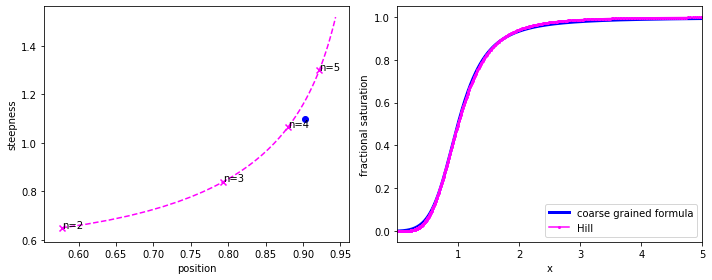

[5.66019956e-01 1.22473322e-04 2.04899535e+00 2.90359081e-01
 6.75034825e-04 1.04949175e-04]
[0.0001018  0.0001291  0.0001258  0.00013832 0.0001418  0.00031739]
[7.93353060e-02 4.94334420e-02 5.35669110e-01 3.39174585e+00
 1.35112143e-04 1.08522382e-04]
[1.63584227 0.51543001 0.95185565 1.35189996 1.96448756 0.38949405]
[1.00000000e+00 2.46462455e+05 1.41205189e-04 1.09022458e-06]
effective parameters
0.00010409633195714644,0.000129103858485272,0.00013410969044303658,0.00013950139390681007,0.00014180666332806635,0.0003173886509621706,0.9993111192963922,337.993042700228,46.90082906052247,1.0839062930617034,0.9853207584577169,0.9978154832438623,1.0050570684527433,1.0002437779280933,1.0000216446231844,130.0143698328887,1.233521742870357,0.958546794616126,1.0323336012046123,0.9943934857277895,1.0000649226736267,324.0247182207704,51.02754784492892,4.921121217594228,1.3254614074355817,5396.595639882861,1307.0763825052945,117.86762493858909,221.73259316472868,17.079827235624364,2.194275464410

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: UserWarning: Use the colorbar set_ticks() method instead.


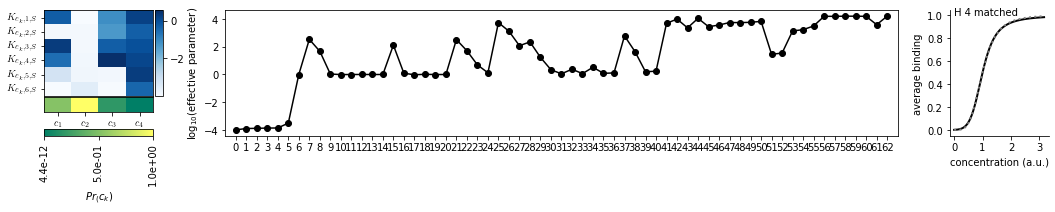

550 j=1
final_nt4_plim4_plimc6_c4_beta0.5_748.out
error 3.6156416133703675
0.00019375429489757639,0.1705329376662752,0.00017107464603532092,0.3338120563052141,18.364462854771617,0.0001002842637395858,0.00010402998273631232,0.00013289153584322214,0.00013174227189322372,0.0001746421007408526,0.0001638693511660259,0.00014098691901112993,0.0001,0.00010270846577332584,0.00010717124379313239,1.9042676411332475,0.00011620441497232888,2.192767311724095,1.3590881711440894,0.8990004058384424,4.001447970672881,3.8013118464215463,0.6263447029140687,9.496855328745434,22630.660629163773,1.0889607487360077e-06,1.3582652493389504e-06
0.9064926834504872 1.1048791424250006
function evaluated between 0.01 and 10.00


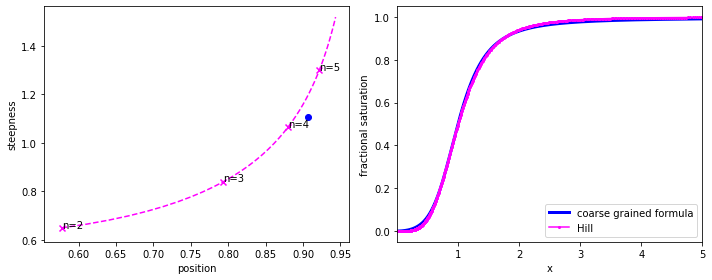

[1.93754295e-04 1.70532938e-01 1.71074646e-04 3.33812056e-01
 1.83644629e+01 1.00284264e-04]
[0.00010403 0.00013289 0.00013174 0.00017464 0.00016387 0.00014099]
[1.00000000e-04 1.02708466e-04 1.07171244e-04 1.90426764e+00
 1.16204415e-04 2.19276731e+00]
[1.35908817 0.89900041 4.00144797 3.80131185 0.6263447  9.49685533]
[1.00000000e+00 2.26306606e+04 1.08896075e-06 1.35826525e-06]
effective parameters
0.00010403402884544222,0.00014042086697679625,0.0001317442499714964,0.00018938448558262434,0.0009753122291242473,0.00014098579598641656,1.0512604853757417,1.023822415574629,1.0828672456988162,1.7180157212442235,1.052797630121297,1.0276754951870932,95.46441603440293,1010.5625611452483,1.0103983060732964,1.05982400278778,1.2495470301257314,1.1227788110214283,1466.634399265347,1.0661913218669203,0.7624083804448561,149.40069548702382,2.9097761032896976,1.865466417699106,335.6489464029608,452.0526143541267,13.9836251377189,1429.574503899623,1.8692115168858685,995.2257255239742,46.1523779622371

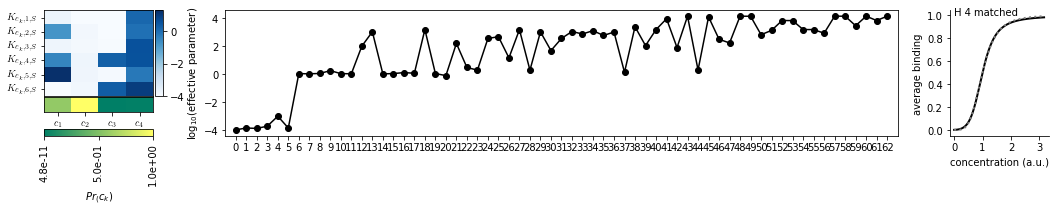

481 j=2
final_nt4_plim4_plimc6_c4_beta0.5_2530.out
error 3.9447552535005546
0.1543926972886115,24.958955503361803,0.0009561913822446309,0.899126445579961,0.0008415214049494133,0.000383585019371258,0.02380888364377265,0.00010478362249223665,0.22436036849760574,0.00010806962319450572,0.00022091646922369276,0.00015708792540126826,0.8027465935223609,3.3085176716505194,3.572678934646394,1.5935697469771433,66.66843778896181,1.4351955145932314,0.00023079552333288425,0.00011476889511683448,0.00010638302718757042,0.00010450327741575775,0.00015035172689158182,0.00011417576709554034,3.852210905594874e-06,1.577510142759879e-06,28700.29366048038
0.9108974874022608 1.1494191832262048
function evaluated between 0.01 and 10.00


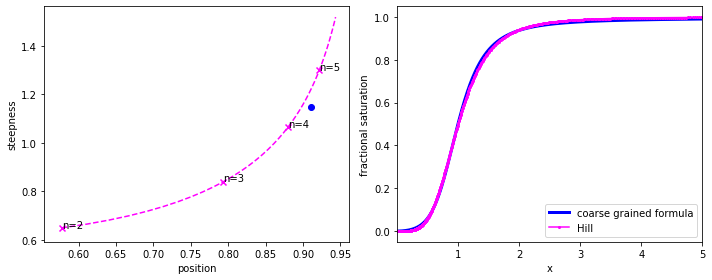

[1.54392697e-01 2.49589555e+01 9.56191382e-04 8.99126446e-01
 8.41521405e-04 3.83585019e-04]
[2.38088836e-02 1.04783622e-04 2.24360368e-01 1.08069623e-04
 2.20916469e-04 1.57087925e-04]
[ 0.80274659  3.30851767  3.57267893  1.59356975 66.66843779  1.43519551]
[0.0002308  0.00011477 0.00010638 0.0001045  0.00015035 0.00011418]
[1.00000000e+00 3.85221091e-06 1.57751014e-06 2.87002937e+04]
effective parameters
0.00023616682332947518,0.0009843758976441168,0.00010641286235835085,0.00013582675943328375,0.00015037947267401206,0.00011418523263657527,577.6409467781774,1.1879205416193115,151.53338953140556,1.1873297714451363,1.0560064999861782,8.060821181712287,5847.984564216091,5.142031931263305,3.086569058529176,2.8632470036999376,1.8193449711674152,1.0238478248754472,2.345756830667956,1.5521939615528166,1.3066221094156656,646.417983135238,653.735231603718,682.6719810083425,631.1550336328808,499.1519293365039,1529.6008282106282,78.62660316792231,774.2684466270623,344.55612040644195,797.8089772

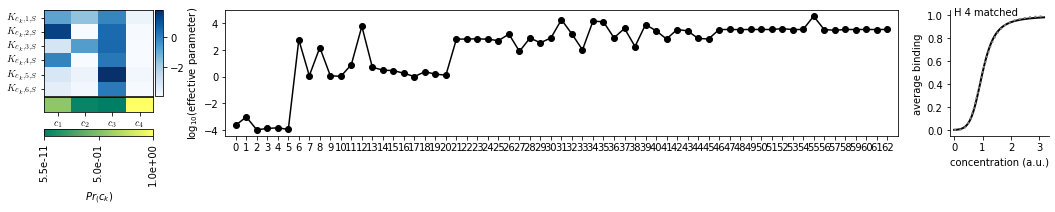

410 j=3
final_nt4_plim4_plimc6_c4_beta0.5_1954.out
error 4.040631384862001
15.607943715828625,0.00014121515241124978,1.8900391930750082,0.008462557235387948,0.0001419343991986767,0.7274769166551903,0.17213737390286632,0.0017861240516697152,23.387116092020072,0.00013826446890493292,0.00014036644194949618,0.00017383660154297726,1.0520819501612941,2.361692703407835,3.271225121579613,27.687236288658053,2.803496962665909,5.813583294264617,0.0015669455151776557,0.00012810774275636544,0.0001419451503224404,0.002722755708627833,0.00018319178737997757,0.0007692081748942735,2.009590894525464e-06,1.421070558992942e-05,28310.660111429537
0.900722546117736 1.116937779658771
function evaluated between 0.01 and 10.00


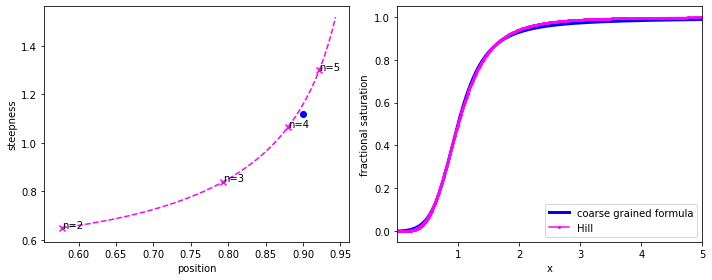

[1.56079437e+01 1.41215152e-04 1.89003919e+00 8.46255724e-03
 1.41934399e-04 7.27476917e-01]
[1.72137374e-01 1.78612405e-03 2.33871161e+01 1.38264469e-04
 1.40366442e-04 1.73836602e-04]
[ 1.05208195  2.3616927   3.27122512 27.68723629  2.80349696  5.81358329]
[0.00156695 0.00012811 0.00014195 0.00272276 0.00018319 0.00076921]
[1.00000000e+00 2.00959089e-06 1.42107056e-05 2.83106601e+04]
effective parameters
0.0021181810121878824,0.00012810939120229124,0.0002087017701057202,0.002722972340671894,0.00018319173720956857,0.0007948792343869547,1.03121184715057,2357.5205811153305,1.5510742673932723,0.9451997545519912,238.91415268103808,1.1778462961634635,1.094080148065584,1.1415899734024517,1.0709669997324054,1.754170205749586,1.0483509456116875,293.46602754832156,1.078075817466713,1.1053849834874008,1.0488970295040285,2267.4341384795725,44.20463219829047,62.45440162241795,277.2207502353383,4198.823586694084,1799.479693858302,7350.688949726962,37.25213391442837,687.1200353558274,203.234079979

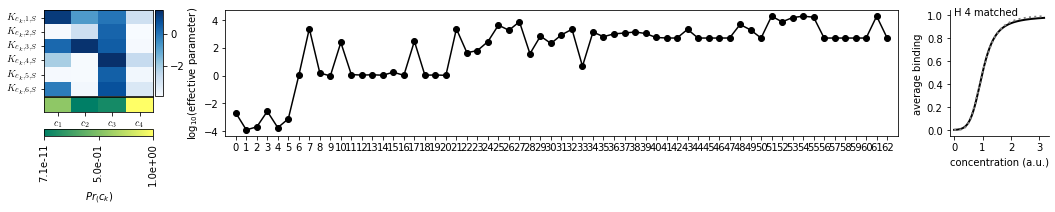

469 j=4
final_nt4_plim4_plimc6_c4_beta0.5_244.out
error 4.175960506688447
0.005325392254349245,11.262381318334564,0.0039705819215759145,37.518873590432165,0.5270523909422541,0.0013535788392344996,15.747734435819432,4.312359223099628,5.818020554515676,7.804735913691308,6.3441366909109425,74.76709880785452,0.0001,0.0002620012397521669,0.0003069654002457314,0.00011397247233992329,0.00010870737053061128,0.00013190755105587049,0.00014601353308987407,1.200540441333697,0.0023241146376481972,0.0008133321725016736,0.01832773621065986,14.942548634291079,2.2856498924488386e-05,9897.76113282591,2.0715735848681393e-05
0.9062164794927299 1.1236945445910818
function evaluated between 0.01 and 10.00


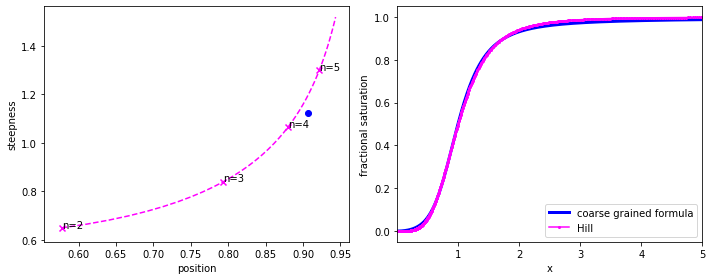

[5.32539225e-03 1.12623813e+01 3.97058192e-03 3.75188736e+01
 5.27052391e-01 1.35357884e-03]
[15.74773444  4.31235922  5.81802055  7.80473591  6.34413669 74.76709881]
[0.0001     0.000262   0.00030697 0.00011397 0.00010871 0.00013191]
[1.46013533e-04 1.20054044e+00 2.32411464e-03 8.13332173e-04
 1.83277362e-02 1.49425486e+01]
[1.00000000e+00 2.28564989e-05 9.89776113e+03 2.07157358e-05]
effective parameters
0.00010056424525226615,0.0013997438865840021,0.0003073489463081928,0.003904238481407593,0.0001619553531688677,0.00013223487742397203,44.343693495694275,7.906740368240798,52.161009266817345,32.240684059953324,205.4878653891061,10.822419610917729,7811.156691663806,2645.6091645063384,12.73197427378762,12.658189515321565,6.62966944321486,25.72497680345783,3159.5020061333653,12.57635419184074,55.20264653499639,1999.846825461765,53.24007922396459,69.44089617824073,49504.250173529734,1133.3988719009387,40475.98728148499,150437.66320937427,61.91333698722294,32538.224418320486,145075.7700070

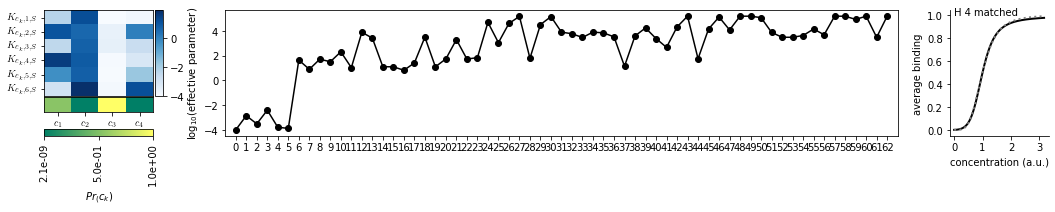

298 j=5
final_nt4_plim4_plimc6_c4_beta0.5_1045.out
error 4.230595016690244
0.00013373073888995593,0.00010510010316493769,0.00010167173023889478,0.0001053576597610416,0.03155745336085028,0.00043706958232667164,2.0463125853230024,0.59997961639001,0.11919538710363986,0.20922641110086385,0.2940639090309379,0.4384973766176441,0.00026083259964379747,0.00016527184890604413,0.00011314016810886772,0.00011052393552658269,0.00016781769772839964,0.00012040144044794683,0.4168350293976674,1.0089226199190353,0.00011305658897721488,0.0005680823663067737,0.3381344666417873,0.00013876566995447122,1.0016822096117202e-06,8360.867996390552,0.021990330496937573
0.9077257888541995 1.1496762907203508
function evaluated between 0.01 and 10.00


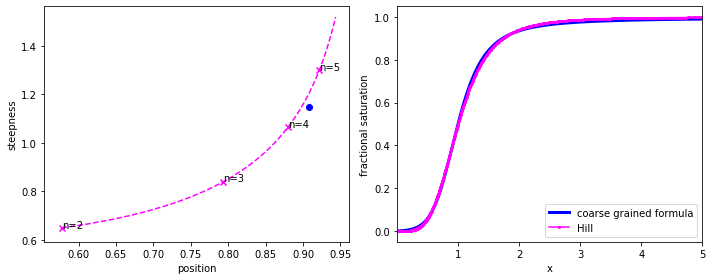

[0.00013373 0.0001051  0.00010167 0.00010536 0.03155745 0.00043707]
[2.04631259 0.59997962 0.11919539 0.20922641 0.29406391 0.43849738]
[0.00026083 0.00016527 0.00011314 0.00011052 0.00016782 0.0001204 ]
[4.16835029e-01 1.00892262e+00 1.13056589e-04 5.68082366e-04
 3.38134467e-01 1.38765670e-04]
[1.00000000e+00 1.00168221e-06 8.36086800e+03 2.19903305e-02]
effective parameters
0.000261913162998522,0.00016791758289505567,0.00011313881064144693,0.00011052454604083489,0.00017246041945971044,0.00012043941165926846,26.131007003023637,1.0009878060232504,1.0190893632619173,9.18776628387139,1.0038900339151937,1.0004432446936586,1.0662157277788031,31.952597794844262,1.0038487651013366,1.0002391140413134,0.9980049766347703,1.0004270536331397,1.0207039848880204,1.0008119206112145,1.0587509325517424,29.619393777945803,128.0847011008576,1543.293007958998,41.96770187594718,2.8831950146051324,10.882076925732575,4.588442240355458,45.24197510509192,7.464912544260883,15.371020017729101,1.918525752603884

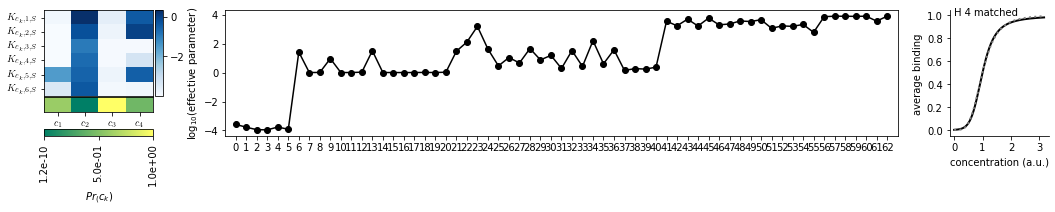

402 j=6
final_nt4_plim4_plimc6_c4_beta0.5_19.out
error 4.500681067025669
0.3642723645368045,0.00027468618269040513,2.3662511871196936,0.00010045378365641136,0.3850524721104046,0.00016608817301128772,4.912694758035342,2.801606575906259,0.5837555886574088,0.5943354568354441,5.087416769054291,5.690394255204367,3.969002212231373,0.13443803772545157,0.00015349250929412266,0.01647995684770904,0.042029363357653234,0.00011900963334976863,0.0002122396229323277,0.0001,0.0010314879243357332,0.0001050617115449727,0.0009648419428234467,0.0001167585979287511,1.815838005046228e-06,1.4291082629611456e-06,2410.047089484799
0.9079937454814726 1.153084943332904
function evaluated between 0.01 and 10.00


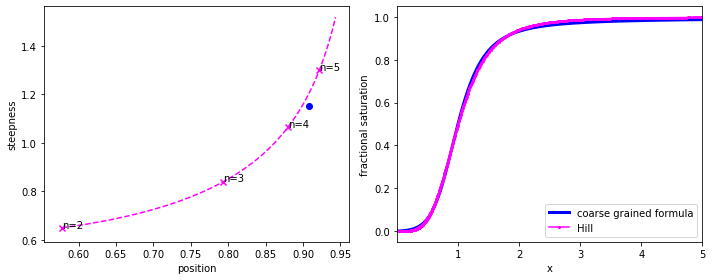

[3.64272365e-01 2.74686183e-04 2.36625119e+00 1.00453784e-04
 3.85052472e-01 1.66088173e-04]
[4.91269476 2.80160658 0.58375559 0.59433546 5.08741677 5.69039426]
[3.96900221e+00 1.34438038e-01 1.53492509e-04 1.64799568e-02
 4.20293634e-02 1.19009633e-04]
[0.00021224 0.0001     0.00103149 0.00010506 0.00096484 0.00011676]
[1.00000000e+00 1.81583801e-06 1.42910826e-06 2.41004709e+03]
effective parameters
0.00036324236282683265,0.00010007464194662343,0.002012481104935667,0.0001050602576122536,0.0011241490447809952,0.00011678334327720035,2.019127514650507,489.35209284304443,1.0403922523210394,143.01651693897952,1.67178302358831,1.8566212072964883,1.119341454127352,1.3426826290991474,2.0275921006499047,0.9798604685492048,167.48028586997188,1.2164243002193467,1.013064263043182,1.2075507384683148,1.2258695312243324,767.7191452286315,1443.863242205074,1252.981515892716,6853.744700196984,494.5812263651952,1000.2780305440186,690.3724213891796,392.40716794318854,2326.065153794269,1997.946590422685

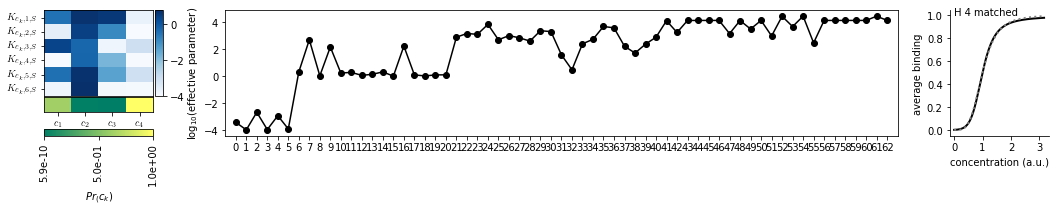

392 j=7
final_nt4_plim4_plimc6_c4_beta0.5_1810.out
error 4.5329014048713505
0.0009221142742408357,0.0022611130557709997,3.3024323533078217,0.06896474687297653,0.3061544288950615,0.0001268927622427658,16.9464637424554,2.2823867951506744,0.37871536674913464,2.600924215339124,0.32898476200892096,0.43728029234892357,0.2568545049188818,0.002808369469386327,0.0001,0.00010200876896979698,0.00011857682510106989,0.3275586436683255,0.00014808066007614623,0.00015397669302369353,0.0001386428175885221,0.00012510887974085264,0.0001,0.00011109598182088652,1.6365007830990583e-06,4.359139705039495e-05,4251.882695690057
0.9060592938028692 1.1392293464880694
function evaluated between 0.01 and 10.00


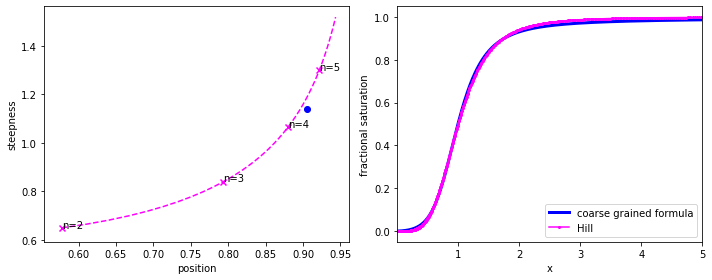

[9.22114274e-04 2.26111306e-03 3.30243235e+00 6.89647469e-02
 3.06154429e-01 1.26892762e-04]
[16.94646374  2.2823868   0.37871537  2.60092422  0.32898476  0.43728029]
[2.56854505e-01 2.80836947e-03 1.00000000e-04 1.02008769e-04
 1.18576825e-04 3.27558644e-01]
[0.00014808 0.00015398 0.00013864 0.00012511 0.0001     0.0001111 ]
[1.00000000e+00 1.63650078e-06 4.35913971e-05 4.25188270e+03]
effective parameters
0.00014827181429181727,0.00015447305915364135,0.0009151265650887099,0.00014129646293793471,0.00017196412094328328,0.0001111032207000407,1.6668103087366868,5.446575030939614,2.4073975451973784,3.268207641451702,1.2255258347444995,12.57382640176945,2.6669335309361215,6.717966512484668,1.0233447603648878,414.2942437645129,1510.7669300812138,1.1212102879271568,204.8503340973028,1.0441451555255075,1.0623720774660752,27.542444201210568,4489.3672985196845,190.80906314320944,2501.126780535411,7.026018388110217,6.241821978582211,69.40526495145707,13.766057993375906,3053.2247236103267,315.087

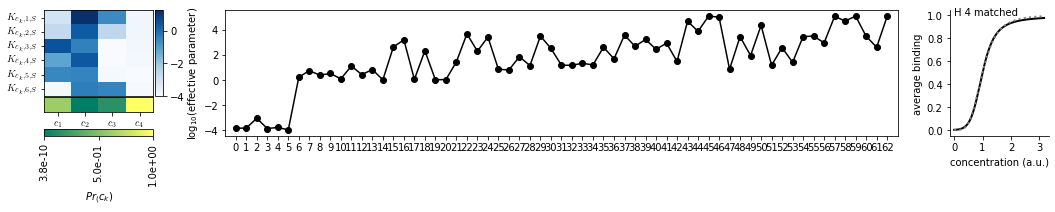

475 j=8
final_nt4_plim4_plimc6_c4_beta0.5_2485.out
error 4.542639543673367
0.0001306141999228564,0.00011501988175856622,26.610000219707956,0.00248755255150628,0.00012049604697734598,0.00028374998903350426,0.5094553017472806,0.03983191796501502,338.3569863161936,72.18032208638148,0.0011748177802276556,0.048067764690474156,35.43641081142241,1.789399192049237,66.68710548324442,13.489728489344152,3.457010640332298,10.073264160618793,0.00010572915503928503,0.000578498328366817,0.0001,0.007128408236714719,0.00014381002930686753,0.006020332690420983,0.004477519301385638,1.2134478014739494e-06,11105.660757126529
0.9027132853840204 1.1345100938599189
function evaluated between 0.01 and 10.00


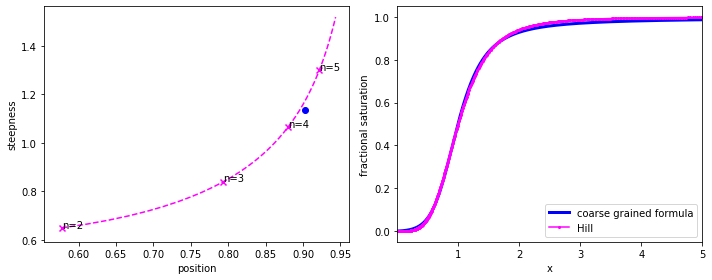

[1.30614200e-04 1.15019882e-04 2.66100002e+01 2.48755255e-03
 1.20496047e-04 2.83749989e-04]
[5.09455302e-01 3.98319180e-02 3.38356986e+02 7.21803221e+01
 1.17481778e-03 4.80677647e-02]
[35.43641081  1.78939919 66.68710548 13.48972849  3.45701064 10.07326416]
[0.00010573 0.0005785  0.0001     0.00712841 0.00014381 0.00602033]
[1.00000000e+00 4.47751930e-03 1.21344780e-06 1.11056608e+04]
effective parameters
0.00010594060533907705,0.0005784726185920162,0.0026322614873941267,0.007157087625686876,0.0001438087235235868,0.0060198342421180434,1.2445137589749238,251.28334657186042,20.614325247838206,1.8923500282885855,1.0746334821496057,3.7957197466438846,1.276542971758913,1.0083289903513901,1.000824813378483,522.9750197980233,1.2905006948379685,0.49930390671813035,1.0341022491529754,1.028795579989769,1.0044260819517887,5275.201695939111,1222.3003526478385,2697.093503075947,191.0687424240508,4808.909420294846,18824.51623305371,7088.1940885720205,1756.6086688983469,264.7467780085538,1464.67060

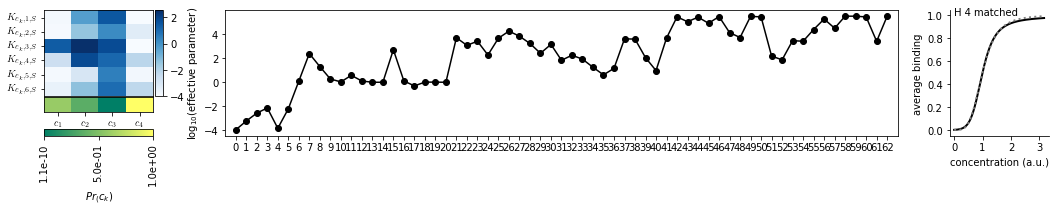

561 j=9
final_nt4_plim4_plimc6_c4_beta0.5_838.out
error 4.5915812516422125
0.0001,0.00015226200934278296,0.10968425745789982,0.012199537926069766,0.2921016431160771,0.8491004298714386,0.00021939023033963403,0.00010793040600537224,0.00010572716829899544,0.00015925055544333845,0.00015170432811571728,0.0007334351083385905,0.00011897232736373693,0.04648912695641314,0.00017220638108432967,0.00010468801587681078,0.00016334416797711925,1.2000945373777008,3.161594175158784,11.002426899758536,0.6963698390707544,0.3985868685879909,0.5822352658233841,0.8375025764963953,1207.8501099184239,1.0053702442545073e-06,1.0878191991744654e-06
0.9017090064900565 1.1240297438406177
function evaluated between 0.01 and 10.00


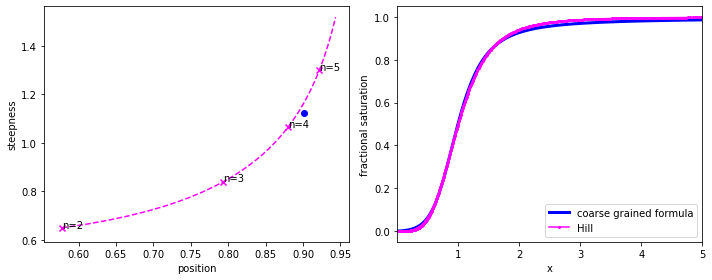

[1.00000000e-04 1.52262009e-04 1.09684257e-01 1.21995379e-02
 2.92101643e-01 8.49100430e-01]
[0.00021939 0.00010793 0.00010573 0.00015925 0.0001517  0.00073344]
[1.18972327e-04 4.64891270e-02 1.72206381e-04 1.04688016e-04
 1.63344168e-04 1.20009454e+00]
[ 3.16159418 11.0024269   0.69636984  0.39858687  0.58223527  0.83750258]
[1.00000000e+00 1.20785011e+03 1.00537024e-06 1.08781920e-06]
effective parameters
0.00021929431164304972,0.00010797701787797974,0.0001963747073752486,0.00016921102995820335,0.00039321530544897057,0.001435233538424232,2.3216761074688907,0.7948885498194099,0.9985254527859367,0.6850873551418849,0.7415633894097087,1.514424946184078,1.2400438314305944,1.3876365865322593,1.2543034450363417,33.82582335352016,343.4459350949055,273.6290964091658,44.67022932296285,35.765855657916866,363.7506726241681,3096.0230553617503,2511.9670676127175,1411.1906804571563,615.6666448286742,3.6678405223351698,0.654678588478069,0.5546632734847955,1.4733926611393575,0.9619072758670726,0.4871

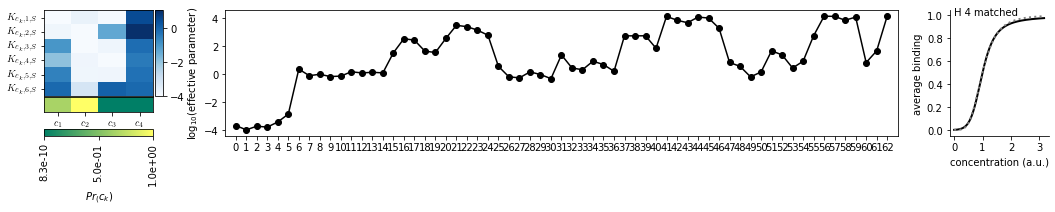

548 j=10
final_nt4_plim4_plimc6_c4_beta0.5_730.out
error 4.70791509201651
2.844427371771793,0.00026504230858095934,0.10900029335193184,1.0532481292074358,0.004229562445834192,0.001129921991725404,0.00014157694764721493,8.546399299098034,0.0001175213464309262,0.0001226635959990828,0.0008861645959603871,0.00011787967409848836,0.000509016799195362,0.00013610512897316217,0.0009595087301439763,0.0001627218999245693,0.0006835228536672729,0.00013288610036506497,4.822475746718131,2.4238954063223783,0.1658670913916911,0.42404936205207483,13.888955071107823,1.739897818054964,0.0011938942192342772,25131.822193546446,1.1922394281703956e-06
0.9029224883502214 1.13199617143345
function evaluated between 0.01 and 10.00


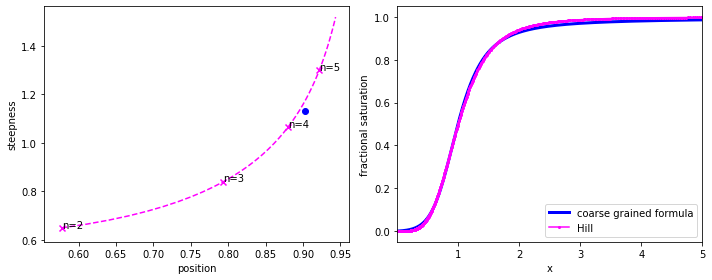

[2.84442737e+00 2.65042309e-04 1.09000293e-01 1.05324813e+00
 4.22956245e-03 1.12992199e-03]
[1.41576948e-04 8.54639930e+00 1.17521346e-04 1.22663596e-04
 8.86164596e-04 1.17879674e-04]
[0.00050902 0.00013611 0.00095951 0.00016272 0.00068352 0.00013289]
[ 4.82247575  2.42389541  0.16586709  0.42404936 13.88895507  1.73989782]
[1.00000000e+00 1.19389422e-03 2.51318222e+04 1.19223943e-06]
effective parameters
0.0006221725565589932,0.00013651635062321443,0.0009638074901486365,0.00020462271817218368,0.0006836646140900797,0.00013292585285033784,1.1759977065270382,21.386679093176358,936.9611282801351,1.950764871719291,2.3689207175281424,1.0017453097025744,1.1939481554598337,1.0181850475368315,1.0109684583832457,23.953501020507957,1.0232982608245424,1.0335596293900227,2.064062471599218,2.5371492045562887,1.014160609412192,41.80287187655847,1534.4007994915962,133.20739378134633,88.30198564734266,4420.700892202017,126.42615593609742,170.7825845902072,2814.211632855526,3141.1733055993313,106.647

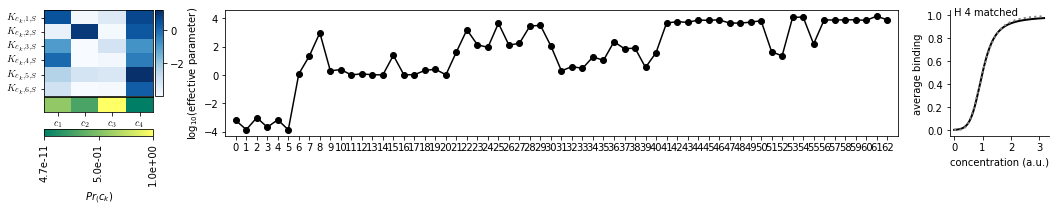

507 j=11
final_nt4_plim4_plimc6_c4_beta0.5_397.out
error 4.711907208502431
29.81220887019644,0.00012058506109861742,5.477627003637793,0.06923728447481575,0.002084960355037898,0.000629129171983364,0.0012387155985219575,0.00013059905632490667,0.0007023403808385558,0.00016155492247713874,0.0006607050922138035,0.0001,0.3784322938369695,0.0030279755464761317,22.248913275398046,0.10776774571574571,0.008997127989666646,0.023561699009119686,2.8226814076567632,3.7605473554316875,1.0945171415107169,5.6366131535250865,6.346344155018377,195.01343250247254,15665.635514594398,0.0008683124141908704,2.3000131918220375e-06
0.9160155578679882 1.1318363230245292
function evaluated between 0.01 and 10.00


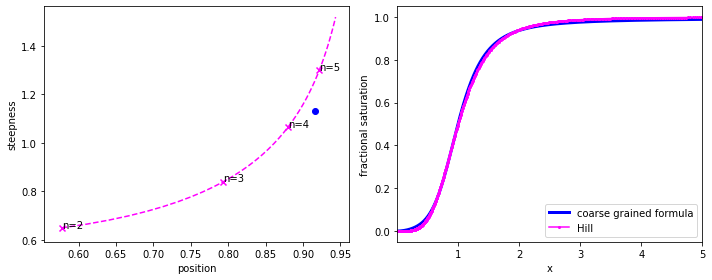

[2.98122089e+01 1.20585061e-04 5.47762700e+00 6.92372845e-02
 2.08496036e-03 6.29129172e-04]
[0.00123872 0.0001306  0.00070234 0.00016155 0.00066071 0.0001    ]
[3.78432294e-01 3.02797555e-03 2.22489133e+01 1.07767746e-01
 8.99712799e-03 2.35616990e-02]
[  2.82268141   3.76054736   1.09451714   5.63661315   6.34634416
 195.0134325 ]
[1.00000000e+00 1.56656355e+04 8.68312414e-04 2.30001319e-06]
effective parameters
0.003141568478542145,0.0001305991297829781,0.0010531652446863983,0.0001659708116032823,0.0006607973959478281,0.000100063704452525,0.9575006490767842,3150.8193443218124,253.07800956646187,2.3067548322961318,4.461002820192189,1.0049130531539587,1.1423172019370242,1.0405988223598337,9.238569693853401,139.90776525252974,1.731646472977568,3.3267652370878107,1.1055860908542807,10.86553016029289,3.7484841571481153,2902.0703724042287,317.5892160483097,37.131865180269706,801.6695362548074,9394.337799007775,5742.366780844657,6044.371367593688,760.451500848779,949.8584112908368,661.9706

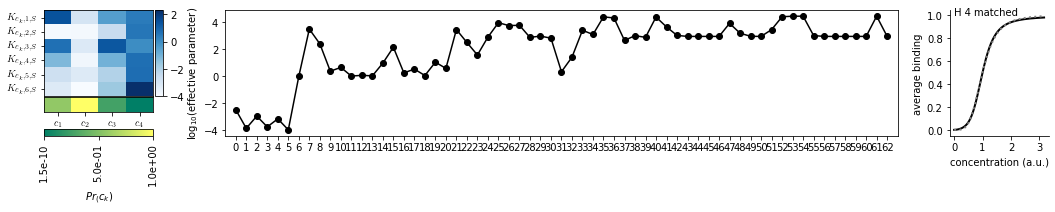

474 j=12
final_nt4_plim4_plimc6_c4_beta0.5_2476.out
error 4.739822460040784
0.1305013748902727,0.00048763464890356226,0.00011224266803261291,1.5351294373438358,0.4634403634384012,0.0001,0.3463768907132953,0.562389413295888,6.752233644160009,0.22592912836919538,0.86975795801412,0.4387262707305197,0.00028633469542567485,0.0001,0.00010809497545252514,0.00013426179997966684,0.00011671646263343461,0.0001288028820396396,0.0001,0.001736210251284025,0.00011009825157842204,0.00014037240575446444,0.0974134394193339,0.000162304677865445,1.3667468738392382e-06,88026.93095227935,4.0674208766567114e-05
0.8941693448104738 1.0570815953243415
function evaluated between 0.01 and 10.00


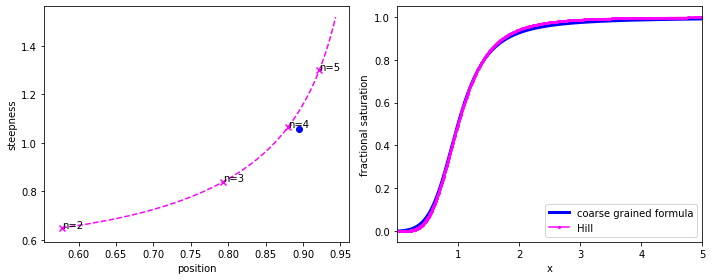

[1.30501375e-01 4.87634649e-04 1.12242668e-04 1.53512944e+00
 4.63440363e-01 1.00000000e-04]
[0.34637689 0.56238941 6.75223364 0.22592913 0.86975796 0.43872627]
[0.00028633 0.0001     0.00010809 0.00013426 0.00011672 0.0001288 ]
[0.0001     0.00173621 0.0001101  0.00014037 0.09741344 0.0001623 ]
[1.00000000e+00 1.36674687e-06 8.80269310e+04 4.06742088e-05]
effective parameters
0.0002878139475694338,0.00010000441302781257,0.00010809512740680146,0.00015169939583200908,0.00012197989195397987,0.00012880256166328467,1.0200267116330402,1.0013634213432643,53.00526107412294,20.52194400684557,0.9989142696697793,1.005454780457269,1.4456847626129326,1.1678815289548443,1.0002874245214628,1.0058540448649735,1.008570015239795,1.0033024084576663,437.61044531619,0.9743741862978572,0.9907280254127745,7.543665538380139,176.52813245839522,83.16467837499115,1.3718381099452996,56.41331739018853,29.343762539450235,4.95834234882569,452.5474479245658,42.53396653271032,16.754805619591185,9.534225888009942,39.7

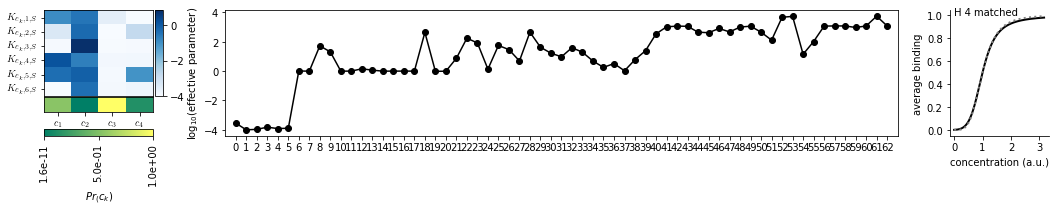

509 j=13
final_nt4_plim4_plimc6_c4_beta0.5_415.out
error 4.818145740516633
0.00012020361743393102,0.0001,0.00010562568549988647,0.4726565385762529,0.023721113870200428,0.00010578756752823814,1.0404139275733475,1.5452507521671797,2.58547807248738,0.27530603306826845,0.35209862077788345,1.2577729230169068,0.00021266295795765167,0.00010433717140118009,0.00010316453866921769,2.2548215282934767,1.0160276070301593,0.43018691182430047,0.0001,0.00011741946148968935,0.00038701065076385087,0.00010363690988317733,0.0002902209715140992,0.00029321416466047566,1.3439331608934378e-06,0.009054921400442898,566.9535074926016
0.9075076937561755 1.1725930158195546
function evaluated between 0.01 and 10.00


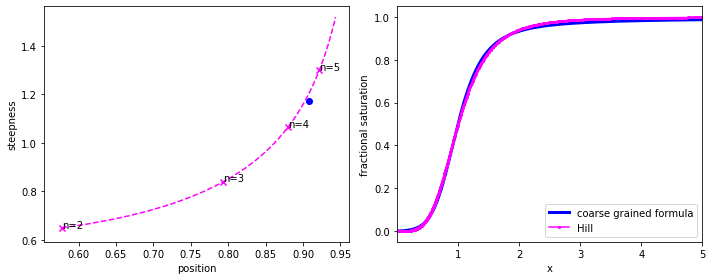

[1.20203617e-04 1.00000000e-04 1.05625685e-04 4.72656539e-01
 2.37211139e-02 1.05787568e-04]
[1.04041393 1.54525075 2.58547807 0.27530603 0.35209862 1.25777292]
[2.12662958e-04 1.04337171e-04 1.03164539e-04 2.25482153e+00
 1.01602761e+00 4.30186912e-01]
[0.0001     0.00011742 0.00038701 0.00010364 0.00029022 0.00029321]
[1.00000000e+00 1.34393316e-06 9.05492140e-03 5.66953507e+02]
effective parameters
0.00010003982988579091,0.00011739223898302969,0.00038651681367353095,0.0009715982796342118,0.00034766980702189126,0.00029974085717674744,1.3238192670505173,1.1643008156447812,1.2212216190356278,1.1012526354760466,1.128749298673276,1.208492512136403,0.8778368817536302,1.0087556196949468,1.1282793419007822,0.35504037133278343,0.8956356848077591,1.0504303293597663,166.65487607838978,53.51013736088125,67.73503486553477,1793.8230637538784,105.75968024300185,326.243742378745,1205.6360994991526,132.52709660832883,187.14041679117034,658.5291670047994,1.8434564625007674,2.665072756363917,3.6552798

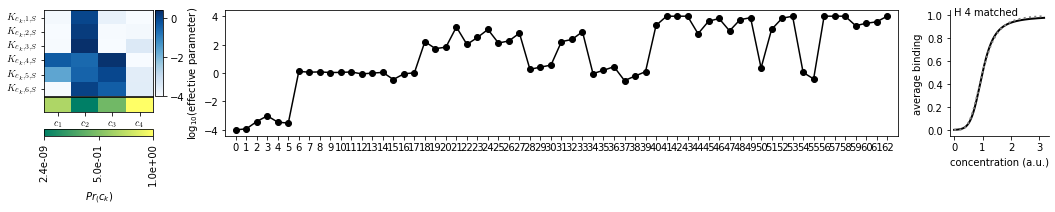

matching Hill 5
parameter limit is 4
#new combi------
n=5 c=4 plim=4
866
188 j=0
final_nt5_plim4_plimc6_c4_beta0.25_2523.out
error 1.9804022935798837
0.006344852856340832,6.942057721726878,0.00014338127328010123,0.017887055957341934,0.33128517536467,0.025082285613381546,0.00010947610216112061,0.0035816198463972304,0.00013774864542107464,9.707886065771934,32.26821489191716,3.257075863245031,0.0001667253200246293,0.00014782853476482928,0.00017308564678339183,0.0002784084683189892,0.0001,0.0002091695516040974,25.635985838736023,17.681119969969462,20.76299691471981,30.353423903713306,12.575722096286597,22.69155556461024,0.7838063250181718,149151.91226576036,1.0024219633622632e-06
0.930655670731143 1.3510300466012009
function evaluated between 0.01 and 10.00


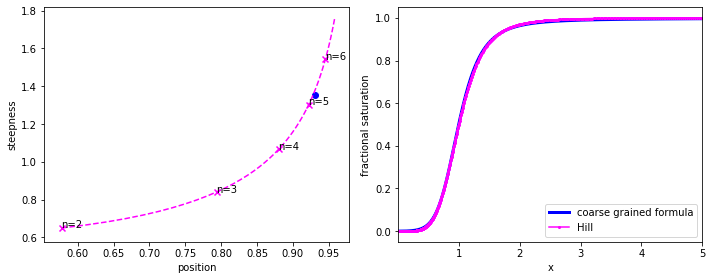

[6.34485286e-03 6.94205772e+00 1.43381273e-04 1.78870560e-02
 3.31285175e-01 2.50822856e-02]
[1.09476102e-04 3.58161985e-03 1.37748645e-04 9.70788607e+00
 3.22682149e+01 3.25707586e+00]
[0.00016673 0.00014783 0.00017309 0.00027841 0.0001     0.00020917]
[25.63598584 17.68111997 20.76299691 30.3534239  12.5757221  22.69155556]
[1.00000000e+00 7.83806325e-01 1.49151912e+05 1.00242196e-06]
effective parameters
0.00016676661268654472,0.0001943886886676383,0.0001730854014751694,0.00032954044531673663,0.0002717902472734328,0.00022645137997635988,9.963840229522214,1.123888933933327,1.0552502667184596,1.136124952559735,1.1048409953458838,1.032220922268049,16.547215702219336,303.6478774785394,28.676432439483794,1.0425913623194276,0.9085265039814027,1.065228077964703,18380.201357534836,2227.489810563952,8974.917731590347,10928.815511754161,553.1159834196478,50.9125358451468,363.609480653279,10949.834490758747,6312.778845345417,11659.186592806587,0.8969250595346114,4.938091451742781,1.19396691066

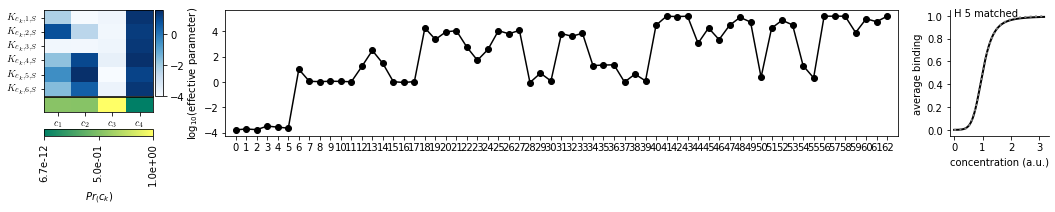

161 j=1
final_nt5_plim4_plimc6_c4_beta0.25_2298.out
error 1.9808489154536504
0.0001034666002896167,77.92710593765666,0.0003919647266587685,2.0809850513737267,0.5810220047913952,0.00011612818684000965,0.0001,0.00010769077192389891,0.00013689724511785112,0.00023792272497595284,0.00013284627105229302,0.00011432038028644688,0.0006976391444606786,0.22898750662814454,0.0001461599252736313,0.0007634317467583349,28.040283487456193,0.00011087127244226961,4.692177846463475,4.668275239055034,16.624053772049862,6.250053036572774,15.21282006038742,6.694135235192494,627560.9040946283,1.1726022030400349e-06,1.1423359516713398e-06
0.9311878004037855 1.3433757928863888
function evaluated between 0.01 and 10.00


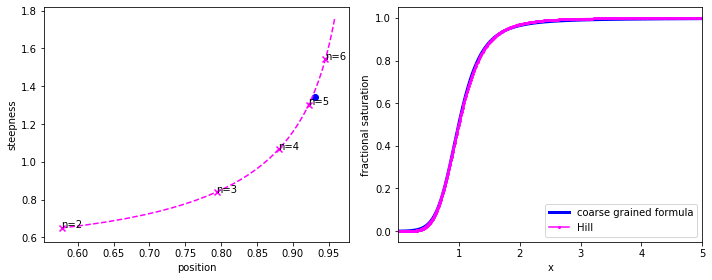

[1.03466600e-04 7.79271059e+01 3.91964727e-04 2.08098505e+00
 5.81022005e-01 1.16128187e-04]
[0.0001     0.00010769 0.0001369  0.00023792 0.00013285 0.00011432]
[6.97639144e-04 2.28987507e-01 1.46159925e-04 7.63431747e-04
 2.80402835e+01 1.10871272e-04]
[ 4.69217785  4.66827524 16.62405377  6.25005304 15.21282006  6.69413524]
[1.00000000e+00 6.27560904e+05 1.17260220e-06 1.14233595e-06]
effective parameters
0.00010000001406591163,0.00023186498221160217,0.0001368976818199334,0.00024123834094159628,0.00013377197959621467,0.0001143203953520893,1.0202846935707068,1.0103715578782626,1.002689154814405,1.009954981559758,1.0050011035165944,2.0022754659510276,4620.2192891565055,2326.543606656525,1.0106146914807679,1.0313345212598062,1.038029417149188,1.0129431343829916,60.687426354124376,1.0029786906812843,1.0122304904097745,105.3160814689285,1.0443051096654528,1.118713659529629,100.65295924042988,261.54532292519974,1137.261858807931,600.5549056445974,5.1806413964751306,130.18749300350564,562.8

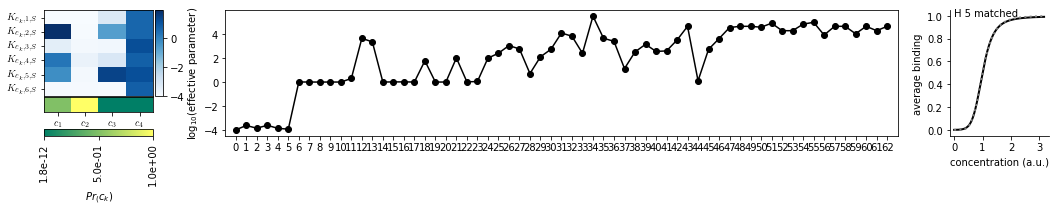

80 j=2
final_nt5_plim4_plimc6_c4_beta0.25_165.out
error 1.9814445888072445
0.005613100275887553,0.0001048312348904536,0.010909879705239654,0.013307149476724543,30.507204093802894,0.08681604040793242,0.00019313907700911016,0.00010248187184459309,0.00040360410859756454,0.0007566637764169746,0.0007919214122993602,0.00018900923607326534,7.245944703276655,0.007536802869148295,0.004549223391065786,10.3201126329606,0.0001,1714.870940957653,175.8324754684598,29.997733509606746,26.416409157044175,34.022568749903606,32.995235224053054,16.589149934060984,413466.4951125112,0.06291652860865521,1.0506478176825814e-06
0.9299994333699495 1.3452861526761524
function evaluated between 0.01 and 10.00


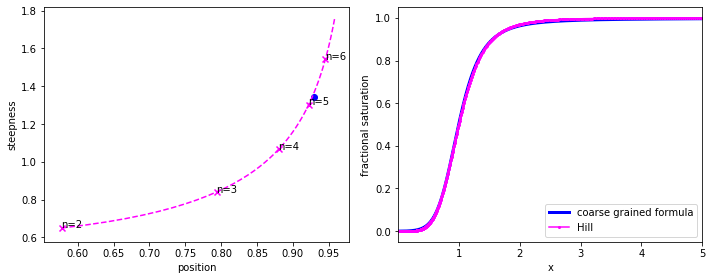

[5.61310028e-03 1.04831235e-04 1.09098797e-02 1.33071495e-02
 3.05072041e+01 8.68160404e-02]
[0.00019314 0.00010248 0.0004036  0.00075666 0.00079192 0.00018901]
[7.24594470e+00 7.53680287e-03 4.54922339e-03 1.03201126e+01
 1.00000000e-04 1.71487094e+03]
[175.83247547  29.99773351  26.41640916  34.02256875  32.99523522
  16.58914993]
[1.00000000e+00 4.13466495e+05 6.29165286e-02 1.05064782e-06]
effective parameters
0.00019425520383845905,0.00010248308501832001,0.0004036302167099902,0.0007582644927799566,0.0008657032670353901,0.0004501672328454758,2.0849917473147044,1.2105829936172943,78.34851966330885,3.4605940720072494,21622.88238213062,1.0487929568604923,1.1835989994675102,1.030291949607806,43.077794964623635,1.0297732001382551,3.22476164546665,6.971900121583117,2.413164082896851,7889.842559463538,16.8914357244121,42017.9577107709,30323.14569596846,24909.1617347438,37489.405120109426,7405.502109953628,1800.0941558526627,35750.48596661228,1651.9700668765793,37299.60408824252,367.259071

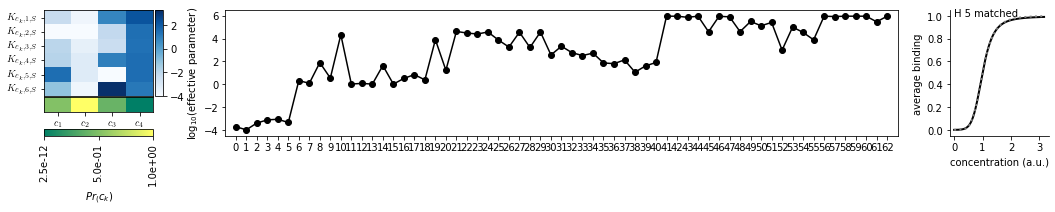

255 j=3
final_nt5_plim4_plimc6_c4_beta0.25_714.out
error 1.983198733009102
0.00010631058689500813,0.00014760888022160947,0.0001,31.67809383633777,62.77754482158087,0.5695462952987835,0.00012193755583778446,0.0003158665224569463,0.00019998755050620258,0.0002778551740922589,0.00013343606389148242,0.00048474240341162683,16.41777669500506,16.325549460380493,13.851269662845164,34.350368629026434,22.141277901921015,13.2529350374471,0.002623598909499191,8.77350727772298,0.00011412782229797847,1384.4176494527212,0.0001,0.0001,768912.2911147018,1.0514015944805858e-06,0.011886477534088405
0.9324901305341415 1.3437315211953984
function evaluated between 0.01 and 10.00


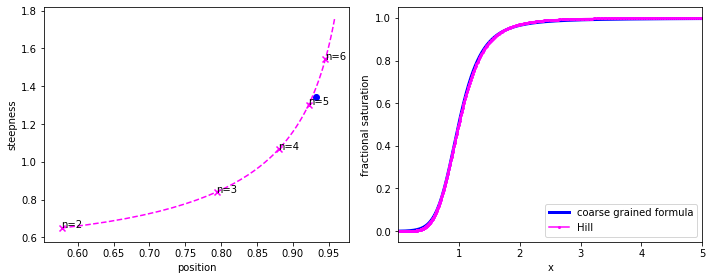

[1.06310587e-04 1.47608880e-04 1.00000000e-04 3.16780938e+01
 6.27775448e+01 5.69546295e-01]
[0.00012194 0.00031587 0.00019999 0.00027786 0.00013344 0.00048474]
[16.4177767  16.32554946 13.85126966 34.35036863 22.1412779  13.25293504]
[2.62359891e-03 8.77350728e+00 1.14127822e-04 1.38441765e+03
 1.00000000e-04 1.00000000e-04]
[1.00000000e+00 7.68912291e+05 1.05140159e-06 1.18864775e-02]
effective parameters
0.00012193759663629946,0.0003160019489724446,0.00019998743808119558,0.00034045481685336253,0.00021508042356402203,0.0004854825010417352,1.0183163731488438,1.0127509793378724,2.292724208772673,0.9703045165696973,1.0048299771482423,1.0047087068438847,1746.1667092920127,0.8049222857219542,1.000775864124397,0.9220664829379415,0.8199616314903614,1.0018230385724698,35320.95086041873,142.79540443277693,445.95285281026145,656.6813099117084,22.055155432794347,1217.4167026732025,260.44621327405935,1397.0695321136577,1601.8543949302832,348.4553180837384,0.9260016573523233,4.425534659285504,2.0

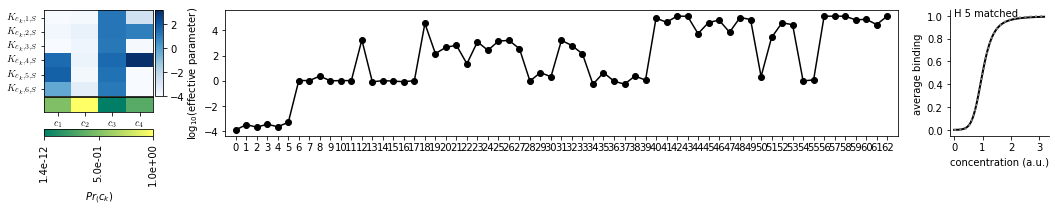

290 j=4
final_nt5_plim4_plimc6_c4_beta0.5_1003.out
error 1.984964707578707
34.29555344486859,0.00017387174985356038,1.0780899062633078,0.00012541637218947568,0.0001,23.423985256037707,0.00011528989187057475,0.00012465543514242222,0.00010573933954547473,0.000990060669577458,0.00012835343303578572,0.0001,0.00011224435445238412,0.0001,0.00014319054191382243,0.0002510618523752054,150.1246049872688,0.0001,16.696396497946584,30.92781055015426,10.491630090859374,30.538243162168925,7.227066646911427,25.39505994711082,474812.9358189394,3.137725709394897e-06,1e-06
0.9310991561450316 1.3447236457592737
function evaluated between 0.01 and 10.00


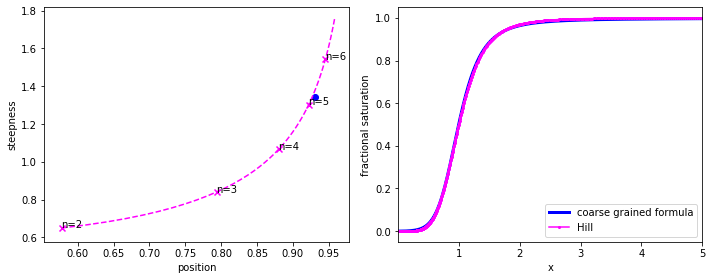

[3.42955534e+01 1.73871750e-04 1.07808991e+00 1.25416372e-04
 1.00000000e-04 2.34239853e+01]
[0.00011529 0.00012466 0.00010574 0.00099006 0.00012835 0.0001    ]
[1.12244354e-04 1.00000000e-04 1.43190542e-04 2.51061852e-04
 1.50124605e+02 1.00000000e-04]
[16.6963965  30.92781055 10.49163009 30.53824316  7.22706665 25.39505995]
[1.00000000e+00 4.74812936e+05 3.13772571e-06 1.00000000e-06]
effective parameters
0.00018751914266498985,0.00012465560393258864,0.0001080096913132613,0.0009900589128696191,0.00012835438061314447,0.0001493328204665959,1.1986018332089048,3845.3072463800627,0.6693940592917412,0.9254685283603655,60419.54587925889,1.059055002892016,1.0161161582780214,1.0294191780264381,1.2192891664625647,0.9879528812470169,1.0068777881693804,3298.110725953615,1.0036521774638347,0.722540221225516,0.9471880440456784,9331.468137752003,1412.9842294083699,2545.7833875259303,75606.32842433041,1062.2730698439993,3994.117249857917,182853.60302663274,325.14307526623,11954.586047615727,51592.78

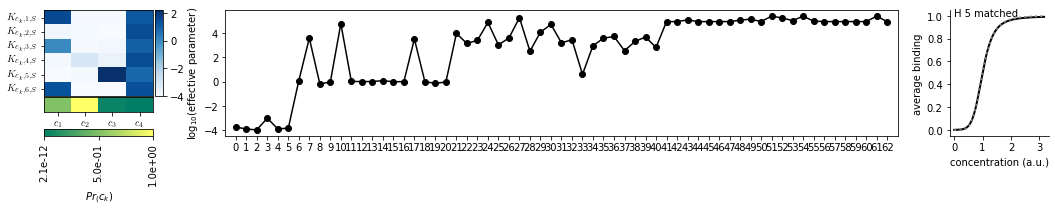

192 j=5
final_nt5_plim4_plimc6_c4_beta0.25_2550.out
error 1.9853094403797307
0.00291996767504034,150.03702112872878,5.203301393326094,2.4136052312975123,0.016955024409495187,0.0005988970145316329,0.0024961494248723274,11.0174036782168,0.0008752095135421165,0.00043567020720217803,52.52524329744247,0.00015065242583567549,14.922425941658851,19.76773767381661,22.819770897863748,46.00443727847248,32.20322381294906,19.917896372122073,0.0001,0.0008016657991183293,0.0001,0.0001429013369352722,0.00018150347991417994,0.00010019825729488286,0.0010245758926474991,1.134637592482474e-06,351005.63804656826
0.9309485048977048 1.350775272675191
function evaluated between 0.01 and 10.00


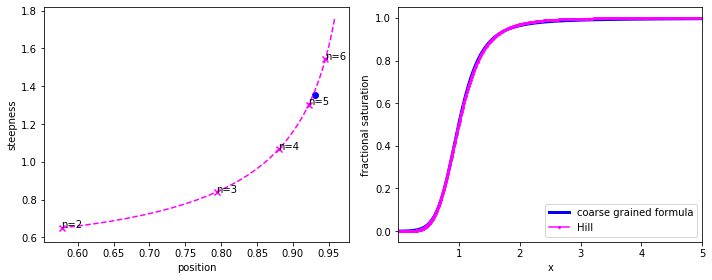

[2.91996768e-03 1.50037021e+02 5.20330139e+00 2.41360523e+00
 1.69550244e-02 5.98897015e-04]
[2.49614942e-03 1.10174037e+01 8.75209514e-04 4.35670207e-04
 5.25252433e+01 1.50652426e-04]
[14.92242594 19.76773767 22.8197709  46.00443728 32.20322381 19.91789637]
[0.0001     0.00080167 0.0001     0.0001429  0.0001815  0.0001002 ]
[1.00000000e+00 1.02457589e-03 1.13463759e-06 3.51005638e+05]
effective parameters
0.00010000808917504087,0.0012291435517689893,0.00011482373123595558,0.00014977731749935873,0.00018170468970318154,0.00010019974259422943,10.814249022513165,4.736108461717877,2.4426028858350617,1.1131140650718216,1.0962776211317506,15759.548300112958,5604.671330876729,40.673792260537,2.7411534850313495,2081.4538255687444,13.036814546826966,1.770231918553451,5.41533159543277,1.425845119042385,1.1156137347932262,29.294101390915277,29.619213655738054,61.75121321267372,584.9059938334589,43.328606773029726,1330.1878940447427,10777.18859249864,4871.790665870877,20660.295310045236,15232.454

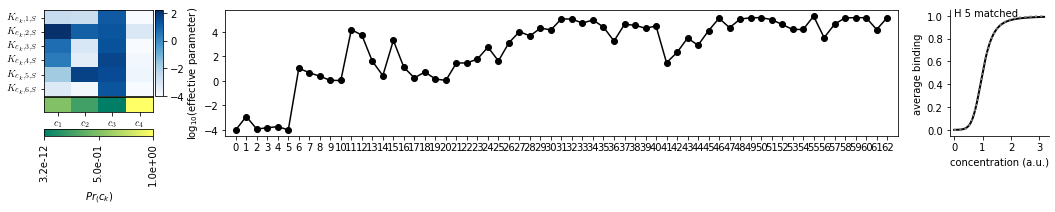

479 j=6
final_nt5_plim4_plimc6_c4_beta0.5_2533.out
error 1.9870869310821084
602.8193025818323,32.976543780268784,1.8576089742064337,0.0001613093663996583,0.0003754091706329663,0.001375411038471026,73.30843158420952,39.83473680915953,59.88780018789092,131.10942437479045,49.19761557245215,39.747908212284194,0.002624022074294774,0.17887680088116847,36.17556096458231,0.0015484661733223255,8.788422454765321,0.00037815405578827587,0.00010668214315645503,0.0002868950614607708,0.0019414990964284596,0.00027077798761795474,0.0005967470889800919,0.0005012665852942375,1.069118405353849e-06,0.0011093779929735482,662430.6319614836
0.9321891859550221 1.3426662046851219
function evaluated between 0.01 and 10.00


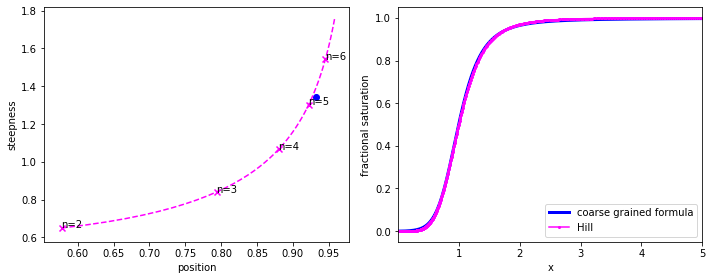

[6.02819303e+02 3.29765438e+01 1.85760897e+00 1.61309366e-04
 3.75409171e-04 1.37541104e-03]
[ 73.30843158  39.83473681  59.88780019 131.10942437  49.19761557
  39.74790821]
[2.62402207e-03 1.78876801e-01 3.61755610e+01 1.54846617e-03
 8.78842245e+00 3.78154056e-04]
[0.00010668 0.0002869  0.0019415  0.00027078 0.00059675 0.00050127]
[1.00000000e+00 1.06911841e-06 1.10937799e-03 6.62430632e+05]
effective parameters
0.0010166919418615123,0.0003366760440562704,0.0019443610698350632,0.00027077803610601835,0.0005967615512724822,0.0005012679688371021,87669.82450857048,855.2422732152048,0.6944929727040028,0.6776533139805784,2.5701064138564447,142.13658574474024,1.0326878875598624,0.9739797353142569,1.2729874726414394,1.023633213735161,1.4623749109785542,1.0064463677030775,1.0645397908898535,1.0619634652372634,1.0105431872768933,589282.2098079233,57029.820786455435,57789.99060037177,189825.643044305,2193.223639414038,570.8057434402472,2613.8460749278092,4364.075840873369,4208.786530658454,754.

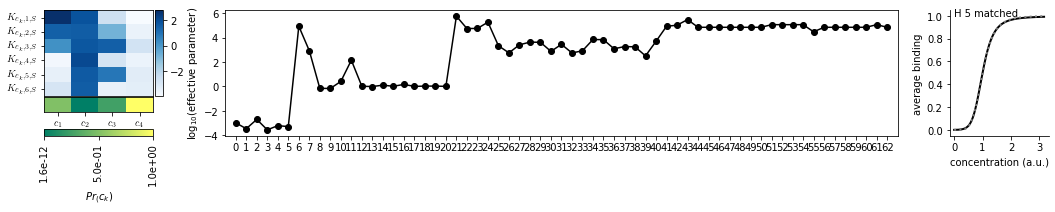

243 j=7
final_nt5_plim4_plimc6_c4_beta0.25_615.out
error 1.9886679733825008
0.00010720595560733834,0.010623890062689031,0.00018656208319547173,7.751417647538491,0.0007764100165873815,0.0031616942936911006,0.0001940216803015338,0.00019276063933039875,0.00013943266621481562,0.0018733026728953934,0.00038420271202857937,0.00011215141039617916,0.006898463929709085,0.0001876208929784161,245.96766711033843,48.060618313224225,203.29959022633147,0.028592142740222686,21.314172651182652,80.25902290010586,25.180963395515573,18.20688205355305,14.67549266430879,78.95517028716863,727820.5738469311,0.0028714757010800005,1.106700170500111e-06
0.9286529875739709 1.3411671516190258
function evaluated between 0.01 and 10.00


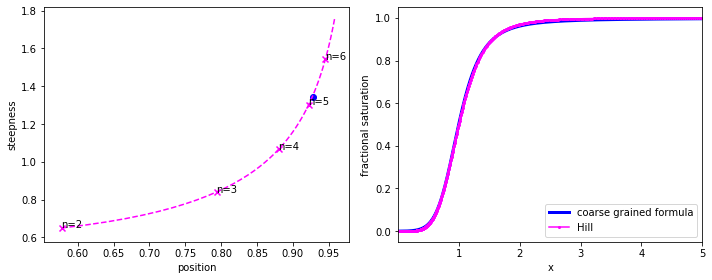

[1.07205956e-04 1.06238901e-02 1.86562083e-04 7.75141765e+00
 7.76410017e-04 3.16169429e-03]
[0.00019402 0.00019276 0.00013943 0.0018733  0.0003842  0.00011215]
[6.89846393e-03 1.87620893e-04 2.45967667e+02 4.80606183e+01
 2.03299590e+02 2.85921427e-02]
[21.31417265 80.2590229  25.1809634  18.20688205 14.67549266 78.95517029]
[1.00000000e+00 7.27820574e+05 2.87147570e-03 1.10670017e-06]
effective parameters
0.0001940216198802722,0.00019277509333597123,0.0001404031853621101,0.0018841398949058011,0.0003850053499237465,0.0001121558327740883,1.0695110002462453,1.2687903445354847,1.0025627209768586,1.0783546201371126,1.1176098393783591,1.1133778176736813,1.3119003321983496,1.0241502683279584,1.447682872526334,177.29962170825462,3650.6497466098886,2.9470808341551846,54.144698027439155,1.1895530705673678,1.5698535739397892,11203.715450234993,513.1487149889646,2589.4281000446877,33818.9799306433,36.993484288189414,35.85845396647848,7177.843726294336,36.05054774284401,956.9347208370916,2867.945

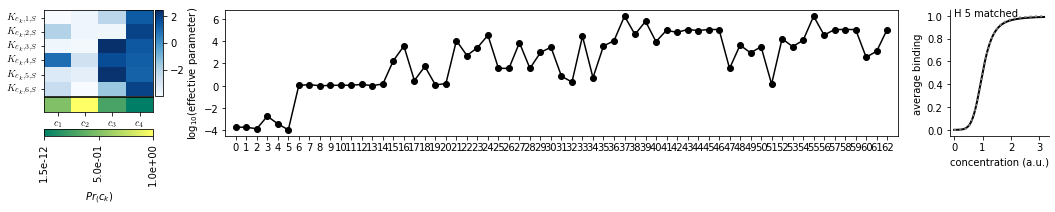

136 j=8
final_nt5_plim4_plimc6_c4_beta0.25_210.out
error 1.989648297509392
0.00022761259400879425,0.00026975273648903073,0.0003008941477118364,0.7455788640026711,1.7533570643098628,150.14713701222107,7.546810840975103,15.487148342448608,5.391648411246393,24.318113436509165,6.357977959541313,8.435183738156207,0.08214068712428864,0.028054252496060895,0.00012740593558962824,773.7486127642941,0.8319779049880267,0.052536081659923926,0.00012916535672313997,0.0003112911060389804,0.00037791108364239144,0.00012565771066895087,0.00013919776915489028,0.0002777922399034988,1e-06,3.67333850470415e-05,886873.2857952606
0.9316151383172117 1.3442055859156439
function evaluated between 0.01 and 10.00


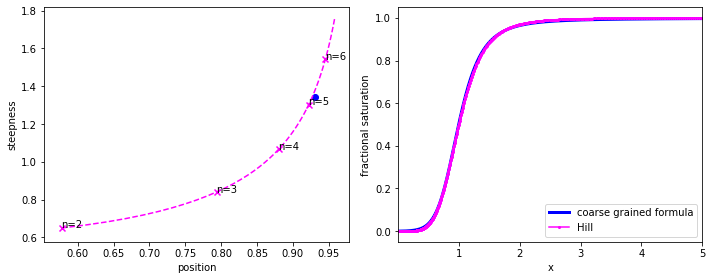

[2.27612594e-04 2.69752736e-04 3.00894148e-04 7.45578864e-01
 1.75335706e+00 1.50147137e+02]
[ 7.54681084 15.48714834  5.39164841 24.31811344  6.35797796  8.43518374]
[8.21406871e-02 2.80542525e-02 1.27405936e-04 7.73748613e+02
 8.31977905e-01 5.25360817e-02]
[0.00012917 0.00031129 0.00037791 0.00012566 0.0001392  0.00027779]
[1.00000000e+00 1.00000000e-06 3.67333850e-05 8.86873286e+05]
effective parameters
0.00012916547963399839,0.0003112910778135149,0.00037791100287010106,0.00012653032580476955,0.00014117466126760303,0.0004470911720892325,1.003279735595572,1.000939636969987,1.1785417033439705,1.0137945211340664,1.2898581202539323,1.000800296450847,1.0324678127209725,1.0006795332975136,0.9505297695552662,1.0015698140198803,0.9978705284544097,0.9231324348733347,84.9999550926187,2231.950352637913,4703.586892904187,47.723664722332686,625.1557421449747,148.5325463900523,66.31905955374366,181.41538850324932,43.42826881776611,20.458337383337017,19.59828675738155,1.8774503722143705,1.7739835

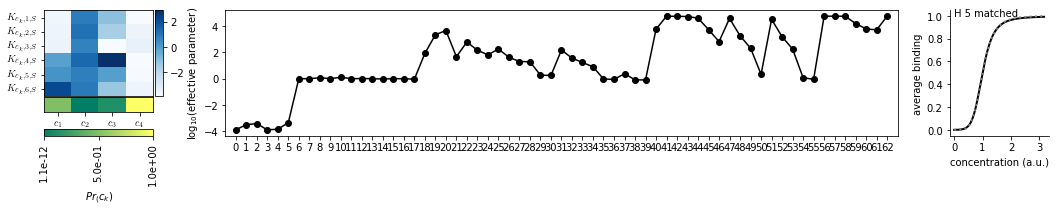

249 j=9
final_nt5_plim4_plimc6_c4_beta0.25_660.out
error 1.9903144896754017
0.00011112947876293185,0.0001968290528875904,0.00011629683617477569,3.093785923283047,24.44185382604151,1.9903664956702902,26.14703379741582,9.017216136616325,12.143785112718227,9.486265164779313,10.172426461972032,7.270500747898685,0.00011642357143342448,0.00018076045657933028,0.0001039393097884394,0.00011237615524005835,0.0001,0.0004863967295474604,24.74718805191673,22.58441281374535,0.00010215046293941743,0.017340491052368578,0.00016464646985731038,0.07711856377976689,1e-06,193027.9675162882,5.7101413526598e-06
0.9303420477275204 1.3435881139684662
function evaluated between 0.01 and 10.00


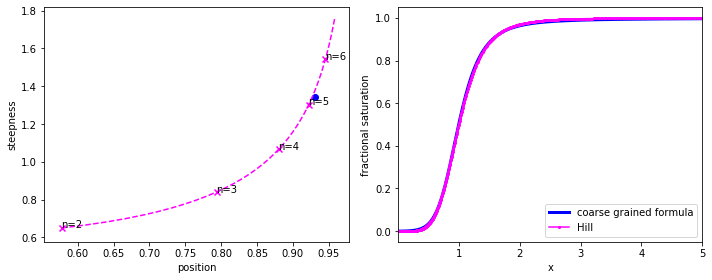

[1.11129479e-04 1.96829053e-04 1.16296836e-04 3.09378592e+00
 2.44418538e+01 1.99036650e+00]
[26.1470338   9.01721614 12.14378511  9.48626516 10.17242646  7.27050075]
[0.00011642 0.00018076 0.00010394 0.00011238 0.0001     0.0004864 ]
[2.47471881e+01 2.25844128e+01 1.02150463e-04 1.73404911e-02
 1.64646470e-04 7.71185638e-02]
[1.00000000e+00 1.00000000e-06 1.93027968e+05 5.71014135e-06]
effective parameters
0.00011642441152547825,0.0001807612546190806,0.00010393943671859741,0.00012840319600681253,0.00022662225940686857,0.000496705481814389,1.8436427491281235,1.1359325667846398,1.081121426026398,1.0268148653448108,1.0170552525838124,1.0301929681538562,1.030682834996327,1.061266841795869,1.0061974845879758,1.0595555046450882,1.0935969111294848,1.0113264538186002,13462.83512925739,501.0422883176368,2239.3792891332846,6584.02746643624,4264.142272753464,2456.3251452982863,966.5343038029782,9479.140573617226,5580.43683647665,1968.4406955499267,1.2411103918767576,3.4659639381553395,1.29589039

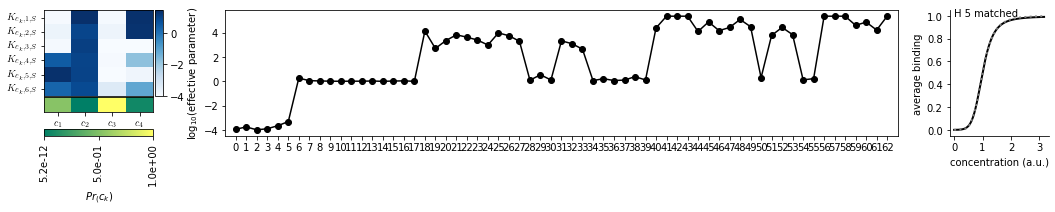

435 j=10
final_nt5_plim4_plimc6_c4_beta0.5_2182.out
error 1.9904949120239082
3.1292512963489747,0.0001596587936998898,0.008999563670462615,398.00170835528905,0.012749053331997925,14.73974019515778,109.45447611121347,0.0005728139605148479,0.00017955011786243292,0.6627184693241304,0.0001366185508966681,0.0016346200911183382,0.00011785545457762934,0.0004460549230819147,0.00010829841091730378,0.0014148641136349247,0.0001504024424453599,0.0009232263585020155,81.52914120104148,22.86004439020933,55.35012203449151,47.34697737526315,31.108862468794335,106.65086397257491,3.268049087370681e-05,446326.20596336416,1e-06
0.9310696688039205 1.3461598293094927
function evaluated between 0.01 and 10.00


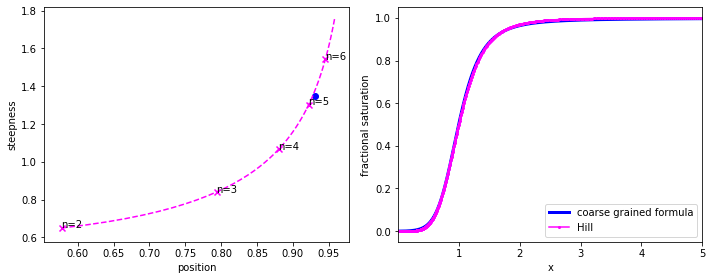

[3.12925130e+00 1.59658794e-04 8.99956367e-03 3.98001708e+02
 1.27490533e-02 1.47397402e+01]
[1.09454476e+02 5.72813961e-04 1.79550118e-04 6.62718469e-01
 1.36618551e-04 1.63462009e-03]
[0.00011786 0.00044605 0.0001083  0.00141486 0.0001504  0.00092323]
[ 81.5291412   22.86004439  55.35012203  47.34697738  31.10886247
 106.65086397]
[1.00000000e+00 3.26804909e-05 4.46326206e+05 1.00000000e-06]
effective parameters
0.00012487450237480652,0.0004460543326352985,0.00010831845589211509,0.0023065873989304656,0.00015043073953095417,0.0009562490455440558,1.0389369912187758,6.355996943163538,9688.498028580227,6.004506414312494,866.5048083915525,1.0585555186311346,0.7541358351817312,1.0236245610974306,0.990633499669675,32.75716606359069,1.2521620730655936,3.9623314700066232,33.3872550423017,5959.694622596214,3.94385120026181,36191.547484838724,6639.509146233008,15148.025490167342,8753.868985886564,25040.44771550743,123765.84482892374,39186.977082102814,24777.724858983922,25057.219616105886,27152

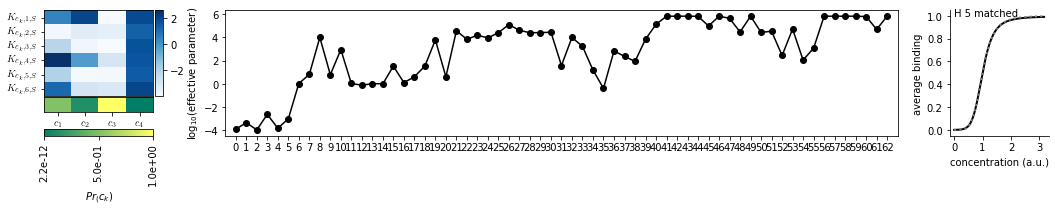

52 j=11
final_nt5_plim4_plimc6_c4_beta0.25_1416.out
error 1.9905292172263085
0.00010703323819030631,38.31564949037587,0.00012691765789606376,0.016224928135213302,0.00010769798962588112,0.000931764217734561,0.0016360083627515016,0.0001054310435541804,12.123239878930828,2007.9637380373285,307.46157647357467,0.014245636090900918,79.2291940194277,51.40632104867795,78.8867768518629,81.38723292615549,65.85110083143792,73.9769003782408,0.001303776157740583,0.00012295082109904117,0.0008990644767265509,0.0005519518749327851,0.0013705334235804903,0.00026842289869916374,0.0035296936722603338,1e-06,91838.5372850755
0.9297384777740852 1.3450966233148502
function evaluated between 0.01 and 10.00


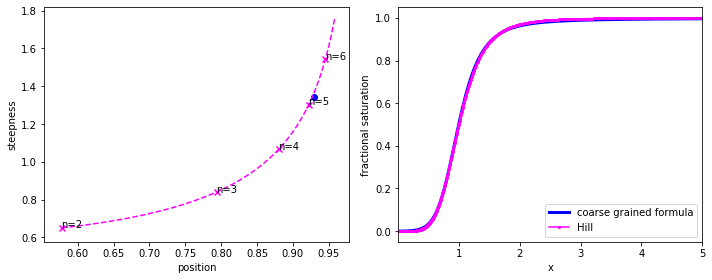

[1.07033238e-04 3.83156495e+01 1.26917658e-04 1.62249281e-02
 1.07697990e-04 9.31764218e-04]
[1.63600836e-03 1.05431044e-04 1.21232399e+01 2.00796374e+03
 3.07461576e+02 1.42456361e-02]
[79.22919402 51.40632105 78.88677685 81.38723293 65.85110083 73.97690038]
[0.00130378 0.00012295 0.00089906 0.00055195 0.00137053 0.00026842]
[1.00000000e+00 3.52969367e-03 1.00000000e-06 9.18385373e+04]
effective parameters
0.0013037640023841701,0.0005401521435748881,0.0008995228292874503,0.0006292960041815142,0.0013823370905854217,0.0002684314642170764,0.3540044701396897,1.0581684184211477,1.11657744781072,1.0337077816368556,1.1823278136567859,0.427462392213557,20.27158724254841,0.3368861682434618,3.1942350678891396,1653.778897165467,116.24657615511322,1.2901052980775218,27277.21373549568,7.774258918218784,1.5880331043147278,12920.21328487133,401.85551864147965,8905.464063007428,5433.3040551997365,5.792688917754822,25.03247962537667,12396.931446757564,1.4042773178089245,3034.7860108709215,5471.2530757

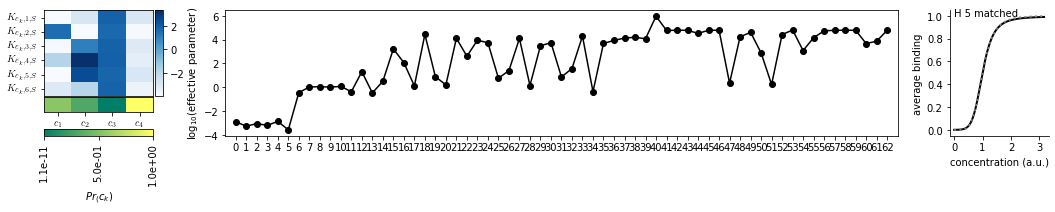

83 j=12
final_nt5_plim4_plimc6_c4_beta0.25_1668.out
error 1.9908522288143098
0.01922923301822164,0.006136501825146163,0.2994872592404758,0.0684710516460916,2663.3328140741323,0.0001,16.516659002175956,154.79674257628173,25.3860772956842,78.41861191441218,49.46528707369425,38.24611726445419,0.0004647168770324912,23.111337009959946,0.00158217712704794,0.00042376730241396683,56.921864391969095,4393.742365986666,0.00010911499964066172,0.0013515490893368412,0.0018179083149435081,0.00010235765889332115,0.0005740002896617129,0.0010594717167953529,1.0030539272369336e-06,0.004260527071820588,934027.853023632
0.9302048142008752 1.3420087857229888
function evaluated between 0.01 and 10.00


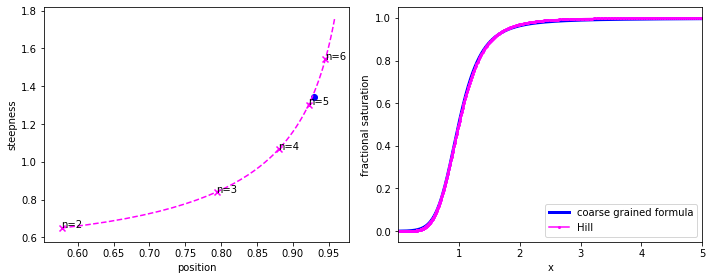

[1.92292330e-02 6.13650183e-03 2.99487259e-01 6.84710516e-02
 2.66333281e+03 1.00000000e-04]
[ 16.516659   154.79674258  25.3860773   78.41861191  49.46528707
  38.24611726]
[4.64716877e-04 2.31113370e+01 1.58217713e-03 4.23767302e-04
 5.69218644e+01 4.39374237e+03]
[0.00010911 0.00135155 0.00181791 0.00010236 0.000574   0.00105947]
[1.00000000e+00 1.00305393e-06 4.26052707e-03 9.34027853e+05]
effective parameters
0.00010913548958581807,0.0013516597935605272,0.0018182270350837327,0.0001024309421980304,0.003425705334546741,0.0010795125672756363,1.0195307501395798,1.0329768727236188,1.2496200595650808,146.82999959934415,1.0660810938975889,1.002327368905509,1.0969291055846628,5.244201451599575,318.4300568557757,1.1284687468014873,137.27031230938252,0.9979651076066035,556.584555712266,1.0867343787402588,308.7306394415562,260.40840358908423,12991.879082599422,179.2986193092664,6.318969954560462,1558.7427961171986,176.22048691547437,81.61350613239439,179.36736261130793,4057.648017027585,4.56

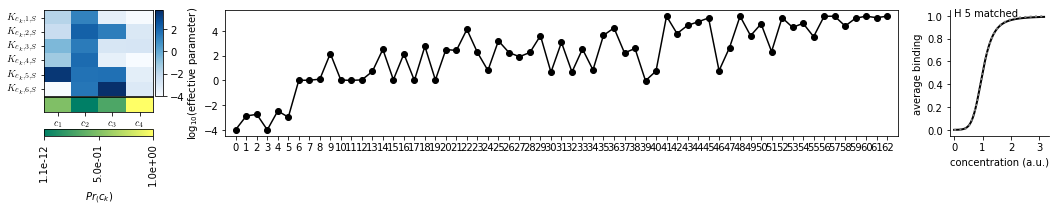

69 j=13
final_nt5_plim4_plimc6_c4_beta0.25_156.out
error 1.9910131755990923
1.3001428262594141,0.00035515197174341187,118.79949068122092,0.0014595592641708309,13.394145411281887,0.00021928207441988863,30.970020402754585,29.232361243683126,21.59529277767847,19.645775762819888,28.10632631976757,39.35758295732392,0.00010405307832609259,0.00013554043734195412,0.00010678733095827926,0.0003407455700161894,0.0003864832946485508,0.00017129875226110132,0.021278534710107207,0.0005778124058590057,0.00014207871450844977,0.002020989781937763,0.000122817822478285,2.2074248357795723,1e-06,243139.4392678728,1e-06
0.9320260018695627 1.3513323639061996
function evaluated between 0.01 and 10.00


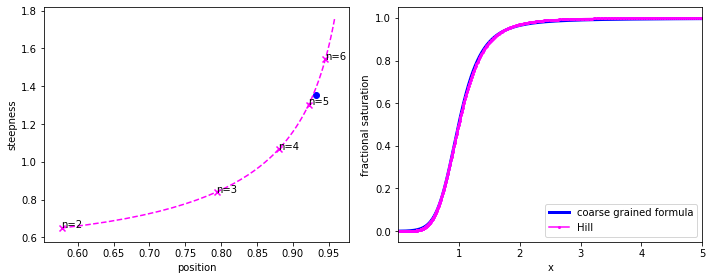

[1.30014283e+00 3.55151972e-04 1.18799491e+02 1.45955926e-03
 1.33941454e+01 2.19282074e-04]
[30.9700204  29.23236124 21.59529278 19.64577576 28.10632632 39.35758296]
[0.00010405 0.00013554 0.00010679 0.00034075 0.00038648 0.0001713 ]
[2.12785347e-02 5.77812406e-04 1.42078715e-04 2.02098978e-03
 1.22817822e-04 2.20742484e+00]
[1.00000000e+00 1.00000000e-06 2.43139439e+05 1.00000000e-06]
effective parameters
0.00010940006942381333,0.00013554146080067256,0.0005953913897724129,0.00034075025233400055,0.00044156992307565926,0.00017129912055848374,1.3302933351092856,9752.989916654838,1.2275987381128828,1483.5331994399962,1.2812084830523227,2.3618167294787793,1.051161557852028,1.2585868656194914,1.2038019178290464,3.7030758075104537,24892.772010802437,1.264146416589857,1.4246979973430716,1.0544843656148033,1.0950912144041036,14676.277263462587,13774.217737030345,15786.636309881962,47927.5336809025,11938.637513923253,11884.324681787346,17551.452775708312,7457.151529363172,14627.400870604355,17

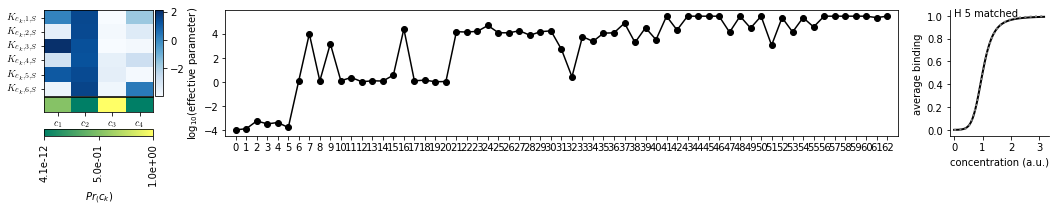

450 j=14
final_nt5_plim4_plimc6_c4_beta0.5_2290.out
error 1.9911749142729316
0.0026272076807327843,1.0500880749715882,0.028208569458269377,8.606381947198644,0.0001358562767023515,0.0002103943140612736,12.726314600242123,22.91783391738358,20.52857630145174,22.229774130660928,40.07424154525066,14.065872178883037,21.276995825692357,0.0001513572093639125,27.26013394817675,40.879688732961945,0.00010301831187956096,0.00010925520695137154,0.0004917507766314008,0.00020201370645903831,0.0012658117343063394,0.00013620224919446664,0.0006728795927356016,0.0001120065563457888,1.273003834150871e-06,0.04977988243548774,206128.4369125522
0.9294143137972749 1.3410667436082808
function evaluated between 0.01 and 10.00


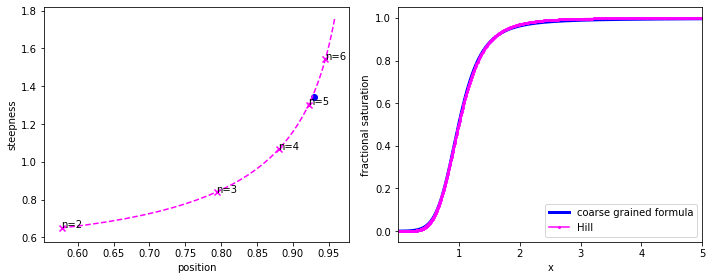

[2.62720768e-03 1.05008807e+00 2.82085695e-02 8.60638195e+00
 1.35856277e-04 2.10394314e-04]
[12.7263146  22.91783392 20.5285763  22.22977413 40.07424155 14.06587218]
[2.12769958e+01 1.51357209e-04 2.72601339e+01 4.08796887e+01
 1.03018312e-04 1.09255207e-04]
[0.00049175 0.00020201 0.00126581 0.0001362  0.00067288 0.00011201]
[1.00000000e+00 1.27300383e-06 4.97798824e-02 2.06128437e+05]
effective parameters
0.0004968994506296525,0.00020710716848945624,0.0012725255342697665,0.00018782636922233078,0.0006728770973277621,0.00011200711985838643,1.120406572433029,222.509610229251,2252.554351454746,1.0006454537203913,1.0196263254425053,1.5303225623866725,1127.906042208938,1.0210719277706377,1.1074209643702877,1131.6292478825628,1.0014699308051385,1.01247356945982,0.8216083993694652,1.2857545338492198,1.046184634183776,292.8071056464334,8.578800954258723,1021.8538676142393,1985.8701571175015,42605.61426852364,186.59127252293777,530.8759324192049,1777.5140623157602,3538.0880468855494,1131.69585

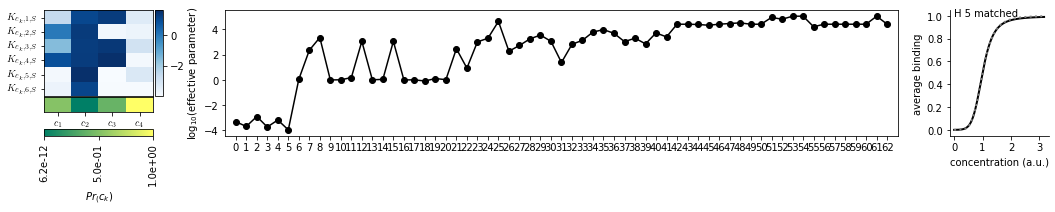

202 j=15
final_nt5_plim4_plimc6_c4_beta0.25_291.out
error 1.9912325549504832
0.00011140003532125082,32.45987647223319,0.000438441652893534,0.02483641973912687,0.00011780648735451889,0.0001,0.0001,0.0001,0.00010641601287628831,0.0001,0.00010697617207245287,0.0001,1.1518024353972776,0.3646186271054235,0.00015680853429151916,0.004014764243592798,0.0004666671292770506,18.77071948022611,5.87984363847638,5.30130070031379,6.281764110921952,8.434648055179146,6.768366437079521,3.898321492551749,852732.4188433816,6.179353869694596,1.375660220691559e-06
0.9312140364033074 1.3419508676596383
function evaluated between 0.01 and 10.00


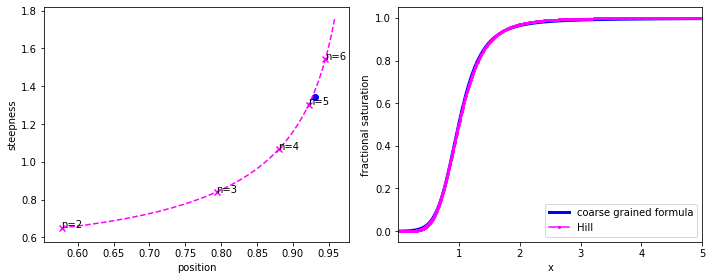

[1.11400035e-04 3.24598765e+01 4.38441653e-04 2.48364197e-02
 1.17806487e-04 1.00000000e-04]
[0.0001     0.0001     0.00010642 0.0001     0.00010698 0.0001    ]
[1.15180244e+00 3.64618627e-01 1.56808534e-04 4.01476424e-03
 4.66667129e-04 1.87707195e+01]
[5.87984364 5.3013007  6.28176411 8.43464806 6.76836644 3.89832149]
[1.00000000e+00 8.52732419e+05 6.17935387e+00 1.37566022e-06]
effective parameters
0.00010834580263952504,0.00014070676842871125,0.00010641677754148062,0.00010005739001272175,0.00010697880218234062,0.0002360207802350828,200.56307841222338,1.0416439287424624,4.021144376962934,1.264529138313873,6127.044528509374,1.8565398225705632,68.62029973067351,1.0943454785330018,1493.8340333426142,1.0090661420743137,1.00603664601101,1.2744733461489006,1.0095863318457903,23.550092900087055,2.939372682566204,264.29080894528886,121.79574104408753,987.3183577176776,10627.869892062825,437.1650259084301,326.41628744241575,7150.850138550739,476.7667431336076,10443.773729783594,9123.64759858

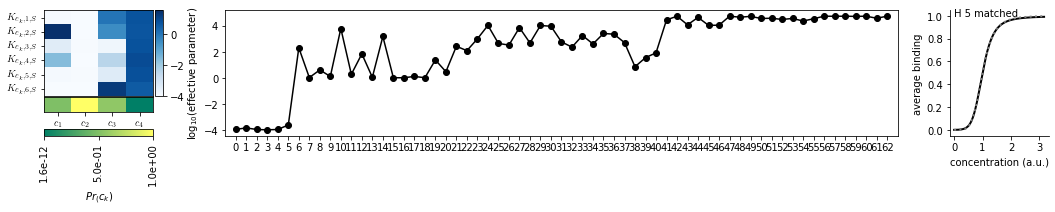

3 j=16
final_nt5_plim4_plimc6_c4_beta0.25_1020.out
error 1.991313136185723
54.79696971595907,45.98282092536988,0.00011509729449040279,0.00024829376868983885,10.600142836893458,0.0340817709548594,0.0011907153492376381,0.003543090591553761,0.0001,0.0019209036546422753,0.0017206441947344,0.00015624097337725175,56.22572626048017,55.722614271039234,68.2336937523402,34.30370196168995,97.43729719099592,48.59044777633514,153.03351876078773,0.0010240509259711432,230.6413686847062,0.0029168494781943973,0.027114808386448683,2.2041714399463284,346891.97419796133,1.0822728471680861e-06,1.3183537305835617e-06
0.9305844016668943 1.3478279368866921
function evaluated between 0.01 and 10.00


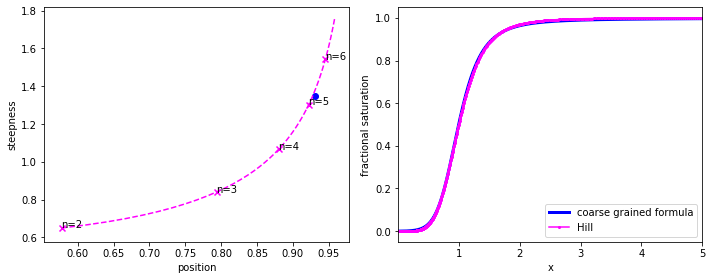

[5.47969697e+01 4.59828209e+01 1.15097294e-04 2.48293769e-04
 1.06001428e+01 3.40817710e-02]
[0.00119072 0.00354309 0.0001     0.0019209  0.00172064 0.00015624]
[56.22572626 55.72261427 68.23369375 34.30370196 97.43729719 48.59044778]
[1.53033519e+02 1.02405093e-03 2.30641369e+02 2.91684948e-03
 2.71148084e-02 2.20417144e+00]
[1.00000000e+00 3.46891974e+05 1.08227285e-06 1.31835373e-06]
effective parameters
0.0013486777344025476,0.003675636770215016,0.0001000011329472388,0.0019208989399757694,0.0017511969255946524,0.00015633893161259691,1466.1169897384955,2.1010163923098353,0.9003387376621673,709.8475279717914,26.46217929716112,1.037708224085735,0.9694450313223735,219.24498283027046,8.83984254240006,1.0380184429452441,1.1212059588897163,1.7852979525687582,0.9879083519947877,1.0167708629102783,4.839851166146344,2922.8041418480134,232.56899688941198,40454.64128527131,36204.28252340351,1529.1622123155423,5146.49515553123,23321.622113271344,224.4622039862564,714.1341749445751,32398.8848764

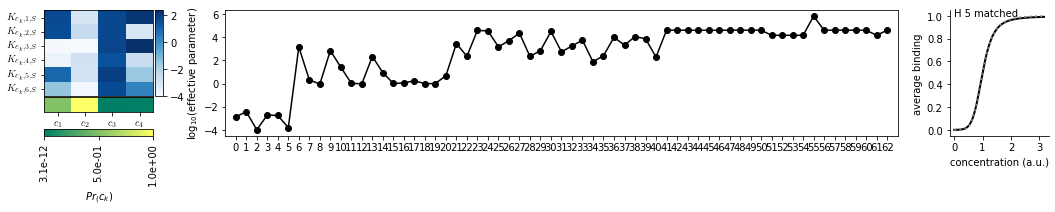

100 j=17
final_nt5_plim4_plimc6_c4_beta0.25_1812.out
error 1.9919388877680577
0.003973131774689914,31.33870916183082,0.0014415082221502016,7.395186594702052,36.03799471523787,0.01492255296122952,0.00035010365331798407,0.00011928447580102009,0.00011568085072675588,0.0031758062008026564,0.0005355692465460806,0.0004710346254112213,1.113465324617344,97.12358993183481,0.00011823438392954702,0.0006790297342510387,406.5298226076838,0.00016721218201936532,44.00721677504962,42.776038490564815,32.15825987524488,26.960064629445874,46.84962974411969,38.12759021546706,295038.8696486485,1.0028365436209284e-06,1.506199728546645e-06
0.9305408582987688 1.3494228267942243
function evaluated between 0.01 and 10.00


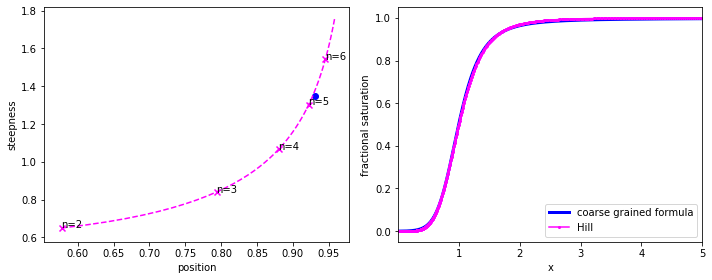

[3.97313177e-03 3.13387092e+01 1.44150822e-03 7.39518659e+00
 3.60379947e+01 1.49225530e-02]
[0.0003501  0.00011928 0.00011568 0.00317581 0.00053557 0.00047103]
[1.11346532e+00 9.71235899e+01 1.18234384e-04 6.79029734e-04
 4.06529823e+02 1.67212182e-04]
[44.00721678 42.77603849 32.15825988 26.96006463 46.84962974 38.12759022]
[1.00000000e+00 2.95038870e+05 1.00283654e-06 1.50619973e-06]
effective parameters
0.00035011616155129164,0.0002255031768276038,0.00011568550861914058,0.0032008606159811747,0.0006577152379848615,0.0004710838016296925,6.00058157094393,1.1787721071248172,1.0864017542083733,2.9741207678973747,1.0530092500721415,6.667435828780288,1088.7865677190985,25810.36105223212,15.528111141222613,1.1016573733590493,3.2294279172212246,1.1160465735478828,429.87724900318193,1.2436000317664044,6.726470844578843,5084.838128906114,12.284580583279965,11.794850481347178,645.3688950185078,1365.6557794412718,3942.7073246945383,12936.49372700512,12.224066600393943,354.8064811251704,560.0120

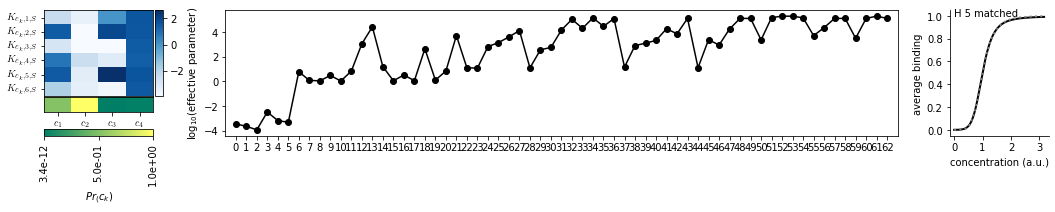

141 j=18
final_nt5_plim4_plimc6_c4_beta0.25_2136.out
error 1.9921446808951335
0.010174019854417595,0.0005799974897564936,32.6497776240532,19.70549601774384,297.67038599089,0.00041377897544793007,129.00904382039832,155.09079383305817,177.5579134998546,72.86491363291377,52.588153089816956,104.870054684633,0.0021178486146896216,0.002022763074451406,0.0011202841653264461,0.007683817551417339,0.0031147406389438704,0.0006557772153092859,0.0014388079204077932,695.4904321173091,0.0003551555114262633,684.9884919897676,0.00016794331402411667,0.011630386297742103,1.0678097903121654e-06,402235.17760375416,0.0005794184352776281
0.9306373613440669 1.3435823339367936
function evaluated between 0.01 and 10.00


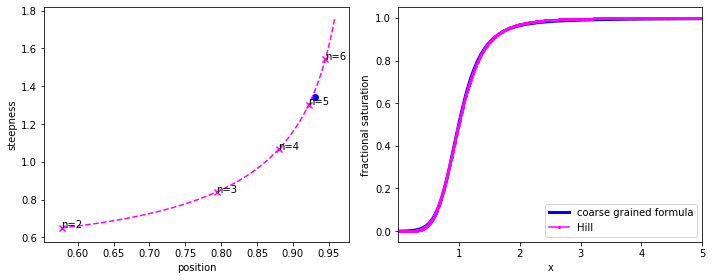

[1.01740199e-02 5.79997490e-04 3.26497776e+01 1.97054960e+01
 2.97670386e+02 4.13778975e-04]
[129.00904382 155.09079383 177.5579135   72.86491363  52.58815309
 104.87005468]
[0.00211785 0.00202276 0.00112028 0.00768382 0.00311474 0.00065578]
[1.43880792e-03 6.95490432e+02 3.55155511e-04 6.84988492e+02
 1.67943314e-04 1.16303863e-02]
[1.00000000e+00 1.06780979e-06 4.02235178e+05 5.79418435e-04]
effective parameters
0.002117868984644126,0.002023761745549164,0.0012014525143318054,0.0077337752170769354,0.0038547718490586835,0.0006557769078810016,1.0122267098346274,1.2808817716606267,1.0255689772211312,1.732469732219959,1.0258559572456478,0.9815535742417156,44.84325502455712,0.8654385376061803,1.0408184845285104,173.0727322860589,5217.862124182858,1.0378081481083856,489.96394926909284,1.0037977976231511,0.9349465766542695,1866.9079168042222,3.2902998560453236,196.58863810917506,1905.0269950845639,6.0843946716824915,4.865823924761631,3683.6195311623464,4.840080261130853,243.73284223458825,37

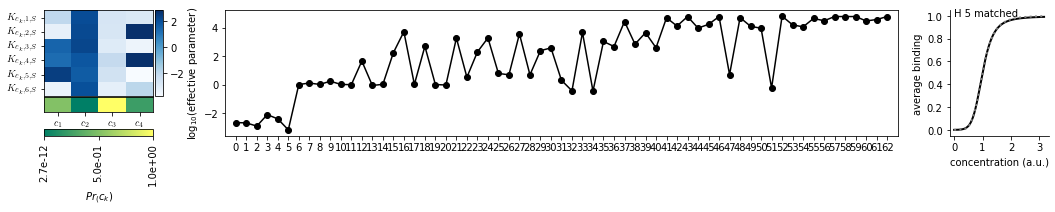

267 j=19
final_nt5_plim4_plimc6_c4_beta0.25_813.out
error 1.992425602500694
0.012206002782683585,0.013705607621220008,46.530029209004276,0.014377006397508446,120.35227110286468,0.9192616610833558,0.00013558540490891342,0.00016484501341028644,0.00012970732349109698,0.00025766395233588294,0.0001,0.0005674714075910802,38.60374692657946,59.44362675352902,25.435428168045078,17.683178415134872,48.844262149033355,22.66010832233571,0.00019174821177101017,0.24732693036774767,0.0004979601648589285,0.0015751245770419633,46.626525019646486,0.17780065058061548,686166.6129504134,1e-06,0.12429660198747197
0.9315022993479034 1.34525920458046
function evaluated between 0.01 and 10.00


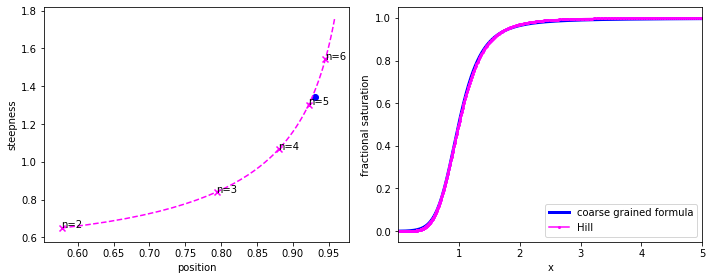

[1.22060028e-02 1.37056076e-02 4.65300292e+01 1.43770064e-02
 1.20352271e+02 9.19261661e-01]
[0.00013559 0.00016485 0.00012971 0.00025766 0.0001     0.00056747]
[38.60374693 59.44362675 25.43542817 17.68317842 48.84426215 22.66010832]
[1.91748212e-04 2.47326930e-01 4.97960165e-04 1.57512458e-03
 4.66265250e+01 1.77800651e-01]
[1.00000000e+00 6.86166613e+05 1.00000000e-06 1.24296602e-01]
effective parameters
0.000135603062401648,0.00016490960638225732,0.0001975186882401479,0.0002576847938597094,0.0002838438610444263,0.0005688424226943554,1.1603140665027878,31.612894146966187,1.0355787712201798,56.087968957002296,1.226058227696134,29.25774218836304,1.0439938412243717,96.42728834182323,1.2987766065846702,19.824173992034048,145569.58131165575,555.4698166535766,35.02795591779845,1.1332378766883204,1008.2625500628345,746.0375572475689,9831.748032566064,315.4827506521852,4601.381573107973,271.9485065553157,90.0756871885677,93.7380352091851,228.4819142323951,1012.1241598986186,91.9842453362059

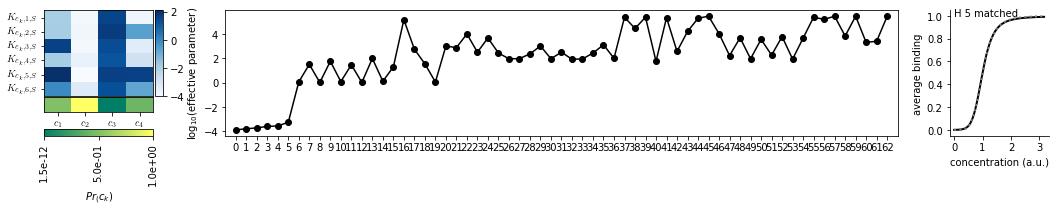

44 j=20
final_nt5_plim4_plimc6_c4_beta0.25_1353.out
error 1.992518558131492
564.3331329519161,15.71309524886024,0.011549297080637635,4.80312543777659,0.03112532884253694,0.04598331680041731,64.99780587337752,111.67715108734937,100.10624564290701,43.269411525489794,48.215312675105444,24.676425811844236,0.10076156619359887,0.866811637831866,0.5779696720788727,0.02173679449029413,29.33971479042365,0.000752066226877137,0.00019427541755164047,0.000398512388402953,0.0022640464263400137,0.00012621361150553457,0.0017344730739159272,0.00010632150295713597,1.1199014779179504e-06,0.0019986089756500866,1000000.0
0.9303881512235856 1.3474365075778552
function evaluated between 0.01 and 10.00


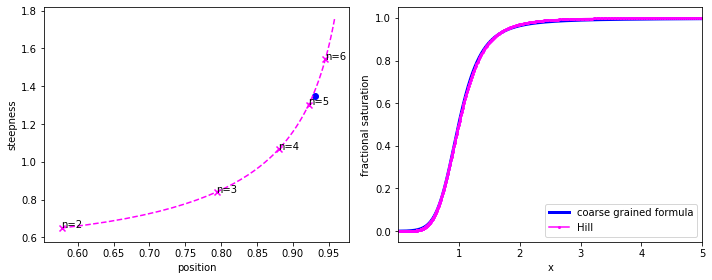

[5.64333133e+02 1.57130952e+01 1.15492971e-02 4.80312544e+00
 3.11253288e-02 4.59833168e-02]
[ 64.99780587 111.67715109 100.10624564  43.26941153  48.21531268
  24.67642581]
[1.00761566e-01 8.66811638e-01 5.77969672e-01 2.17367945e-02
 2.93397148e+01 7.52066227e-04]
[0.00019428 0.00039851 0.00226405 0.00012621 0.00173447 0.00010632]
[1.00000000e+00 1.11990148e-06 1.99860898e-03 1.00000000e+06]
effective parameters
0.000758608064552591,0.0004142269260814717,0.0022640569742971265,0.0001310166975654462,0.001734561153828687,0.00010636740883207362,28219.237476156817,4.055177033802692,27272.149769853662,13.612031561393204,321.8733091346984,1.1699796717335427,1391.6849576634413,1.7218350633075763,17.43062087658142,1.16678256160361,1.0100415198779298,1.0132591648342983,1.6370209305136914,16.897243916479983,1.014734925647338,124013.62696974663,743363.1183543479,294508.897580799,700218.4405856726,120433.20383821428,185.56471317584356,2590.6675499652224,299479.39199901046,698170.5343199272,6297.0

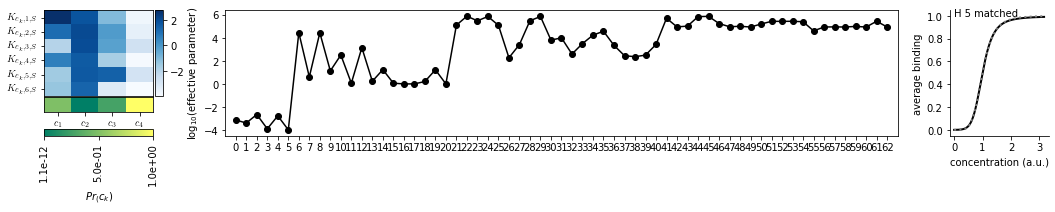

229 j=21
final_nt5_plim4_plimc6_c4_beta0.25_498.out
error 1.9927266631813008
0.002333197186790102,0.32606045553505864,0.0017041547764066517,2.81839345224347,166.55094829047732,0.0008694274269270849,0.0025811091908746284,0.00021068565777835637,0.000798687409787301,0.02446034037952462,7.62608948305182,0.5069402567836157,4.757668564639066,11.14243820282659,12.124803081046421,6.832583822265443,9.58004035578567,12.09242028438481,0.00017001413547310134,0.00011872444787201353,0.00014409383917685935,0.00012179155813364416,0.0001173214352523276,0.00010146136882391102,2.389554605743034e-05,1.2290597770965214e-06,918079.1252102356
0.9319585904380354 1.3449360930067071
function evaluated between 0.01 and 10.00


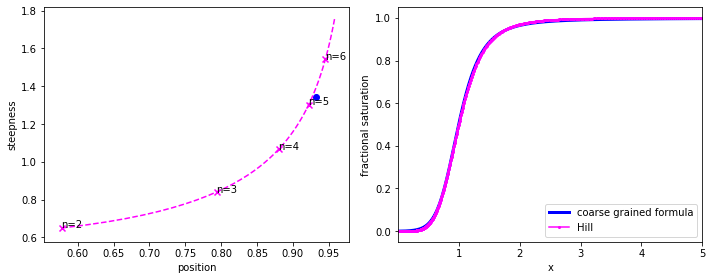

[2.33319719e-03 3.26060456e-01 1.70415478e-03 2.81839345e+00
 1.66550948e+02 8.69427427e-04]
[2.58110919e-03 2.10685658e-04 7.98687410e-04 2.44603404e-02
 7.62608948e+00 5.06940257e-01]
[ 4.75766856 11.1424382  12.12480308  6.83258382  9.58004036 12.09242028]
[0.00017001 0.00011872 0.00014409 0.00012179 0.00011732 0.00010146]
[1.00000000e+00 2.38955461e-05 1.22905978e-06 9.18079125e+05]
effective parameters
0.00017001649810775187,0.00011907948815542864,0.0001440955546899899,0.00012486131268153833,0.0002987337329288642,0.0001014622346954278,1.0414388557202614,1.003302136028376,1.314856696106174,8.727726287903876,1.004571366826906,1.042818697154924,68.30094181708193,1663.208647749918,1.0374955472930583,1.2723375311512817,7.578262575577319,1.0135149179883585,13707.813856149742,1.1948410507276543,5.604848790115865,284.2688917577406,16.34928418532544,13.787917857755978,403.9802435131478,139.47622135361138,26.396761450934054,371.66741759345655,13.727795484216614,207.71663058293763,38.3662171

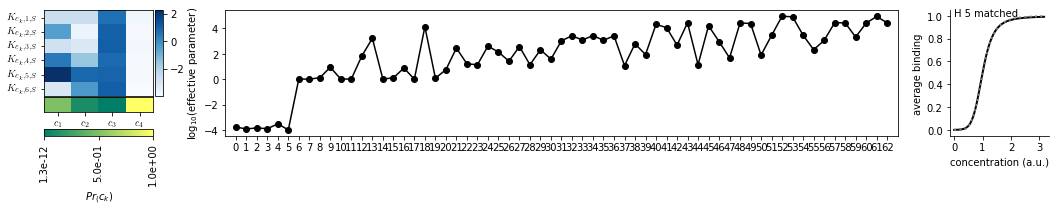

128 j=22
final_nt5_plim4_plimc6_c4_beta0.25_2037.out
error 1.9930560194925495
0.0032133335126370314,30.741631226329066,3.3157558377757823,0.00011207944344011558,41.69542597491749,0.0001179240188733807,0.0002483873982519442,0.00012172336406316663,0.00013303312780149737,0.0001958820278050356,0.0001,0.0012691696149536274,1.2825538322686547,0.0002971600519124166,4.92943212662308,0.00021427716622867576,0.00010176266672915267,0.0008292006919671461,24.044807610588613,20.119274635700346,27.44123728727209,16.50272579831127,14.45625908991606,27.113590257536636,685085.233680693,6.816898227061851,5.1064958018800745e-06
0.9299671455341784 1.3428023005832217
function evaluated between 0.01 and 10.00


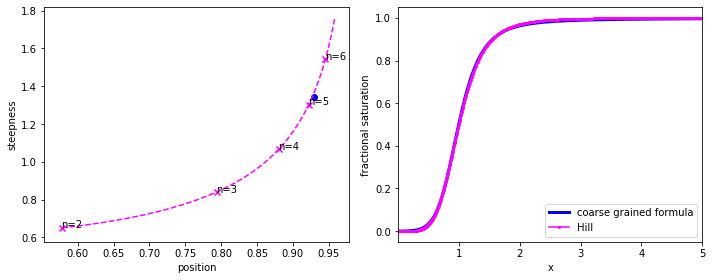

[3.21333351e-03 3.07416312e+01 3.31575584e+00 1.12079443e-04
 4.16954260e+01 1.17924019e-04]
[0.00024839 0.00012172 0.00013303 0.00019588 0.0001     0.00126917]
[1.28255383e+00 2.97160052e-04 4.92943213e+00 2.14277166e-04
 1.01762667e-04 8.29200692e-04]
[24.04480761 20.11927464 27.44123729 16.5027258  14.45625909 27.11359026]
[1.00000000e+00 6.85085234e+05 6.81689823e+00 5.10649580e-06]
effective parameters
0.00026115126067295327,0.0001665972803131909,0.00018692112615758231,0.00019588221152504532,0.0001608609469554661,0.0012691637587856077,4.179127915156374,1289.8182119648898,1.0623978342743658,5.3391990315264835,0.9977084641217134,4778.9821084842815,0.9606047002311667,69815.29249875633,0.7749074959308824,1.1057520983336229,6712.095373762614,0.9089274175493257,0.8945686571924294,1.0134148504593783,0.6711189375889602,15.328703599623108,7271.601207777919,12.411088945944984,2286.264060400378,8951.975361887658,13.773667919833516,3295.155407910044,5812.0548334106315,1219.8093030231742,1964.

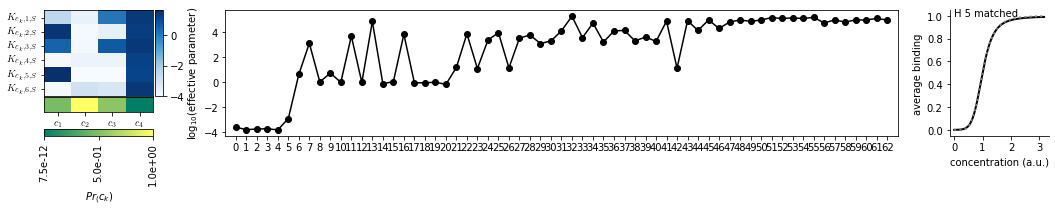

79 j=23
final_nt5_plim4_plimc6_c4_beta0.25_1641.out
error 1.9931937604070646
0.0005785822083573071,137.68098209501127,28.98546570682703,0.0029317705347360317,1.3725761312461155,0.02655625740745075,0.07115127614138653,0.07330756647989256,0.0001804811924366782,1.837757013119323,0.00020744842356397726,0.03254057871145257,29.023461754909835,38.560833866627476,26.883853864098423,19.779587548758375,35.09529609071458,88.3151541236792,0.00010277151780785634,0.00010798202107059626,0.00012435001058796062,0.0001,0.00014606024757339827,0.00010795655037163666,5.63831161716054,1.1226047666966537e-06,378177.2933645745
0.9312377081711974 1.3466809998154123
function evaluated between 0.01 and 10.00


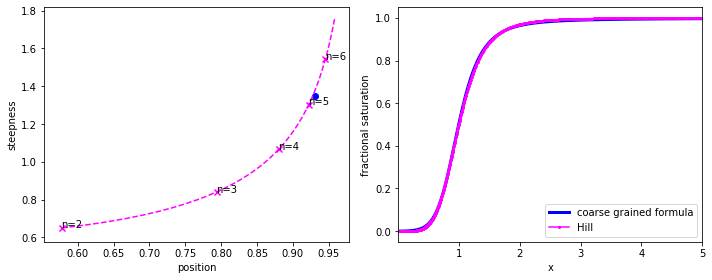

[5.78582208e-04 1.37680982e+02 2.89854657e+01 2.93177053e-03
 1.37257613e+00 2.65562574e-02]
[7.11512761e-02 7.33075665e-02 1.80481192e-04 1.83775701e+00
 2.07448424e-04 3.25405787e-02]
[29.02346175 38.56083387 26.88385386 19.77958755 35.09529609 88.31515412]
[0.00010277 0.00010798 0.00012435 0.0001     0.00014606 0.00010796]
[1.00000000e+00 5.63831162e+00 1.12260477e-06 3.78177293e+05]
effective parameters
0.00010383211813445863,0.0004731314309262717,0.00020099443038960915,0.00012740501642822882,0.00014969026852261843,0.00010851028271326707,6.164137020471159,2.8573399690398436,148.27244643450578,1.3095644000563826,4.72737320603077,110965.00306160646,51.24391897728424,7055.85021868716,189.4317602189867,9.515121495449089,3497.217127525925,94.26576531593412,1.7298647328311327,65.66226650705798,7.47721518799825,5.653803866553628,652.3838399620658,7.819450224113474,298.59424974376293,1829.8740551310375,13.011497506770798,963.7587882802526,17579.128413237893,2269.736635181949,21180.00574152

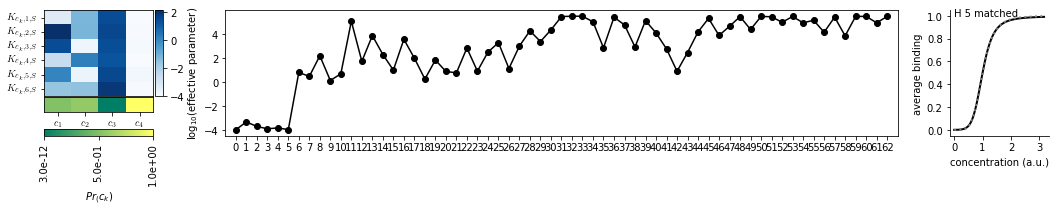

105 j=24
final_nt5_plim4_plimc6_c4_beta0.25_1848.out
error 1.9933446970228255
0.0013790715540256653,0.0010923680661591127,48.2309527475203,8.649521306136977,10.541782239883686,0.016357304472753957,0.00019456178778716297,0.00037917337814813044,0.0010024877430012283,0.0003608143380276883,0.0001,0.000850444128362274,35.53325922462445,38.914453638985634,29.082040025060024,44.96148839735652,47.96895753863683,29.819584860835455,59.90339791025032,2.782958966455143,0.00010858525349910282,79.98112889016855,6.749683932440859,0.025027500417887222,138184.78117286146,1.0170923466006086e-06,3.7964563756917894e-06
0.9302879672642179 1.347930635663298
function evaluated between 0.01 and 10.00


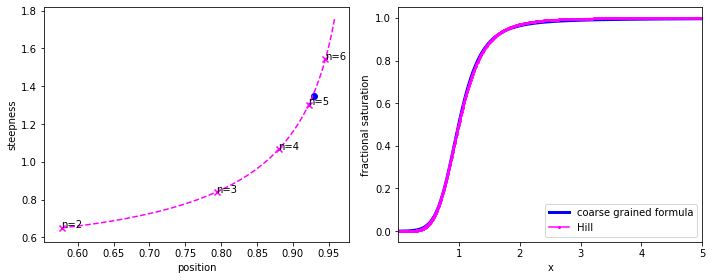

[1.37907155e-03 1.09236807e-03 4.82309527e+01 8.64952131e+00
 1.05417822e+01 1.63573045e-02]
[0.00019456 0.00037917 0.00100249 0.00036081 0.0001     0.00085044]
[35.53325922 38.91445364 29.08204003 44.9614884  47.96895754 29.81958486]
[5.99033979e+01 2.78295897e+00 1.08585253e-04 7.99811289e+01
 6.74968393e+00 2.50275004e-02]
[1.00000000e+00 1.38184781e+05 1.01709235e-06 3.79645638e-06]
effective parameters
0.0001945722669410983,0.000379178902145112,0.0013515104819795006,0.0004234076800575266,0.0001762868405367138,0.0008505565659836102,1.2001003962205854,2.6010451318388155,3.640415724509905,4.323994142426575,1.0481668030250482,1.5019831283054996,1.3963393052319255,2.0271908806324057,1.026735565421127,5276.304142997866,15443.660847400748,5.713716096094749,8841.136290014701,3.7226141222871183,8.959647667854636,1980.3326674337259,18891.77568171843,19693.85258387091,4713.154593414737,7.669096048299468,7.597145063642744,183.76526779711952,18.39951054486292,1362.531738832364,1438.90590510277

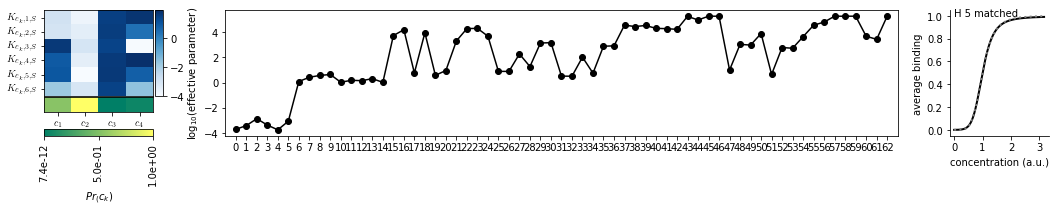

554 j=25
final_nt5_plim4_plimc6_c4_beta0.5_787.out
error 1.9935085570523778
0.00010609819392297756,0.0001,15.744800481850062,0.00010783082620638845,66.94819210429229,4.475380169086756,0.00119135198060198,0.0005777650734745006,0.0004416291749853005,0.0004239592334493774,0.0023390542679341837,0.00019613424981994055,160.65667697045652,31.94651464914606,84.44558809936655,41.10268366855592,22.551132700767962,43.78333938837762,0.02017258544357528,0.0002636987555375715,1276.9210163535888,10.100598712442565,0.00010606105472754366,21.93459842319988,600026.0348210365,1.4357008065407643e-06,0.08931184177851346
0.9299923327917645 1.3430471908206998
function evaluated between 0.01 and 10.00


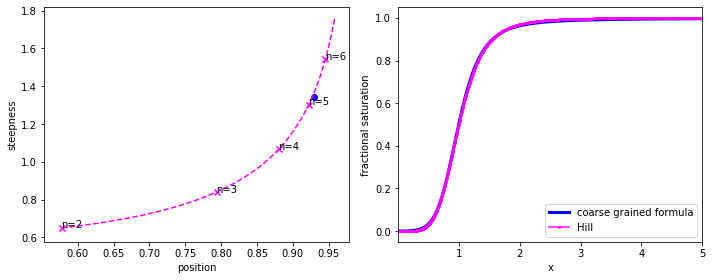

[1.06098194e-04 1.00000000e-04 1.57448005e+01 1.07830826e-04
 6.69481921e+01 4.47538017e+00]
[0.00119135 0.00057777 0.00044163 0.00042396 0.00233905 0.00019613]
[160.65667697  31.94651465  84.4455881   41.10268367  22.5511327
  43.78333939]
[2.01725854e-02 2.63698756e-04 1.27692102e+03 1.01005987e+01
 1.06061055e-04 2.19345984e+01]
[1.00000000e+00 6.00026035e+05 1.43570081e-06 8.93118418e-02]
effective parameters
0.0011913533816192167,0.0005777643069256414,0.0006579337439019259,0.00042546217899193964,0.0024506253674693827,0.0002068575129896697,1.0178407093803339,5.607688320318431,1.0874698740260298,0.9614935698672759,1.2869142494339014,0.8269692187616755,1.0108611903639615,0.9635696566166659,0.9896080020334916,6858.846229156472,1090.2031981348227,31495.78290864314,0.9649181863540758,375.7020250050027,985.9408400806212,2772.553640208974,1706.0807986871464,171.37666852090103,3816.994363805686,17.51415985616378,0.43935180107714805,16.7490036474644,298.2664890124343,34.45102647487524,0.727

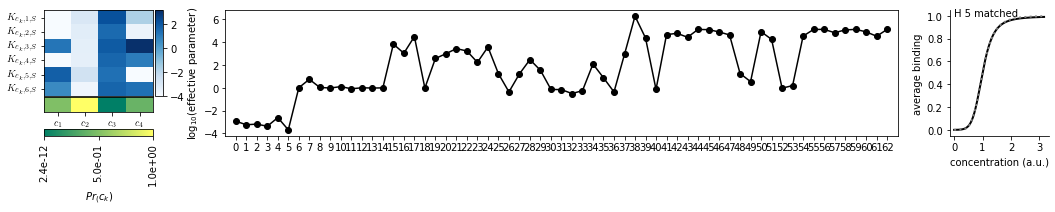

370 j=26
final_nt5_plim4_plimc6_c4_beta0.5_1651.out
error 1.993592353535492
0.17385782817930714,0.00010219827686124754,0.00042932904372624793,0.0018231863583269827,0.1399531786286119,0.29701246137263265,0.0001359062388938117,0.0001640486511587906,0.0011155740931475249,0.0031588911667056996,0.0018092463047745865,0.006287443403406677,74.14961739423943,114.54961604154775,121.47444969663515,74.05537673763645,83.47613875690942,105.50163820184768,0.016020464518888246,103.6181866055255,2813.493285227409,419.1441311830663,0.011823317186114983,0.00012498457589805724,180159.31412880422,1.5442711659549901e-06,0.0009026303809335869
0.9296025850233547 1.3472840489924833
function evaluated between 0.01 and 10.00


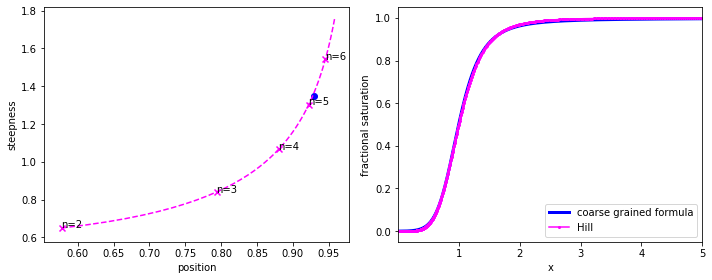

[1.73857828e-01 1.02198277e-04 4.29329044e-04 1.82318636e-03
 1.39953179e-01 2.97012461e-01]
[0.00013591 0.00016405 0.00111557 0.00315889 0.00180925 0.00628744]
[ 74.14961739 114.54961604 121.4744497   74.05537674  83.47613876
 105.5016382 ]
[1.60204645e-02 1.03618187e+02 2.81349329e+03 4.19144131e+02
 1.18233172e-02 1.24984576e-04]
[1.00000000e+00 1.80159314e+05 1.54427117e-06 9.02630381e-04]
effective parameters
0.0001368712170395244,0.00016456843166759156,0.0011296673458769115,0.0031609843470340755,0.0018100138538227955,0.0062890579785639285,4.595696980446784,2.9431006740317733,1.182904673778932,1.7518484593525192,1.403564174619101,7858.242919889463,419.42965074849195,1.292450255394353,1.0968943036945866,1655.5861594439382,1.1112807458684053,1.0030752576691249,1.012757073673586,1.002608874544613,1.0262143048081538,161.25366091013532,297.27724369537066,115341.56371111414,49434.11769287501,124.04309239713619,20732.635206753446,8352.0782388382,4955.95829548175,1821.4597319204204,3526.9

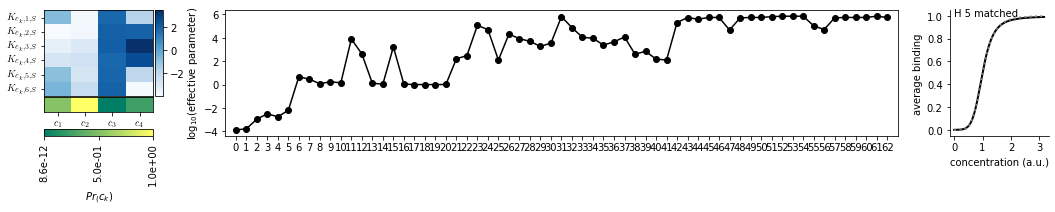

576 j=27
final_nt5_plim4_plimc6_c4_beta0.5_967.out
error 1.993748764497544
0.0001283572383907638,9.17085540845949,0.8182892145467741,1.8725705314811454,0.00015530410196436486,0.0018889473106483406,0.00010910833088580553,0.00010677184209789033,0.00011094931272954167,0.00011736760069135789,0.00010281894407845599,0.00015182091768110777,23.22506210444169,0.19715586849791,0.022064346984653767,0.0001,0.0011995889709288565,0.1969834916889147,5.342889388146729,2.269998826272202,2.1113511172475783,5.563381033441511,3.4385507502703083,8.828326146165914,781561.9647749711,0.00012401836817522522,1.0532961410797429e-06
0.930843485614913 1.3483043451252468
function evaluated between 0.01 and 10.00


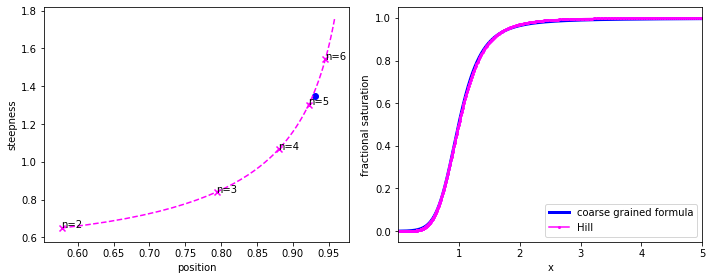

[1.28357238e-04 9.17085541e+00 8.18289215e-01 1.87257053e+00
 1.55304102e-04 1.88894731e-03]
[0.00010911 0.00010677 0.00011095 0.00011737 0.00010282 0.00015182]
[2.32250621e+01 1.97155868e-01 2.20643470e-02 1.00000000e-04
 1.19958897e-03 1.96983492e-01]
[5.34288939 2.26999883 2.11135112 5.56338103 3.43855075 8.82832615]
[1.00000000e+00 7.81561965e+05 1.24018368e-04 1.05329614e-06]
effective parameters
0.00010911204804915555,0.0001185057341540041,0.00011199616787540232,0.00011976338849807693,0.00010281901604051659,0.00015182318344330104,1.0748898631565482,1.0095133257612388,1.006588854940507,1.0025672366919398,1.04762837791628,724.3458532124117,1549.0611866279492,1.0514094122023976,2.134749958529924,147.14051833796591,1.0056212949406276,1.108465795076323,1.0123049412401883,1.2325242940957086,1.0026303132334191,1.2243445272736762,1.2142161520489867,41.85521333089313,69.68588997916244,1.5680066653617124,42.45159010555912,74.06851842699952,102.27688308127128,145.68937194943294,129.50182841

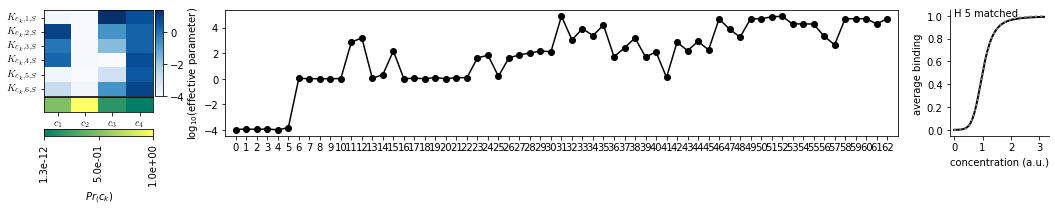

183 j=28
final_nt5_plim4_plimc6_c4_beta0.25_2478.out
error 1.9937958619384701
0.01296825923330439,0.0002585772564632854,7.6006370196892945,0.00017060678969722467,0.0012887793234541251,0.0019734851262635258,0.0015002435649815705,0.0005758367998353105,0.0012226881728134022,0.0026867403585217457,0.0001060460540215832,0.009165746836247416,82.59209213760701,127.19663216022255,127.07681951482431,156.40449894971655,95.98113122468556,139.97254742741106,0.001135143758010385,57.81412775184352,0.05695586580773588,0.15754330299587596,5358.606375970705,7665.856011617383,751928.4101679273,1.8821567064511368e-06,0.00019538003160594677
0.9294031826373933 1.347842052968138
function evaluated between 0.01 and 10.00


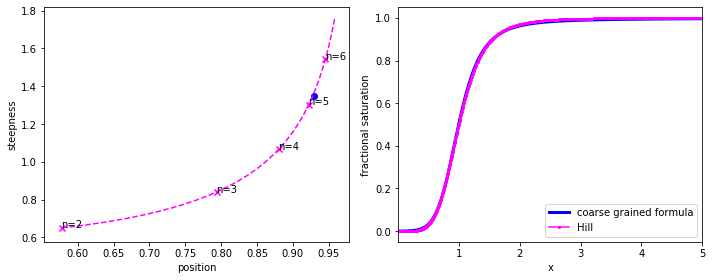

[1.29682592e-02 2.58577256e-04 7.60063702e+00 1.70606790e-04
 1.28877932e-03 1.97348513e-03]
[0.00150024 0.00057584 0.00122269 0.00268674 0.00010605 0.00916575]
[ 82.59209214 127.19663216 127.07681951 156.40449895  95.98113122
 139.97254743]
[1.13514376e-03 5.78141278e+01 5.69558658e-02 1.57543303e-01
 5.35860638e+03 7.66585601e+03]
[1.00000000e+00 7.51928410e+05 1.88215671e-06 1.95380032e-04]
effective parameters
0.0015002590230719325,0.0005758517184657203,0.0012327950582365463,0.0026867374440128315,0.00010744023814648958,0.009167729501840475,1.0304253430074888,1.0768703527270806,1.008012049958295,1.1200589470530824,1.002042905366257,1.0536543733297408,1.0336896162423033,1302.582822955895,22.82169456183287,1.0073430541695243,1.906522134553871,1.0073283775840989,1.877108589109147,1.014748483345422,10837.46679411644,2978.7560486350267,1715.122083080498,21.6316708776917,21.130355095028236,821.8564076488876,6657.045532240007,216.30325871334188,3818.5554056079236,121.69205620789138,0.93008

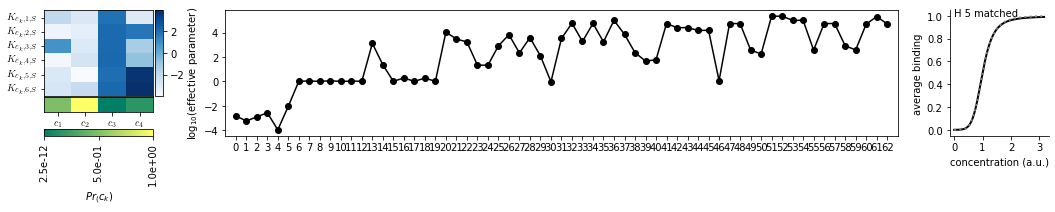

14 j=29
final_nt5_plim4_plimc6_c4_beta0.25_1110.out
error 1.9938442580528393
0.006230094206999593,0.009508004208349387,0.0023166795880300898,0.00014059317172548824,0.0023371476248790876,0.005119417379692616,0.0791619061492789,4.644916830743569,0.00011780108552567979,3.8963966677490194,0.00012165226371794597,4.150670810802243,51.568084981671525,47.34676993492584,23.885130059406613,39.61714792441844,33.57485088709846,36.70839130418317,0.0009571709051012152,0.00010467719719025149,0.00016117338908868163,0.0003014215893072216,0.00011983100248773468,0.00017840556465137088,129.39648309281878,1.0913537857065436e-06,911391.2101075252
0.9311251763626345 1.3482373062773905
function evaluated between 0.01 and 10.00


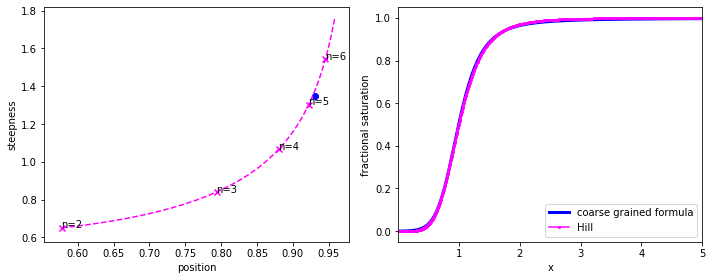

[0.00623009 0.009508   0.00231668 0.00014059 0.00233715 0.00511942]
[7.91619061e-02 4.64491683e+00 1.17801086e-04 3.89639667e+00
 1.21652264e-04 4.15067081e+00]
[51.56808498 47.34676993 23.88513006 39.61714792 33.57485089 36.7083913 ]
[0.00095717 0.00010468 0.00016117 0.00030142 0.00011983 0.00017841]
[1.00000000e+00 1.29396483e+02 1.09135379e-06 9.11391210e+05]
effective parameters
0.0009682784277642723,0.0007640491834912545,0.00016116962543637791,0.0008544977878411643,0.00011983373377058329,0.0007676007055354243,70.69450373241712,1.0064443106360605,53.27208056816156,1.0181496057189177,62.9886962208898,0.7789589361677356,3935.2294930491344,1.034133377830937,4666.576166369842,0.8340566793403406,1.0499843129636734,0.8020363381360058,1.0253710597869379,3500.2668244937677,1.0278209796783901,818.1370602021992,81.80080329506949,1139.9438972863534,81.79519156712394,572.0857459169341,2522.54995837408,620.9337052369606,860.5374668799237,81.79375030822806,893.4489649543062,4059.8025188314255,29

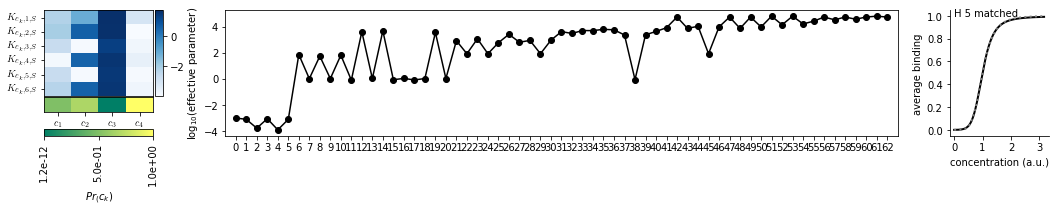

190 j=30
final_nt5_plim4_plimc6_c4_beta0.25_2541.out
error 1.9940780304396617
608.9108164383748,0.0009610773269817024,0.001151552212643573,0.003162275637208445,1.7042763730861072,0.5794111487850964,9.770605509697564,52.30620295457223,8.912334823074124,12.002074754965882,13.37705854879301,11.852248056538441,1.27124691241966,0.07150255219103936,0.054900724310421714,0.00022313639135839846,0.0014578784562050647,0.007331827899187163,0.000105213330290975,0.00012287477095607245,0.00010776171471436965,0.00010291634818531182,0.0001,0.00023188336693567515,1.0236843156308792e-06,2.8899016050423833e-05,1000000.0
0.9321098875375576 1.3455943577987792
function evaluated between 0.01 and 10.00


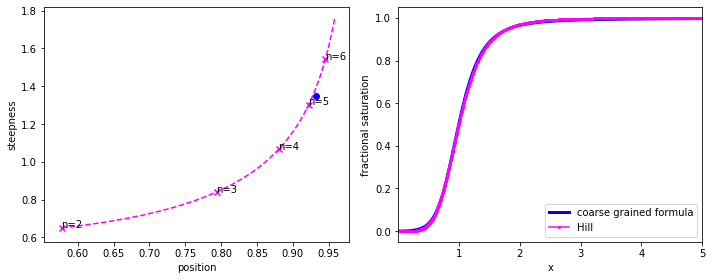

[6.08910816e+02 9.61077327e-04 1.15155221e-03 3.16227564e-03
 1.70427637e+00 5.79411149e-01]
[ 9.77060551 52.30620295  8.91233482 12.00207475 13.37705855 11.85224806]
[1.27124691e+00 7.15025522e-02 5.49007243e-02 2.23136391e-04
 1.45787846e-03 7.33182790e-03]
[0.00010521 0.00012287 0.00010776 0.00010292 0.0001     0.00023188]
[1.00000000e+00 1.02368432e-06 2.88990161e-05 1.00000000e+06]
effective parameters
0.0007141234793243026,0.00012287566476545088,0.00010776276921058282,0.00010291941983123367,0.00010170418840187072,0.00023246255795978944,6.822502269004671,9.260119017269181,26.347817449931178,14288.465353444131,2125.4160434281575,1.0361133335169512,1.051019579780068,1.1716185810199389,1.039213628075895,1.010160696162911,1.1734358273998584,1.0284494331571419,1.5137916246840075,1.0801478570316196,42.75478316495411,544.8407046252759,856.6381340751788,96056.03933024111,16288.286202909047,411.01339388196374,130247.74963866445,22139.940918862758,290154.9812492324,60532.335508140015,832973

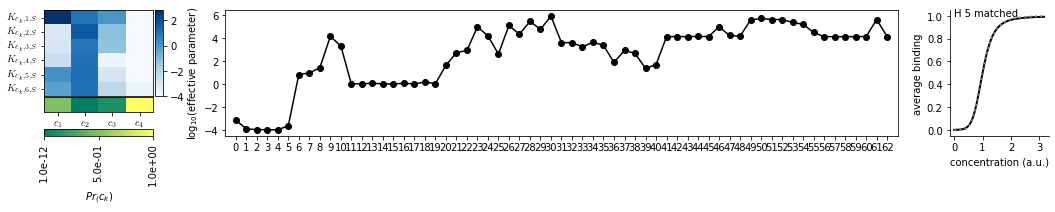

142 j=31
final_nt5_plim4_plimc6_c4_beta0.25_2145.out
error 1.9942911847274858
0.07303203576420168,0.0598163849369684,12.078850888442952,0.00014941422245431251,0.0001621883819998537,5.8569204052724135,62.4732653312397,47.163722849937756,55.13469568204616,34.32770342070546,51.133728838342634,181.17229867149078,0.0006180127428234451,0.00010161558108396313,0.0009730036187114051,0.0002352250621722433,0.00017135120912902644,0.0006232591182359279,0.00015915475523498919,0.010778970941054233,425.58073005285087,222.29724421569227,0.00020565216136895118,1.9640540015936858,2.2456149015979395e-06,1000000.0,0.3785255974134083
0.931623994123253 1.3416752617027368
function evaluated between 0.01 and 10.00


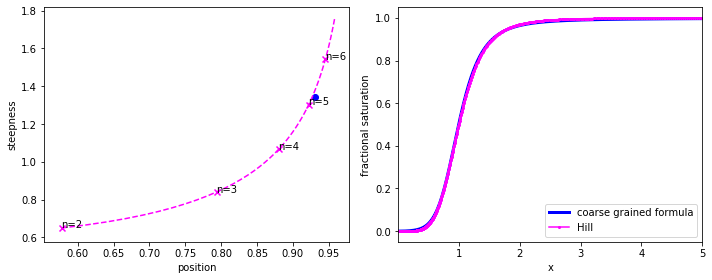

[7.30320358e-02 5.98163849e-02 1.20788509e+01 1.49414222e-04
 1.62188382e-04 5.85692041e+00]
[ 62.47326533  47.16372285  55.13469568  34.32770342  51.13372884
 181.17229867]
[0.00061801 0.00010162 0.000973   0.00023523 0.00017135 0.00062326]
[1.59154755e-04 1.07789709e-02 4.25580730e+02 2.22297244e+02
 2.05652161e-04 1.96405400e+00]
[1.00000000e+00 2.24561490e-06 1.00000000e+06 3.78525597e-01]
effective parameters
0.0006180851233467019,0.00010167944332893021,0.0011461742134689658,0.00031937004558286726,0.00017135132777610284,0.0006298590219205205,1.17405686425572,2.1411238130004797,0.8287361031347433,1.0677258248673183,2.153724398253927,21.997498599670458,28.778798159597525,1.3108096097404829,6.8839517922309374,97829.25004994251,1.0598056252085604,537.1295360660528,1.1247692802988438,822.3726844784252,1.1924915711715804,263.7408248909866,393.49464886773086,23969.03848260743,4493.166032633726,0.26950316409210084,3076.27149546294,27.615453593428303,6473.460457563545,8.791936852377123,163

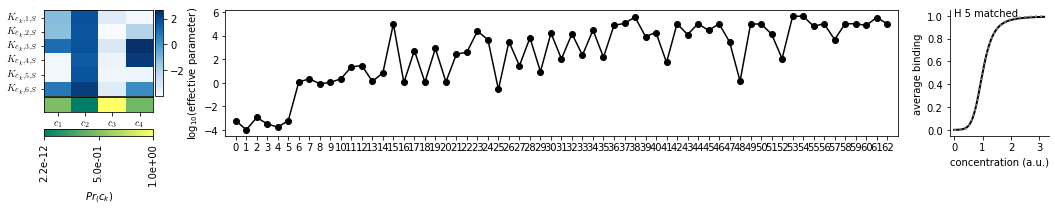

318 j=32
final_nt5_plim4_plimc6_c4_beta0.5_1228.out
error 1.99431946612963
6.228093586446206,0.00011825949597653814,0.38307750953069186,28.844586884942665,0.0005160332447530172,0.0005006153528132974,0.00011438286117742825,0.00010227624169194057,0.00011184936597194762,0.00010778973931035245,0.0001151014074502396,0.0001824265744338176,4.080026723576457,4.212257720885843,4.2185574616748,8.838154700876345,17.806435187669035,8.673341670572325,0.17095605854819734,0.09149636519608155,6.416505941170221,0.0001,0.00019509068428238236,0.06357051831946677,724149.230131844,1.1985788908208894e-06,3.14882065221454e-06
0.9308351848567807 1.3383718456091716
function evaluated between 0.01 and 10.00


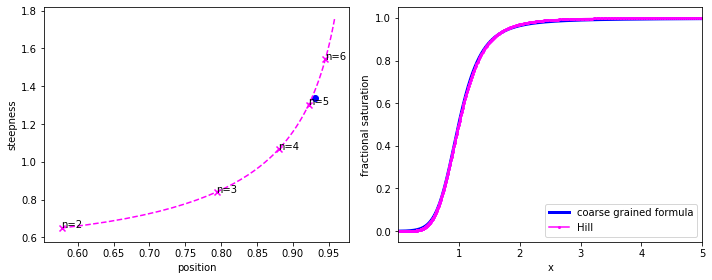

[6.22809359e+00 1.18259496e-04 3.83077510e-01 2.88445869e+01
 5.16033245e-04 5.00615353e-04]
[0.00011438 0.00010228 0.00011185 0.00010779 0.0001151  0.00018243]
[ 4.08002672  4.21225772  4.21855746  8.8381547  17.80643519  8.67334167]
[1.70956059e-01 9.14963652e-02 6.41650594e+00 1.00000000e-04
 1.95090684e-04 6.35705183e-02]
[1.00000000e+00 7.24149230e+05 1.19857889e-06 3.14882065e-06]
effective parameters
0.00012298326530967623,0.00010227627113284603,0.00011237824921252433,0.00014762192949394252,0.00011510199058113008,0.0001824270284609352,1.01319530698088,239.31633830629463,13665.186739457768,1.2520844784433631,1.1245867124389395,1.0035160887837145,1.0462480558617415,1.0105460509595798,1.0032425516405914,920.5214794330227,1.0260040087220443,1.0112482955618747,1.9552050192327695,1.4753396801959424,1.012181946103731,360.50318265645336,15231.569435060628,347.4838605572808,108.32334824233806,50601.746504423565,1353.3744262890662,744.8532323585212,31593.06302158356,25522.96704008893,400.

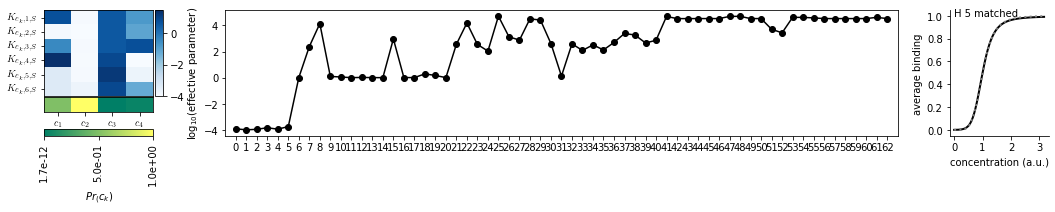

145 j=33
final_nt5_plim4_plimc6_c4_beta0.25_2172.out
error 1.9943687441098497
4.943302502618508,197.43409849038358,0.00019429998929173384,25.04631659934167,0.00020787887593812538,0.00014096165316474193,0.00013127168734001078,2.800365866094263,0.003867252370537307,0.028040421057326154,0.0004425771238544838,0.0001887563946866258,24.54653612879788,58.88265001359898,40.37573061784923,69.6602615399888,17.394847955267437,70.22993681005562,0.0005282077350670443,0.0009287747823412794,0.0014701304316764405,0.0008730732896128395,0.0001715859140840715,0.00010323408690168522,0.5085828305293436,2.705303098928267e-06,793371.2302418267
0.9305864255650691 1.3469271024265963
function evaluated between 0.01 and 10.00


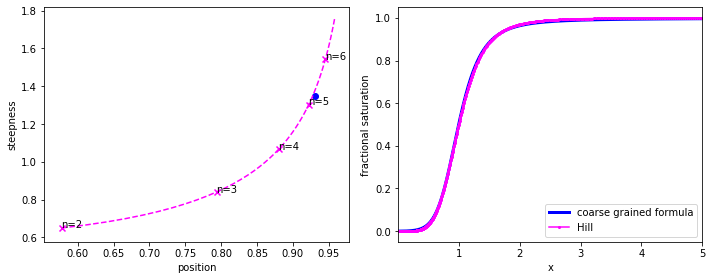

[4.94330250e+00 1.97434098e+02 1.94299989e-04 2.50463166e+01
 2.07878876e-04 1.40961653e-04]
[1.31271687e-04 2.80036587e+00 3.86725237e-03 2.80404211e-02
 4.42577124e-04 1.88756395e-04]
[24.54653613 58.88265001 40.37573062 69.66026154 17.39484796 70.22993681]
[0.00052821 0.00092877 0.00147013 0.00087307 0.00017159 0.00010323]
[1.00000000e+00 5.08582831e-01 2.70530310e-06 7.93371230e+05]
effective parameters
0.0005344376426281756,0.001179422510598506,0.0014701304978864678,0.0009046592612451344,0.0001715861928588509,0.00010323442875327246,1952.408125161949,0.9941836645684129,323.7422484390886,1.018341471532251,1.1108014604257896,0.8240467891915039,5842.453789010379,1.0642890397088274,1.1941794525085607,0.9769588426352203,1.009494810345367,1.0637070665626946,1.0340287004247357,1.1913886017938904,1.2351643474774971,574.5502248482227,9248.34484018103,2967.103730297956,6686.464774069892,383.65818902603337,432.9279789374483,2751.8134532537492,1561.4282098075626,7256.880211487723,8745.47928344

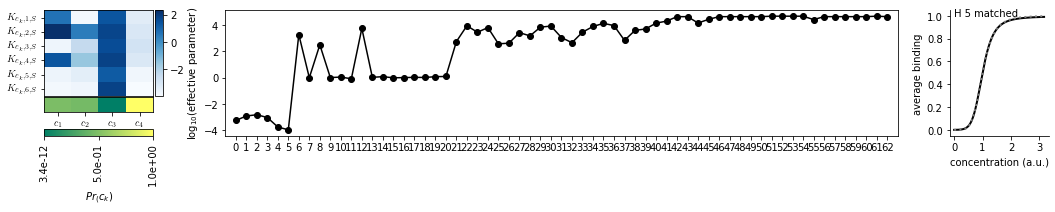

226 j=34
final_nt5_plim4_plimc6_c4_beta0.25_48.out
error 1.9944377322629123
0.006643884680272906,6.054542573162205,0.3881272039276093,48.26898857287693,0.0049835245831328645,0.00026507390925130636,0.0002020112997045131,0.00021678613006694897,0.00010512907987708147,0.00010864433231521137,0.0001,0.00012445993713530867,0.00013275523653951283,0.392530826000363,0.0001,0.0001,0.00030559154850499844,2.251708484350842,10.099802575904805,11.773542545261533,8.673919252559061,9.275834533243863,5.76676539469097,6.976691693559501,717674.7534456586,1.034862188458828e-06,1.1533608708911657e-06
0.9309930596335461 1.344153089197531
function evaluated between 0.01 and 10.00


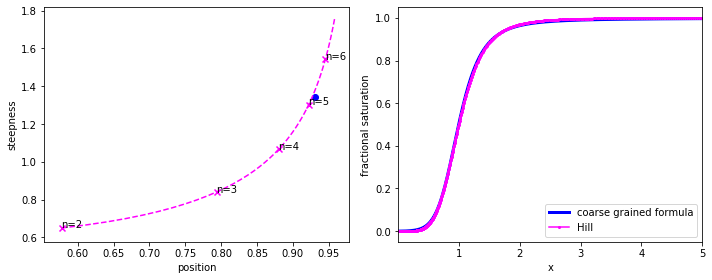

[6.64388468e-03 6.05454257e+00 3.88127204e-01 4.82689886e+01
 4.98352458e-03 2.65073909e-04]
[0.00020201 0.00021679 0.00010513 0.00010864 0.0001     0.00012446]
[1.32755237e-04 3.92530826e-01 1.00000000e-04 1.00000000e-04
 3.05591549e-04 2.25170848e+00]
[10.09980258 11.77354255  8.67391925  9.27583453  5.76676539  6.97669169]
[1.00000000e+00 7.17674753e+05 1.03486219e-06 1.15336087e-06]
effective parameters
0.00020202029195729858,0.00022522216784979197,0.00010566975869619453,0.00017590157264261872,0.00010000681390700277,0.0001244601475235658,2.1985810620739477,1.169747470057133,13.196541392917807,1.0068024380862812,1.0045537662973092,138.54767846728228,10279.35135583014,2.833910952646647,1.0470724027829106,1405.0303297777493,1.2574573473235762,1.013175108770694,19.6760941582141,1.4367334432003,1.005271424363018,35.15355596325934,32.90690223757522,107.46205546077546,228.27519756746773,33.12062985219757,309.89407094979975,366.2191894382503,44.29473608506834,184.37352830231757,259.3405195

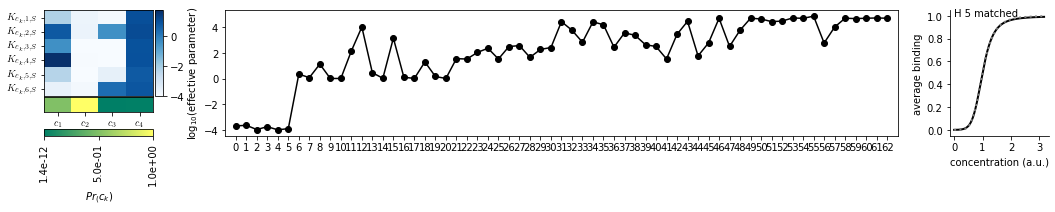

77 j=35
final_nt5_plim4_plimc6_c4_beta0.25_1623.out
error 1.99456555054891
350.8752453349518,0.0017788005674784094,3.020950844941088,148.643470201643,0.13057549539815572,0.0001382775857286711,112.759221158918,59.437399689973034,70.29343956651768,334.1961981999893,71.67517126709355,59.8879885770846,1827.5556521241074,4.398558805882298,0.0007678828611634832,0.010578313765467251,0.007148818936106105,0.0002108769823568347,0.00010386439041946915,0.00017924686141141964,0.00011287739910135079,0.00019904230286311569,0.0002558133734719461,0.005199257469442791,1.0037301803823147e-06,0.0010221592458673876,1000000.0
0.9310482059270657 1.3435020515621547
function evaluated between 0.01 and 10.00


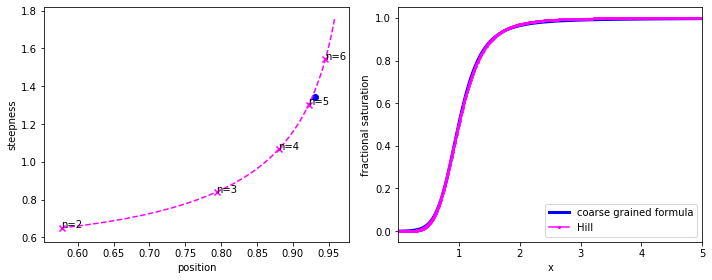

[3.50875245e+02 1.77880057e-03 3.02095084e+00 1.48643470e+02
 1.30575495e-01 1.38277586e-04]
[112.75922116  59.43739969  70.29343957 334.1961982   71.67517127
  59.88798858]
[1.82755565e+03 4.39855881e+00 7.67882861e-04 1.05783138e-02
 7.14881894e-03 2.10876982e-04]
[0.00010386 0.00017925 0.00011288 0.00019904 0.00025581 0.00519926]
[1.00000000e+00 1.00373018e-06 1.02215925e-03 1.00000000e+06]
effective parameters
0.0004566073447668817,0.00017925301646222946,0.0001158983052699491,0.00034768577127877975,0.000255943772011464,0.005199252463475162,108.32502732676531,20030.169554008287,328525.4137575621,392.4475519381346,0.2509280134577362,1.4345839724012188,5.1356027648231475,1.098422306343106,1.0038005225826638,11144.730945807434,14.441825701936041,0.9816402275885364,218.95237822868128,0.5949607401665582,1.0027417720408571,173763.23113430935,650778.9244387054,27049.053372927414,947.6125443066682,768373.9505059979,710487.8236088052,2306.9411703762735,765788.1309831897,19298.45361881539,807

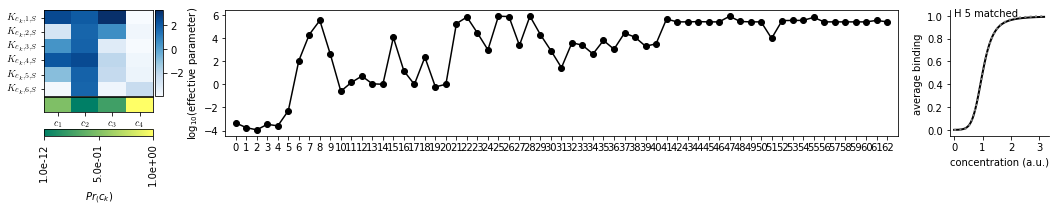

39 j=36
final_nt5_plim4_plimc6_c4_beta0.25_1308.out
error 1.994654978223974
14.440212059275876,0.00018413513867249255,0.0027372730758351326,9.971502897497158,10.83334228671423,0.012839296479209726,0.00010378331468643253,0.0001697621145300881,0.0003561771032004223,0.00013944224873467542,0.00010019242747845318,0.00012438547629185998,19.234691243745267,17.729177674097397,28.564160142445694,23.695231809548815,23.971559771638454,58.81865463074199,0.00011540561836732909,0.0005384153613838553,0.039198798781119745,0.00014477872043706317,0.0044771364680920665,0.0007949636924025508,130116.74826889785,1e-06,1.647773791009758e-06
0.9294926314412335 1.3445166668852497
function evaluated between 0.01 and 10.00


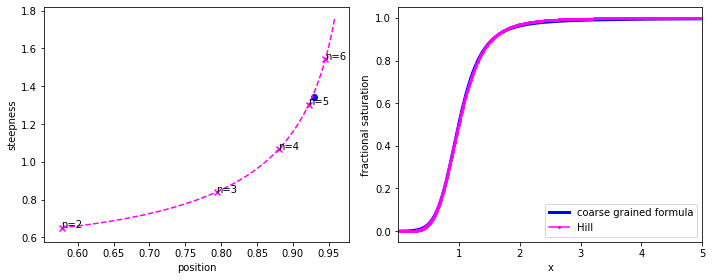

[1.44402121e+01 1.84135139e-04 2.73727308e-03 9.97150290e+00
 1.08333423e+01 1.28392965e-02]
[0.00010378 0.00016976 0.00035618 0.00013944 0.00010019 0.00012439]
[19.23469124 17.72917767 28.56416014 23.69523181 23.97155977 58.81865463]
[0.00011541 0.00053842 0.0391988  0.00014478 0.00447714 0.00079496]
[1.00000000e+00 1.30116748e+05 1.00000000e-06 1.64777379e-06]
effective parameters
0.00021476070018831177,0.00016976236125000095,0.0003561956227629913,0.00021607581550636652,0.00018344983253552782,0.0001244836468397507,1.1156344172177701,4.50952919287945,23847.548119958283,30516.337013358458,54.106129267784425,1.0643670079752774,1.1180423576907335,1.1433019351754867,1.3793014090145577,3.438394110168257,4.114350032749604,1.2964484237674505,20944.628298270556,37.62330848774236,47.83011239056102,5420.54916242198,30186.288885803762,37167.080436799835,24667.74030025943,55058.507957527654,58750.63812742238,20433.811457083044,67237.60101167239,66322.51423331033,66692.93320289682,2053.82871186259

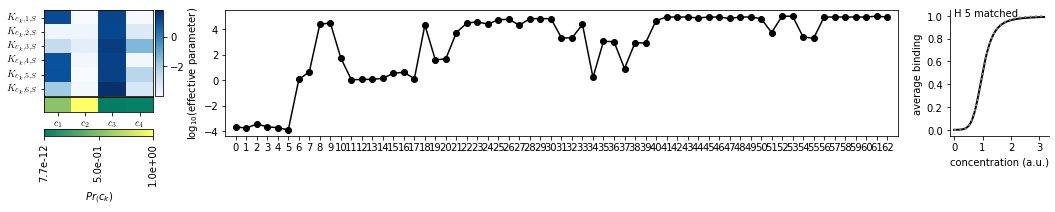

126 j=37
final_nt5_plim4_plimc6_c4_beta0.25_2019.out
error 1.9947366097325552
182.81270463516918,0.001035322583932141,0.0019222584251853015,0.015129501608567237,652.126303195437,6.390681692859567,0.0006439345350903642,0.0017675220751934037,0.001447550305307807,0.00033514126819151,0.007891608701132992,0.00011887555855132893,130.57499860672323,77.41825787046514,148.69744330692055,130.834835054604,346.9934297505544,79.68009288594219,0.0001834036486507548,0.009467042037955224,0.01155848030660521,143.82873636348907,0.0013074128320027304,204.43366953490633,971984.6893757584,2.3400026909124424e-06,1.1497556325620199e-06
0.9314832493500486 1.345637148595931
function evaluated between 0.01 and 10.00


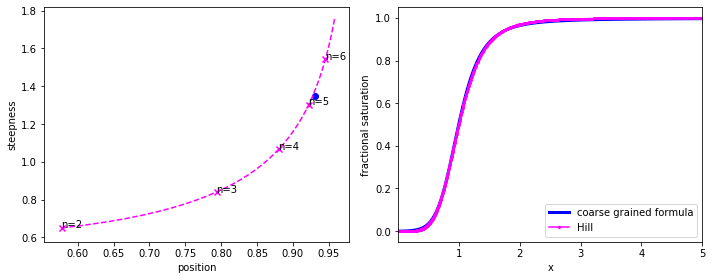

[1.82812705e+02 1.03532258e-03 1.92225843e-03 1.51295016e-02
 6.52126303e+02 6.39068169e+00]
[0.00064393 0.00176752 0.00144755 0.00033514 0.00789161 0.00011888]
[130.57499861  77.41825787 148.69744331 130.83483505 346.99342975
  79.68009289]
[1.83403649e-04 9.46704204e-03 1.15584803e-02 1.43828736e+02
 1.30741283e-03 2.04433670e+02]
[1.00000000e+00 9.71984689e+05 2.34000269e-06 1.14975563e-06]
effective parameters
0.0008320158702808008,0.0017675215082757537,0.0014475511516873212,0.0003351569740615691,0.008562523129865713,0.0001254507421030153,0.9229047068915827,1.1129423338415525,11.125886011708541,17217.228050475518,11516.633642742452,1.0108314103484872,1.041145664577195,0.9718144621777666,1.0452710933027447,1.096555896472498,1.0357169544801332,1.174272024850774,4.496778699400221,4.737541263382957,3992.507981911738,1682.6625324051533,6211.276373882818,11067.83018192958,16509.514093534715,13829.589004929334,23593.281609818896,34015.64641705698,174159.54726139636,129500.36710217016,2196

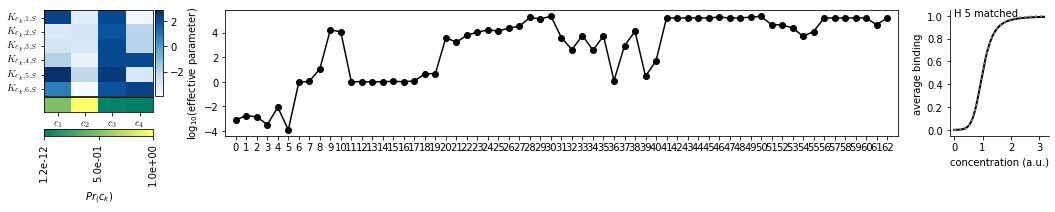

125 j=38
final_nt5_plim4_plimc6_c4_beta0.25_2010.out
error 1.9947607962966203
8.155957219596642,34.158954679895615,0.18496286321470112,0.00010938180524362997,2288.048002105843,0.05215303764424084,0.00022808803371567526,8.66092212939973,0.00010815650248026851,0.8640184990512622,0.004303157013024343,0.0022978063684885378,0.0009785481988866915,0.0007665252576720123,0.0005944089349943172,0.00022494658585017527,0.001147318857679629,0.0012138035193614242,310.29894117469667,63.22550583473075,365.5161819134248,123.22473876835136,78.16872179100562,141.3525769903195,0.00011411106371490315,976774.8858366358,1.0910776187270286e-06
0.930370898108759 1.3465563159458442
function evaluated between 0.01 and 10.00


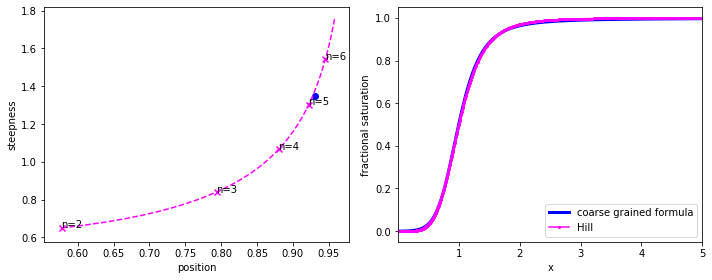

[8.15595722e+00 3.41589547e+01 1.84962863e-01 1.09381805e-04
 2.28804800e+03 5.21530376e-02]
[2.28088034e-04 8.66092213e+00 1.08156502e-04 8.64018499e-01
 4.30315701e-03 2.29780637e-03]
[0.00097855 0.00076653 0.00059441 0.00022495 0.00114732 0.0012138 ]
[310.29894117  63.22550583 365.51618191 123.22473877  78.16872179
 141.35257699]
[1.00000000e+00 1.14111064e-04 9.76774886e+05 1.09107762e-06]
effective parameters
0.0009868974192782012,0.0008014966834090603,0.000594598095279012,0.00022494670609385787,0.0034897670828468188,0.001213855827760787,361.56362305466916,3.8390210106158253,1.1880446897956614,5547.570403712853,1.3959079828574459,14.583013341533489,1.030700328678878,28607.59876360728,2.8412394456066687,1.3759861282128918,209.14610595627266,1.0932820886169867,0.6688645699944169,1.071232630245764,29.17106842201607,8859.677358031871,14895.702004006094,8264.17039466475,6588.585927778807,85953.71351432268,8273.769804943346,23100.55874423298,10476.224993188402,20915.23466237675,8201.693

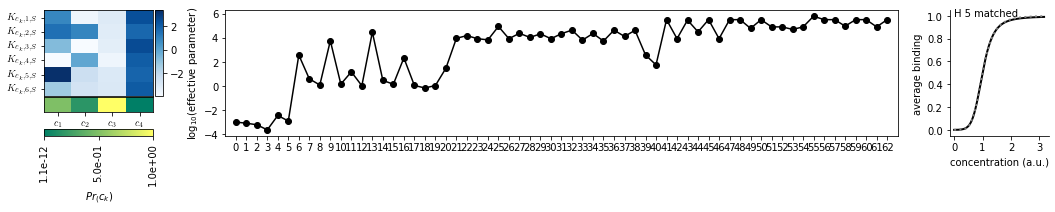

89 j=39
final_nt5_plim4_plimc6_c4_beta0.25_1722.out
error 1.9948208003570393
0.12328016652265826,2457.7011311294395,0.00012036303015796327,0.08897221322837322,5.697088757980384,36.70205171245816,0.0005850711120782465,0.002429329377116111,0.00020188186435760345,0.001589716830278448,0.0053992647414334025,0.002687821872635309,97.20500946386282,141.90851586301744,137.34746363734217,223.92881407277505,121.25084876352048,149.59426992597156,0.00928905587675537,1.0607829512791473,16.219011931286804,7.834471728427009,0.014608816586760753,0.156591893057425,921165.5522875643,1e-06,0.0002963172996049474
0.9312573272006676 1.3444039075596943
function evaluated between 0.01 and 10.00


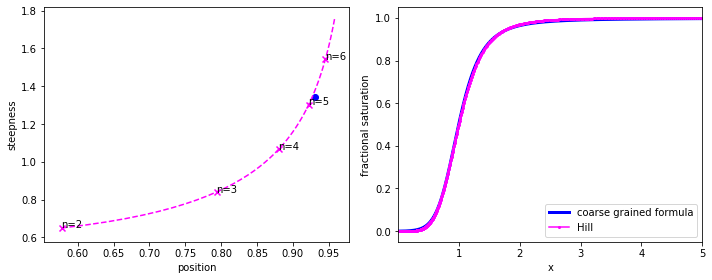

[1.23280167e-01 2.45770113e+03 1.20363030e-04 8.89722132e-02
 5.69708876e+00 3.67020517e+01]
[0.00058507 0.00242933 0.00020188 0.00158972 0.00539926 0.00268782]
[ 97.20500946 141.90851586 137.34746364 223.92881407 121.25084876
 149.59426993]
[9.28905588e-03 1.06078295e+00 1.62190119e+01 7.83447173e+00
 1.46088166e-02 1.56591893e-01]
[1.00000000e+00 9.21165552e+05 1.00000000e-06 2.96317300e-04]
effective parameters
0.0005852044157448111,0.005097358465252341,0.00020188714216801742,0.0015898144537123597,0.005405443660383148,0.0027276621805401324,110.74489058669654,1.122966196988692,1.037931691287928,1.243701989666248,4.072197805602928,0.8145658760240649,29.77345724159848,552.1314833797708,7043.27352568123,1.231322181061982,1.0161480509460203,1.0360633107917214,1.0662598208024165,1.8112750260620012,16.38072779523883,4274.074915442876,231.02230710931084,210.6846365112657,210.68677597278034,14035.336533320382,2709.1418824291964,6496.455290643387,547.9016002222021,864.656180395378,211.5887595

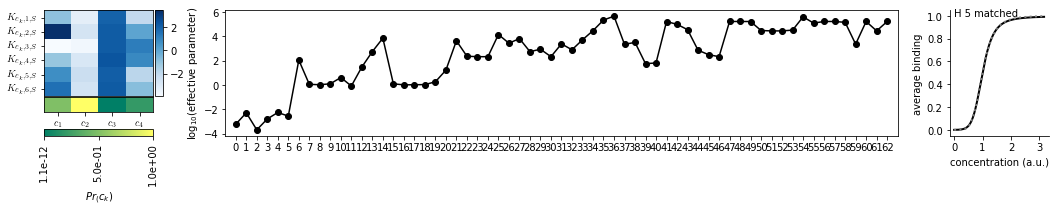

146 j=40
final_nt5_plim4_plimc6_c4_beta0.25_2181.out
error 1.9948776023651147
190.24736667674713,0.00020214654825503908,0.004099487331822161,0.0011902974834010521,34.31752244484248,770.3887265125334,0.0005235441264116931,0.0032863749315963763,0.0008310277794976933,0.0033941485981931587,0.006805825766733705,0.010683613260873583,188.76534541904408,174.7793511852531,392.43468508108066,202.5756221460934,271.1906014518266,131.04564221775334,6.567902346895758,0.00012940197106452977,5.916187397375098,0.00016584341025401977,0.20894095733100132,0.005294990963176832,881116.4410890675,5.323360812340966e-06,0.0036199377456514466
0.930443093497354 1.3470356135959531
function evaluated between 0.01 and 10.00


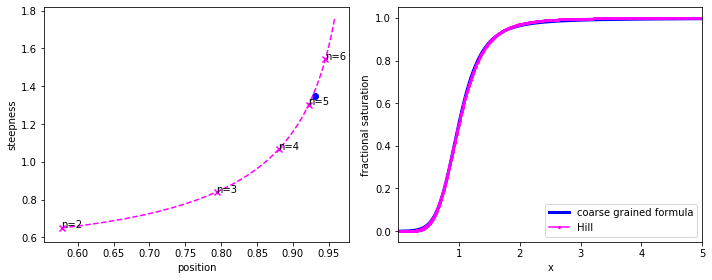

[1.90247367e+02 2.02146548e-04 4.09948733e-03 1.19029748e-03
 3.43175224e+01 7.70388727e+02]
[0.00052354 0.00328637 0.00083103 0.00339415 0.00680583 0.01068361]
[188.76534542 174.77935119 392.43468508 202.57562215 271.19060145
 131.04564222]
[6.56790235e+00 1.29401971e-04 5.91618740e+00 1.65843410e-04
 2.08940957e-01 5.29499096e-03]
[1.00000000e+00 8.81116441e+05 5.32336081e-06 3.61993775e-03]
effective parameters
0.0007394876679221933,0.0032863724741936918,0.0008310581622219423,0.0033941473075907256,0.0068447682393299476,0.0115579333932924,0.8079627037238962,3.136261445121689,0.9024234146879977,1464.665113217068,19462.50083062366,1.1516910345243032,1.0191770694484854,1.0073906208558934,0.9326490912293418,1.170238594659539,1.1362672258864963,1.3298376564382208,1.010591812866392,0.9549699159612811,380.1958409923176,33629.91732719935,4803.8229053065825,3315.863528381607,2281.362999314049,37142.721799724764,31755.837429132906,78400.61902000543,4117.3032269011,8240.433168704241,256647.2135

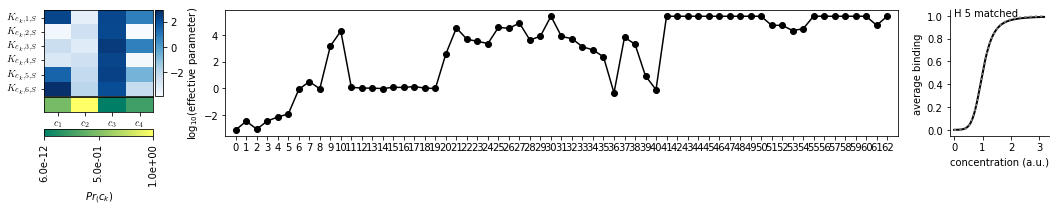

268 j=41
final_nt5_plim4_plimc6_c4_beta0.25_822.out
error 1.9948983451085076
0.006669146344261353,0.0001470027790014596,0.47362576252218486,0.00010718772069332316,0.025678425506567702,0.00014177969634947293,0.03106286128542478,0.00022109123292552387,133.0983689326617,2.3736608988250283,0.00010302840847431972,243.01026247861014,0.0006824697624817142,0.00012269647118220165,0.0013240652990975633,0.00029113544266596257,0.0025478604855785343,0.0001,33.72795758211904,66.52976448766442,40.21592045035321,69.56800115136804,47.562177718114214,46.40283515785104,0.23831666436255433,438792.8775196687,1.2620241058164576e-06
0.9313868267226915 1.3463268967507451
function evaluated between 0.01 and 10.00


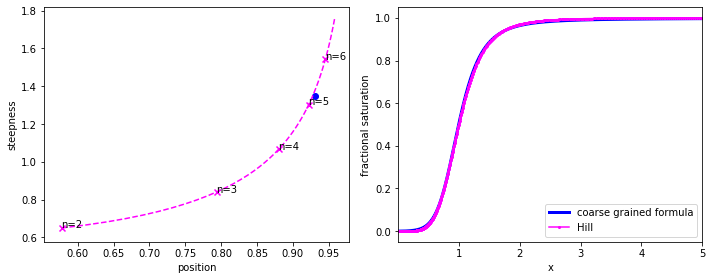

[6.66914634e-03 1.47002779e-04 4.73625763e-01 1.07187721e-04
 2.56784255e-02 1.41779696e-04]
[3.10628613e-02 2.21091233e-04 1.33098369e+02 2.37366090e+00
 1.03028408e-04 2.43010262e+02]
[0.00068247 0.0001227  0.00132407 0.00029114 0.00254786 0.0001    ]
[33.72795758 66.52976449 40.21592045 69.56800115 47.56217772 46.40283516]
[1.00000000e+00 2.38316664e-01 4.38792878e+05 1.26202411e-06]
effective parameters
0.0006825000030758945,0.00012269677136268758,0.0013974290819205558,0.000292424241656883,0.002547912008471342,0.00023198324585238094,1.0770901789161291,3.3134678253588046,1.2300168014615396,1.0028112929660562,26.353564749956785,1.086514513363746,1.3745426366337077,1.0291137301737616,1.768189401350616,420.85943065973674,0.9589003522355873,54188.60568928053,1.008529081598063,4618.704106975546,0.46481455203908145,2046.098864835164,13339.734128130278,1398.919930595124,8745.020232934774,47.72360258192419,80.79474663636543,45.52809873600251,626.8582269917812,46.9722595461916,1144.953159569

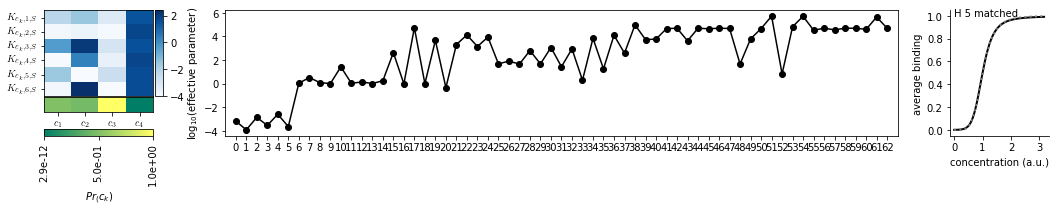

278 j=42
final_nt5_plim4_plimc6_c4_beta0.25_903.out
error 1.9949206664881047
0.002960007816808237,110.26774401289944,0.007134416860210396,0.008072189016331364,6.917457866983603,1.6479391358434945,0.03320729444642534,1.3256073381406157,979.7648511715274,0.0012217699288993413,0.0010111568132968945,0.00024255770129084296,19.037772162240575,15.386898752155204,15.558115618302157,60.56272401352452,20.11711436887755,8.841163620125323,0.00013142602745015334,0.0004894932296389102,0.0001,0.0002728260151536389,0.00014021106306854648,0.0008510034749470755,0.0011890275463824667,1e-06,671967.0474483948
0.93060623366324 1.3463920203747333
function evaluated between 0.01 and 10.00


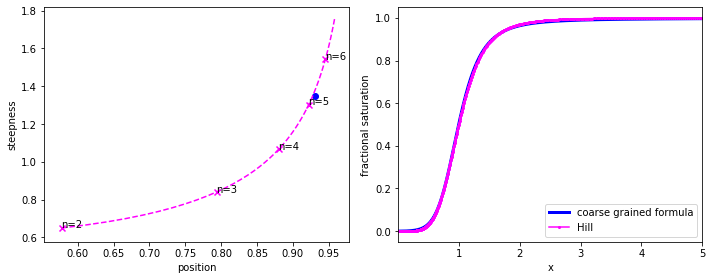

[2.96000782e-03 1.10267744e+02 7.13441686e-03 8.07218902e-03
 6.91745787e+00 1.64793914e+00]
[3.32072944e-02 1.32560734e+00 9.79764851e+02 1.22176993e-03
 1.01115681e-03 2.42557701e-04]
[19.03777216 15.38689875 15.55811562 60.56272401 20.11711437  8.84116362]
[0.00013143 0.00048949 0.0001     0.00027283 0.00014021 0.000851  ]
[1.00000000e+00 1.18902755e-03 1.00000000e-06 6.71967047e+05]
effective parameters
0.000131430323707326,0.0006535915758789308,0.00010174415622196343,0.00027283771370655187,0.00015050521146219327,0.0008534546275763706,6.409338559836252,5.3233389983539965,1.0487655519663461,2.5008226503366946,1.0640427336664815,52.90594079268842,8.184832335659197,11540.23995255373,485.53769535659427,1.1127166448012293,5.856705042809734,1.1887268036897385,2.9993551980794546,1.0855214159563422,133.0018722757887,187.2190920143323,158.15968934786096,22.578966670902883,22.59665462612223,6593.878692751271,775.8195519250031,292.92539324666035,2147.858986222305,459.3113647395502,24.61501449

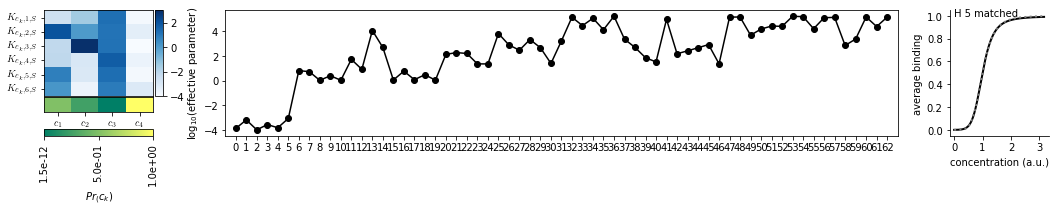

54 j=43
final_nt5_plim4_plimc6_c4_beta0.25_1434.out
error 1.9949440621140329
0.00016084593033950626,1.220789460744985,8.708480579737989,60.278156101146344,0.00012931353119516713,0.0032307367565476038,0.00014339556344013658,0.0007018322088346593,0.00012392226407088923,0.00045816183218394725,0.0002584941739372546,0.00010723430303987216,16.639019858444446,11.874165387598612,24.435169756564648,22.657991602874,12.25055172825979,16.917256025810076,0.014985143021812771,0.00010293341965967081,136.9092969132933,0.00013855783138385082,0.4287972809631156,0.07193782653331117,304637.63249386783,1.0884605613356993e-06,1.2860177449173382e-06
0.9307246159347323 1.3396741604917728
function evaluated between 0.01 and 10.00


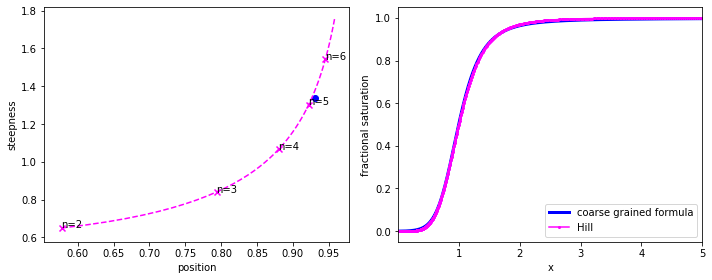

[1.60845930e-04 1.22078946e+00 8.70848058e+00 6.02781561e+01
 1.29313531e-04 3.23073676e-03]
[0.0001434  0.00070183 0.00012392 0.00045816 0.00025849 0.00010723]
[16.63901986 11.87416539 24.43516976 22.6579916  12.25055173 16.91725603]
[1.49851430e-02 1.02933420e-04 1.36909297e+02 1.38557831e-04
 4.28797281e-01 7.19378265e-02]
[1.00000000e+00 3.04637632e+05 1.08846056e-06 1.28601774e-06]
effective parameters
0.00014339568023495728,0.0007058372837707077,0.00015250878722563373,0.0006560281438424929,0.00025849379547057,0.00010724461692702577,1.0076646099034807,1.0896274254150358,1.0510228912793458,1.019648237939664,1.0654103561641632,325.00690774561394,522.3578794796244,1.0000127508764236,1.1747404295641648,17223.239422762483,0.9397417330232619,6.551943177486796,0.8551196316561323,9.80390656203812,1.0266670239231024,4.559673443843037,1.5826836274687208,331.5328198402548,937.5584091948131,1.2548937658036594,3351.6146285516425,1600.4100601493296,794.6060836131053,231.5060835677389,3019.88138

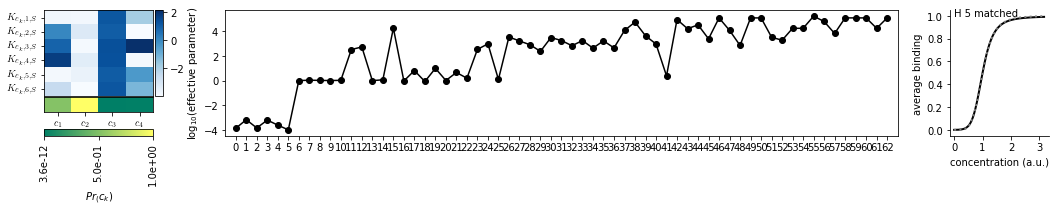

574 j=44
final_nt5_plim4_plimc6_c4_beta0.5_949.out
error 1.9949736260236535
2.0246902497465067,0.00013646386323680403,179.35438605940683,5.714118494578349,0.0001,0.0029187358263406977,681.6965306175854,0.00017847868870340058,0.00018523621707265903,5.794961306980057,0.0001288888907017082,0.00011949390418267971,36.68762986782381,31.118819989638066,9.189538058634204,20.596899935660126,9.554388803511427,16.072090902363033,0.0005487860909878805,0.0001509947440372897,0.00014667398624323787,0.00012650228843031906,0.0001412607485122752,0.00010901982176212289,0.04543730181208141,2.9643575303054683e-06,836711.357681325
0.9306330929292697 1.3458763691063083
function evaluated between 0.01 and 10.00


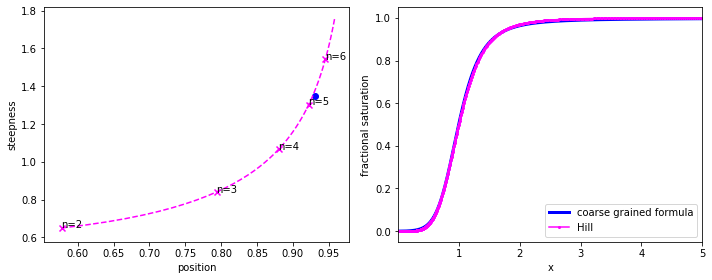

[2.02469025e+00 1.36463863e-04 1.79354386e+02 5.71411849e+00
 1.00000000e-04 2.91873583e-03]
[6.81696531e+02 1.78478689e-04 1.85236217e-04 5.79496131e+00
 1.28888891e-04 1.19493904e-04]
[36.68762987 31.11881999  9.18953806 20.59689994  9.5543888  16.0720909 ]
[0.00054879 0.00015099 0.00014667 0.0001265  0.00014126 0.00010902]
[1.00000000e+00 4.54373018e-02 2.96435753e-06 8.36711358e+05]
effective parameters
0.0005882245840288949,0.00015099483841234137,0.0003610299199058611,0.00013364614656384506,0.0001412607323768783,0.00010902323731447813,1.056598309865137,2044.0740009248211,2905.6451114471197,1.0082320175345814,1.1446083341972064,0.9614467733146927,1.1080379558878388,1.0493842668560274,1.1076345480449366,25385.880889967135,0.8326757899359496,16.31483117953674,1.0217978919252624,2.3976080889885307,1.0353158077580722,3127.120971236026,9389.363386022738,2936.1635912524594,6062.067257451227,3442.071218287782,2194.7977486745804,3404.3693695559946,4813.651121429215,5305.652896856442,2129.1

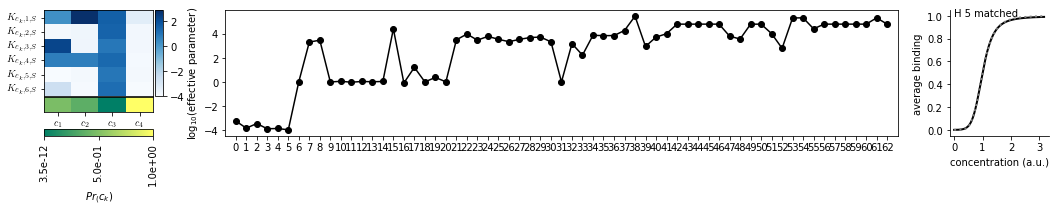

251 j=45
final_nt5_plim4_plimc6_c4_beta0.25_678.out
error 1.9954035149226461
4.631150783882462,0.002405823768448618,28.158437073313067,1024.7734687539062,0.00012213649558247128,0.00013025386968836303,0.021135991517728818,0.0033939790108012784,926.7526658236387,0.001479654516407818,0.30201739018955637,0.00383026043485239,52.47610552375602,175.8017053573651,73.65237810947767,191.3075607507696,42.46719082245705,90.04481236454544,0.0005335650759113924,0.00016989851039474243,0.0015756447174416763,0.0006826865578839,0.001917809010234691,0.0018610384347639854,0.4496127146340461,1.1731502531581234e-06,640612.7139755064
0.9315712883237562 1.3454574685488014
function evaluated between 0.01 and 10.00


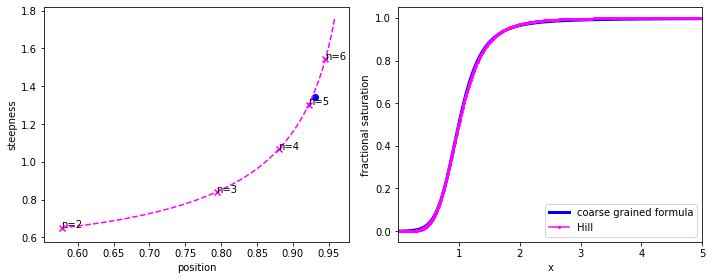

[4.63115078e+00 2.40582377e-03 2.81584371e+01 1.02477347e+03
 1.22136496e-04 1.30253870e-04]
[2.11359915e-02 3.39397901e-03 9.26752666e+02 1.47965452e-03
 3.02017390e-01 3.83026043e-03]
[ 52.47610552 175.80170536  73.65237811 191.30756075  42.46719082
  90.04481236]
[0.00053357 0.0001699  0.00157564 0.00068269 0.00191781 0.00186104]
[1.00000000e+00 4.49612715e-01 1.17315025e-06 6.40612714e+05]
effective parameters
0.0005408080345550472,0.00016990458543129493,0.00227003464286109,0.0022823598512187364,0.0019180169087492029,0.0018610372799918202,1.3602616486722765,177.70446532377892,6002.268733930438,0.9956027628219348,0.9961952148110943,6.753448413802912,10.382376741024993,1.044016899335037,1.0916738707909106,8694.471273183282,45.814898381848536,1.288056029087113,0.3471829078848062,0.35559664740591607,1.0020792590574954,1264.2160104187797,9670.09054989693,3900.3432912927587,8149.915740060946,8563.055327274897,41.51972135570032,244.00523909192117,2051.581577065301,3208.766147086347,190.96

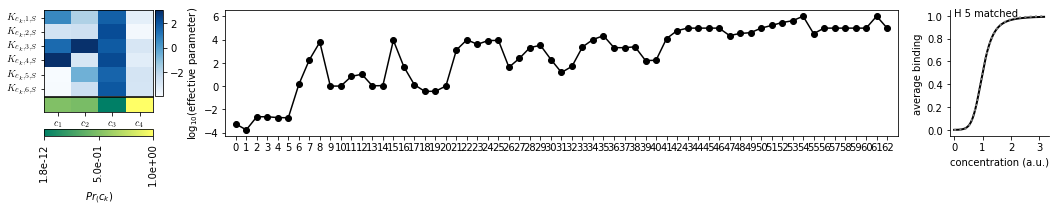

117 j=46
final_nt5_plim4_plimc6_c4_beta0.25_1947.out
error 1.9955686951307878
0.0007644003116212706,16.562911687085993,0.6068180736765888,0.00341954254598586,260.0291010936201,0.0001537306818186762,16.40372101302652,12.39406647824166,25.321862611559663,16.45619717057805,36.779257551110035,37.50219766337473,0.0001035872393648559,0.0001182783902300867,0.00010321967639042912,0.00011715041415514153,0.00010848196841144066,0.0003456442227431963,0.025662398183694944,0.20391144616177467,0.6867536479982576,0.00015928773808955997,0.02515215072428553,0.0002964238035090875,1.5350642929932188e-06,929348.1774303842,28.375336118665185
0.9319854510099066 1.3400588371466617
function evaluated between 0.01 and 10.00


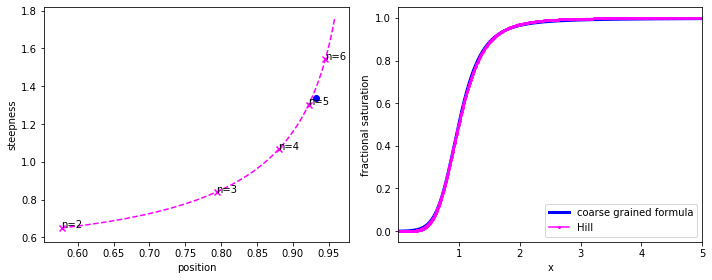

[7.64400312e-04 1.65629117e+01 6.06818074e-01 3.41954255e-03
 2.60029101e+02 1.53730682e-04]
[16.40372101 12.39406648 25.32186261 16.45619717 36.77925755 37.50219766]
[0.00010359 0.00011828 0.00010322 0.00011715 0.00010848 0.00034564]
[2.56623982e-02 2.03911446e-01 6.86753648e-01 1.59287738e-04
 2.51521507e-02 2.96423804e-04]
[1.00000000e+00 1.53506429e-06 9.29348177e+05 2.83753361e+01]
effective parameters
0.00010436832757045797,0.000142321914847025,0.00012483703777854268,0.00011715528119113673,0.00038903498027623254,0.00034564257541297834,12.520451737879387,42.21014204179185,1.0393454055119962,6.054018829044178,1.0270978882711825,850.0391883954006,4.565609918037408,83699.32948156031,0.9398552528882153,1.254860012204476,3506.998559013424,1.0095333990640736,21.295129456222543,1.0251539826666376,0.6173474697760931,80.24897213973207,704.781750655554,7.3576414873633755,2620.9945272148957,5940.5960183504985,9.481767459221293,5695.295275665766,169.14982557291643,3860.3433477079693,4318.3415

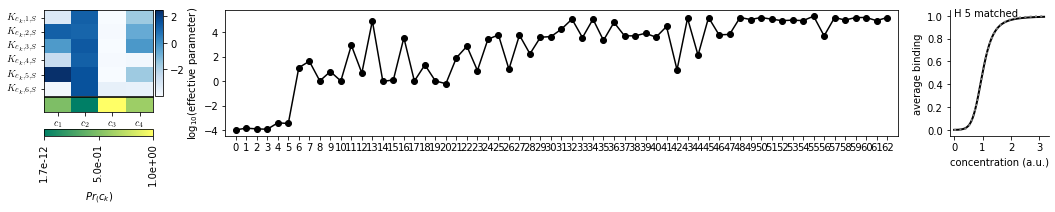

253 j=47
final_nt5_plim4_plimc6_c4_beta0.25_696.out
error 1.9956263095446658
0.0064679595947579015,1267.578853917257,11.213974696411311,0.028958066135156665,1.8927175570583863,0.00010174227017801031,0.0017135105624039016,0.0004655674600628821,710.0690132773436,0.4612542369002971,0.006575082191697417,0.08046620560668447,0.0005226150049952262,0.00010266931597499517,0.000978237028954277,0.00012711735814382812,0.0011134133620341767,0.00010287389519077101,46.54331288184062,30.389805527331184,74.48174189518184,50.27606200753986,40.48386439617931,40.425439183715994,0.05624920751101805,1000000.0,2.141449677391538e-06
0.9317303929480663 1.3463633502257564
function evaluated between 0.01 and 10.00


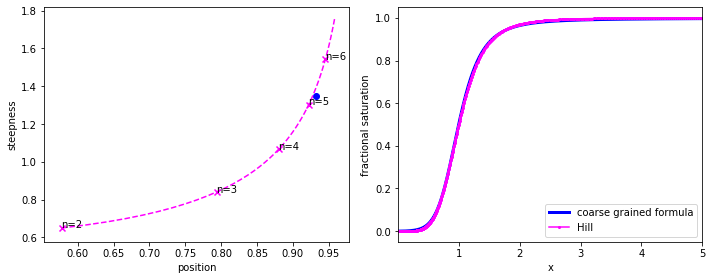

[6.46795959e-03 1.26757885e+03 1.12139747e+01 2.89580661e-02
 1.89271756e+00 1.01742270e-04]
[1.71351056e-03 4.65567460e-04 7.10069013e+02 4.61254237e-01
 6.57508219e-03 8.04662056e-02]
[0.00052262 0.00010267 0.00097824 0.00012712 0.00111341 0.00010287]
[46.54331288 30.38980553 74.4817419  50.27606201 40.4838644  40.42543918]
[1.00000000e+00 5.62492075e-02 1.00000000e+06 2.14144968e-06]
effective parameters
0.0005226211169893347,0.0013702468138332465,0.00102939089512905,0.0001271722347330623,0.0011153053580857672,0.00010287850099682622,11.527853620997654,1.226129355861318,1.0784384711495179,1.0262170563038002,1.0750379620126223,10077.63813739039,210.7396251540792,1569.9611925157922,1.0084570258400347,144.22095831129286,19.670244678056857,31.369572233835747,1.416232853766609,1.4919830040458144,1.0307395056573219,12.406272846304532,20.305536370956478,12.473238278109994,1659.3866077661476,41.244533069798514,37.181952001653734,176.05617823331144,1936.498403783298,19857.990938104806,2640.03

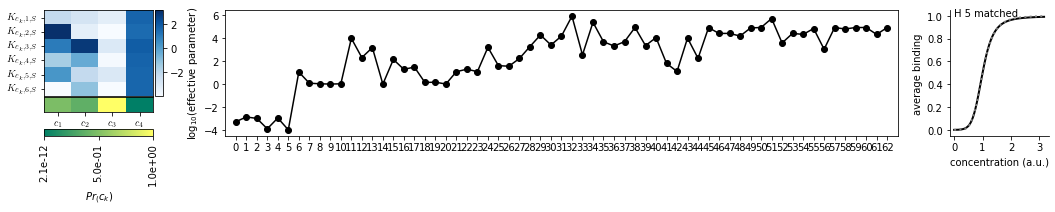

206 j=48
final_nt5_plim4_plimc6_c4_beta0.25_309.out
error 1.9956507521070115
0.000741634139123661,0.00011214290596753019,0.970599139339512,4.555429350100856,0.00016342649584308292,38.45021957876818,6.460317542938668,7.918972325722614,5.299044335249361,6.902388248877282,6.00116449482804,62.242774471061715,0.00010366682171840353,0.00011197518554628179,0.00012455472985791786,0.00012955217228155326,0.0001042053291978645,0.0005814917840269915,0.00011446764921263354,61.10010380604796,10.871732143000584,1289.893017702404,0.0015884703976610257,0.00014194697947146856,1.033155863165069e-06,723185.4293006471,1.3743682164659889e-06
0.9307833144781841 1.3457655652273006
function evaluated between 0.01 and 10.00


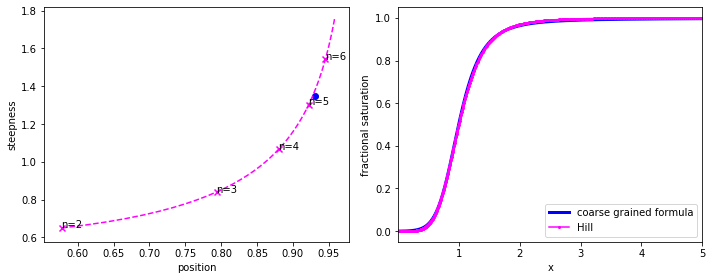

[7.41634139e-04 1.12142906e-04 9.70599139e-01 4.55542935e+00
 1.63426496e-04 3.84502196e+01]
[ 6.46031754  7.91897233  5.29904434  6.90238825  6.00116449 62.24277447]
[0.00010367 0.00011198 0.00012455 0.00012955 0.00010421 0.00058149]
[1.14467649e-04 6.11001038e+01 1.08717321e+01 1.28989302e+03
 1.58847040e-03 1.41946979e-04]
[1.00000000e+00 1.03315586e-06 7.23185429e+05 1.37436822e-06]
effective parameters
0.0001036677131092178,0.00011197531320772629,0.00012589670056075157,0.00013585356225815647,0.00010420541966310906,0.000634658852481693,1.006296042982398,1.0693425594628698,1.2898566763096455,1.0051317571957976,1.524263374774349,1.0938153196409428,10.851077481924412,1.0058330387426355,1.0100329949324025,359.9697301062588,1.0095227973038623,646.7654854225166,1.0307870495127542,2809.9763187573685,1.0556774366610664,243.34140943327273,30.600421511905964,361.48303358805447,612.8451522757871,7.640475149189704,214.86427710089723,7.7134773151467355,254.1448253263572,7.309893440466044,478.06

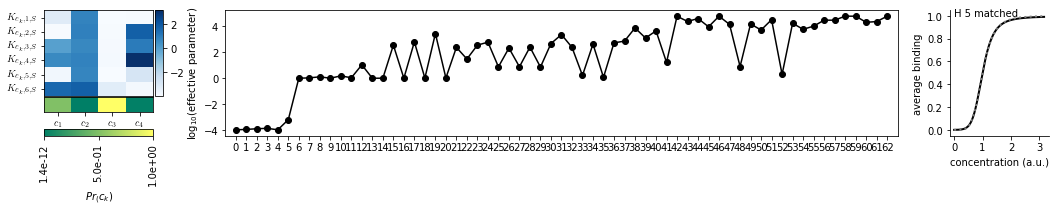

211 j=49
final_nt5_plim4_plimc6_c4_beta0.25_354.out
error 1.9956802526731265
1.8174490707535493,0.0013839478525897524,0.004775477042701994,0.0007625397325202083,33.498195572854364,1.0983536842252144,0.0001,0.0001,0.0001352491711163256,0.0001,0.00014366156121790093,0.00011218823813402143,1.4149817023529514,0.0001,0.0019529829085562188,0.015969953813263545,9.756507776351253,0.00011025961373417419,5.0626159569060665,8.606208884367518,7.023587575948176,8.397455401996806,19.095638061836997,3.4172221385555903,479235.63989419537,5.747062134551169e-06,1.0672177123373933e-06
0.9300703322983002 1.3442774739408427
function evaluated between 0.01 and 10.00


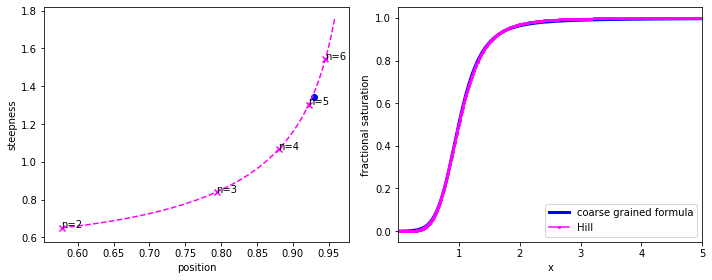

[1.81744907e+00 1.38394785e-03 4.77547704e-03 7.62539733e-04
 3.34981956e+01 1.09835368e+00]
[0.0001     0.0001     0.00013525 0.0001     0.00014366 0.00011219]
[1.41498170e+00 1.00000000e-04 1.95298291e-03 1.59699538e-02
 9.75650778e+00 1.10259614e-04]
[ 5.06261596  8.60620888  7.02358758  8.3974554  19.09563806  3.41722214]
[1.00000000e+00 4.79235640e+05 5.74706213e-06 1.06721771e-06]
effective parameters
0.0001037922029612525,0.00010000269831715015,0.00013525886931859974,0.0001000014013802131,0.00021356049124898765,0.00011447989334428062,1.4784399566723183,2.259061284400904,1.251209982633853,5731.897549435387,351.50591619716454,1.0108704637488566,1.0162704065824708,5.219400401333669,1.2627324023377218,1.0101844129944393,12.238834677187322,1.6901898733472793,3.185278102610207,1.1382061682074947,3140.909814724181,498.8016886481981,777.14830108741,15356.481913708365,4063.722639019622,479.55631929842554,16574.546840066803,7422.951810785342,13976.71821322789,2588.567937373572,17506.84276

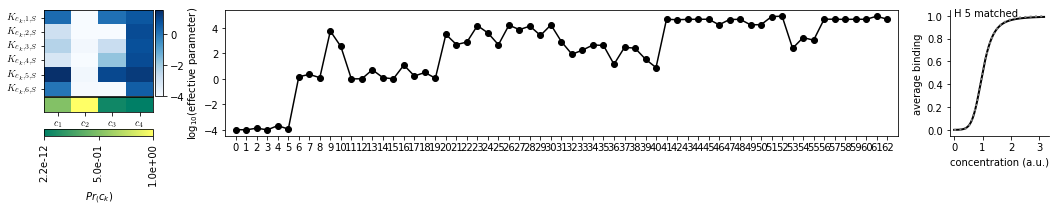

matching Hill 6
parameter limit is 4
#new combi------
n=6 c=4 plim=4
869
603 j=0
final_nt6_plim4_plimc6_c4_beta0.75_1205.out
error 1.960841297018642
0.0001,0.0002100965191524001,1.479423691130597,0.0003716405769156902,0.0014894119906182887,155.32029336082405,0.573049726215558,0.00016908282315826747,0.00012015347614301014,0.00010781093412675337,0.00034258329952899,0.00030620959104299384,48.099802091513595,54.189031995170694,124.6533881889366,61.81636256064008,27.620426666385207,46.68097007330773,0.00013355776881726974,0.00226145738382056,0.0037671102426147765,0.0016520321677908336,0.00010871606890859184,0.0018588425432466572,0.007543544003481464,1e-06,300120.71430329
0.9416622621905679 1.5053186664842402
function evaluated between 0.01 and 10.00


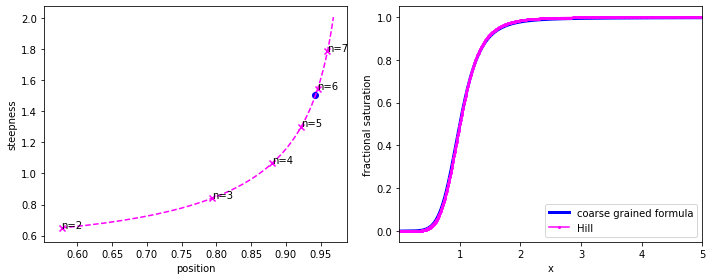

[1.00000000e-04 2.10096519e-04 1.47942369e+00 3.71640577e-04
 1.48941199e-03 1.55320293e+02]
[5.73049726e-01 1.69082823e-04 1.20153476e-04 1.07810934e-04
 3.42583300e-04 3.06209591e-04]
[ 48.09980209  54.189032   124.65338819  61.81636256  27.62042667
  46.68097007]
[0.00013356 0.00226146 0.00376711 0.00165203 0.00010872 0.00185884]
[1.00000000e+00 7.54354400e-03 1.00000000e-06 3.00120714e+05]
effective parameters
0.00013357221748896202,0.0022614506766818654,0.003772027426584147,0.0016520280687013923,0.00010872076727037227,0.0023763607972695556,1.0286508007405653,1.0392182733814062,1.0447953886277985,1.3050421287890752,0.9687619211998706,1.0014559207021345,1.0029896938127454,1.0202442254928068,0.8040229689728192,1.003109714752961,1.0445264542544332,86.19875159251293,1.0316404423975665,0.8336627048514553,3.7822777522439117,949.7463871391886,1073.611136453034,7160.233300676093,703.4377677540854,1480.0923765829145,9644.973232782748,9.787109534824657,11057.153371071083,1058.9022916632166,1

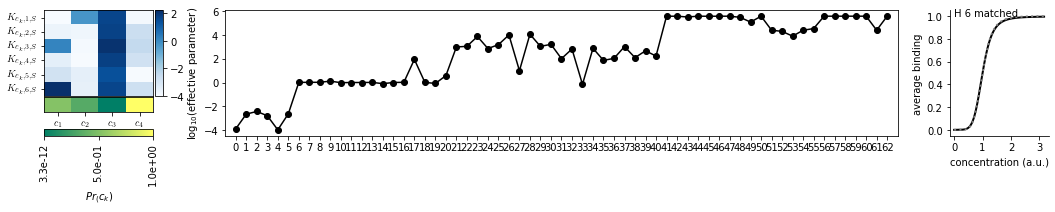

736 j=1
final_nt6_plim4_plimc6_c4_beta0.75_2285.out
error 1.961006853844896
0.00013276262390621952,0.0001,0.00010249243566344089,1.3035009798675492,0.008383988976691471,0.008185692316520402,0.0020370619630407103,0.0001669062098593663,0.00010476404572448961,0.0002078856187238588,0.0001,0.0003790438064665709,42.76799733638062,27.96523919425793,33.36032935146998,20.52810093242787,69.95504600907556,44.35352271857678,0.6882747886545345,0.0007410276346967992,0.00010855599487095638,0.010119266017822325,0.0001,0.0388618922491244,100877.83309171966,1e-06,1.3014978715192336
0.9408867815753714 1.5058062212366103
function evaluated between 0.01 and 10.00


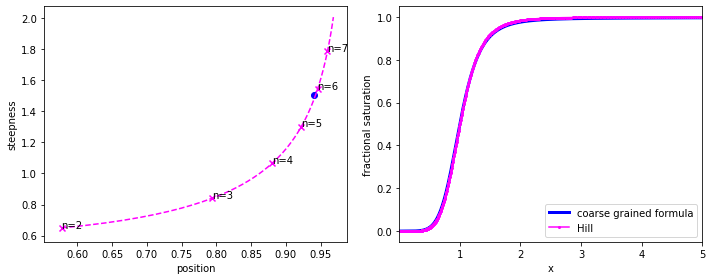

[1.32762624e-04 1.00000000e-04 1.02492436e-04 1.30350098e+00
 8.38398898e-03 8.18569232e-03]
[0.00203706 0.00016691 0.00010476 0.00020789 0.0001     0.00037904]
[42.76799734 27.96523919 33.36032935 20.52810093 69.95504601 44.35352272]
[6.88274789e-01 7.41027635e-04 1.08555995e-04 1.01192660e-02
 1.00000000e-04 3.88618922e-02]
[1.00000000e+00 1.00877833e+05 1.00000000e-06 1.30149787e+00]
effective parameters
0.002045896957273058,0.00016691323083210512,0.00010476440281985251,0.00022093291756001516,0.00010008281059453978,0.00037961811524626253,1.0496046153252832,1.0661385985608733,1.1587034243714909,1.1440657965515515,1.462694352400668,1.5288544260148926,1.132861964110142,2.160527375150623,1.1984593244852257,1.2920402922898897,3.20630221598593,1.3688396322258911,6.483849687073307,2.3687174431261613,1.8263976579351477,7231.820305739428,2849.140131994153,11232.468460612905,3387.136386850373,4746.129580597901,14385.024351708691,5633.219097121843,2075.8278869895676,958.7195181828736,9266.4165

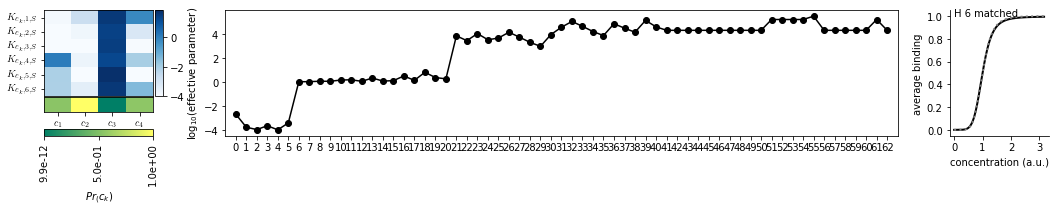

505 j=2
final_nt6_plim4_plimc6_c4_beta0.5_403.out
error 1.962913102619528
0.0036901166551534755,0.02417425724529637,0.00030611983909626864,64.18754917122774,1.8933078907268064,0.0012022963709896089,0.0022144936023330416,3.0474345789742348,14.310047142110442,0.0009046531039897716,0.005645009092644432,0.0005723496911775685,18.59868517843019,250.27193058250978,21.378034760457872,22.249735221573996,20.69007617836303,29.15175211698594,0.00012815018424865442,0.00011232208397586761,0.0003282546681355102,0.0002460626132169359,0.001874304642134451,0.002262030396831458,1.0864111756914743,1.2504876674122575e-06,851318.0077719294
0.9415665056479766 1.5052968205383164
function evaluated between 0.01 and 10.00


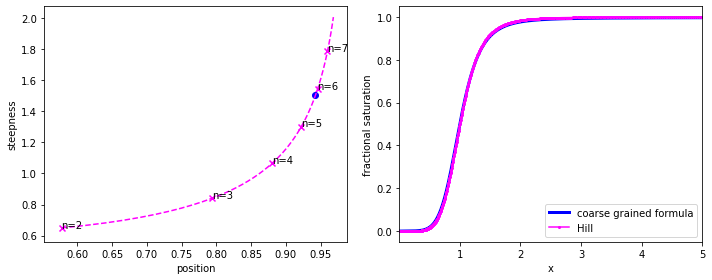

[3.69011666e-03 2.41742572e-02 3.06119839e-04 6.41875492e+01
 1.89330789e+00 1.20229637e-03]
[2.21449360e-03 3.04743458e+00 1.43100471e+01 9.04653104e-04
 5.64500909e-03 5.72349691e-04]
[ 18.59868518 250.27193058  21.37803476  22.24973522  20.69007618
  29.15175212]
[0.00012815 0.00011232 0.00032825 0.00024606 0.0018743  0.00226203]
[1.00000000e+00 1.08641118e+00 1.25048767e-06 8.51318008e+05]
effective parameters
0.0001281570581032513,0.00011623955271128816,0.0003465160051158674,0.0003214608645561033,0.0018765312499695419,0.002262027038551805,2.01036259505129,1.8710772544510283,7.533700896931148,1.0352989102556478,1.0027161722120672,1382.7655549436956,49.83126750324969,1.347138320916639,1.0156504683920131,1.086897435179015,1.1067559907836118,0.9618023635781091,237.40953500594964,0.8914263480704219,0.9996520903763615,37.743978323956796,665.7315566443467,3763.7336404826665,5824.9071231629505,846.0027135054947,134.37352625632394,177.44305512850664,29.38928569469864,218.19205626668088,31.

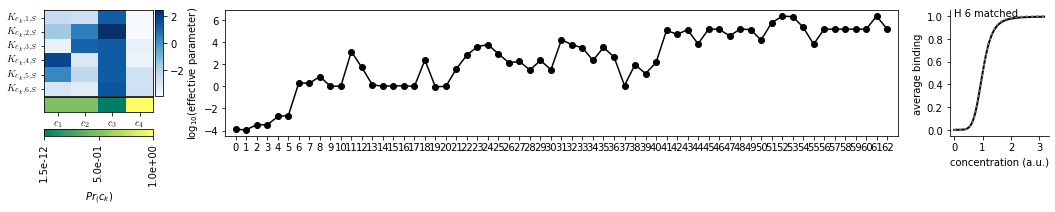

173 j=3
final_nt6_plim4_plimc6_c4_beta0.25_2400.out
error 1.9631908406120941
0.00010674041726498764,2.6265372843422523,0.17094791666137332,0.04964336462552477,0.2469216976692189,3.7631898967746995,0.041161831186513724,0.00027009882107077097,0.02487026252286606,0.00596397113782872,0.0006269778597478434,0.025482740994353766,1114.1414777312996,850.307447497073,940.4890003773277,968.9831394868431,1154.3466305514894,905.5148783554694,0.0009224432426334903,0.03923708148574292,0.030996619726247118,12.083822158981288,0.028206529523227473,173.75267814462964,917510.704529949,1.2684871760826918e-05,0.00010406276448872278
0.9409429238586521 1.5057400501865508
function evaluated between 0.01 and 10.00


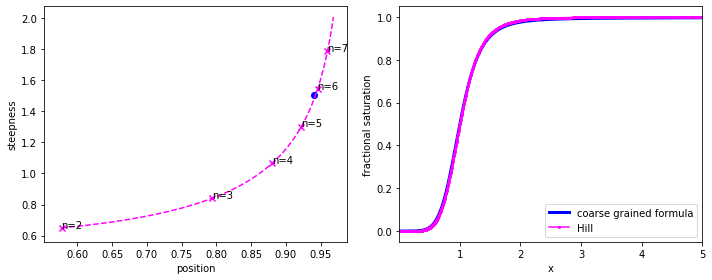

[1.06740417e-04 2.62653728e+00 1.70947917e-01 4.96433646e-02
 2.46921698e-01 3.76318990e+00]
[0.04116183 0.0002701  0.02487026 0.00596397 0.00062698 0.02548274]
[1114.14147773  850.3074475   940.48900038  968.98313949 1154.34663055
  905.51487836]
[9.22443243e-04 3.92370815e-02 3.09966197e-02 1.20838222e+01
 2.82065295e-02 1.73752678e+02]
[1.00000000e+00 9.17510705e+05 1.26848718e-05 1.04062764e-04]
effective parameters
0.04116180183859541,0.00027297296127484733,0.024870434736427752,0.005964033510439034,0.0006272622597391628,0.025486846960180456,2.155170920667745,1.014143836750557,1.060788213388953,1.6882115485536464,1.0131343105079276,2.690096295285514,8.073705288538404,84.37063776505019,4.067920853662453,1.0849858732062583,1.9646134961265431,1.019512792142817,5.136804639658154,1.082538490673539,1.9667110330881195,16386.607532145,23457.531436596717,25425.689345248513,10181.08787151012,2119.979628174687,13256.149810096938,494.1290395010956,21781.836313909746,1996.3362327738382,12441.25

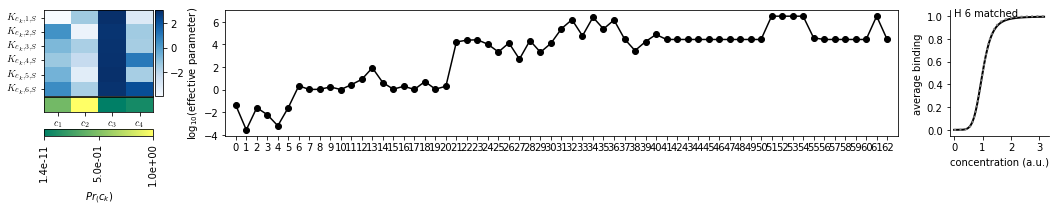

612 j=4
final_nt6_plim4_plimc6_c4_beta0.75_1277.out
error 1.9660210507578553
1.96527261085348,0.09832191794323958,38.12899454363992,0.00011259379440179078,0.0014220178972808295,29.301797575084755,0.36323781782318293,0.0015830083081737577,7.412102369338602,1245.9399539283,0.12906729850131252,0.000196886465987101,117.7534964044714,267.54674939796337,39.11332777755025,130.61522518677478,59.16738576428701,202.84051510122438,0.00018138647997733578,0.004395018996378823,0.010805219228737804,0.0005191086392228598,0.0014172199964259222,0.00011851097408440874,0.0020591051943662916,1.5168022660331529e-06,935746.9451595293
0.9415632816885722 1.5050580666509485
function evaluated between 0.01 and 10.00


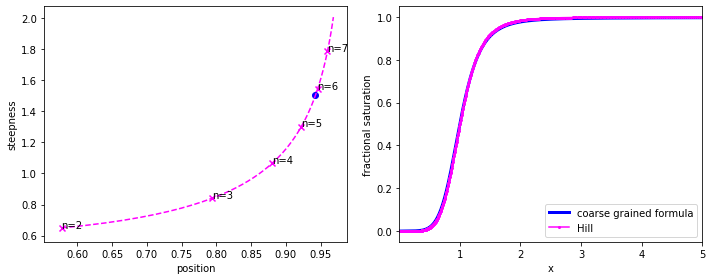

[1.96527261e+00 9.83219179e-02 3.81289945e+01 1.12593794e-04
 1.42201790e-03 2.93017976e+01]
[3.63237818e-01 1.58300831e-03 7.41210237e+00 1.24593995e+03
 1.29067299e-01 1.96886466e-04]
[117.7534964  267.5467494   39.11332778 130.61522519  59.16738576
 202.8405151 ]
[0.00018139 0.00439502 0.01080522 0.00051911 0.00141722 0.00011851]
[1.00000000e+00 2.05910519e-03 1.51680227e-06 9.35746945e+05]
effective parameters
0.0001834874916975246,0.004395119800145319,0.010845971109410261,0.0005218500953719875,0.0014172203783513293,0.0001498249480891772,1.307908369489457,41.23030180354511,11.646724506561826,1.0438590627667497,2240.744323726258,1.0806193185311317,1.0213173731460088,1.0041192797242593,5.60009617037911,4.583691007475477,1.0003919383372126,735.5435031117926,1.4901482147126728,1.3881117565613201,1.0923243805214113,1045.2489085680306,15523.326607340048,2634.0902661094137,24251.302412668378,1757.6013176584866,198.17017940664107,10705.978398741427,7930.884218288915,254298.6393170064,55884

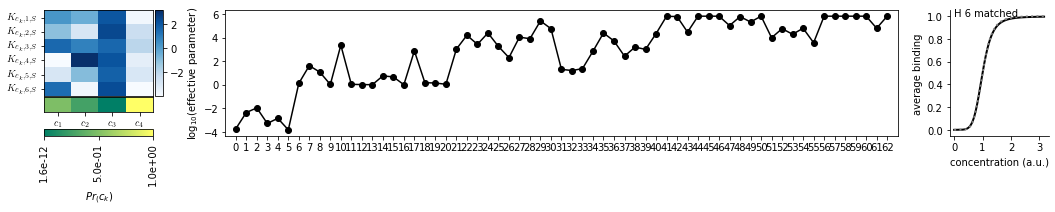

516 j=5
final_nt6_plim4_plimc6_c4_beta0.5_493.out
error 1.9667160492920839
0.00024523318691034975,0.003539499490441076,0.1191488863965725,16.707509038595312,1.8372417760964859,543.1816333343983,1036.0239541255123,991.5656798911339,870.6146588819761,919.3049495433357,1053.9107555620244,752.5687430840261,0.03697444547539888,0.01251200863163373,0.0960620120995105,0.010773734194214284,0.08237785857556404,0.0037912770649279693,0.0001296867793074762,0.00011566322511044299,0.031743636843903265,123.55343975389307,1.1895065373666525,0.00013867663670625885,4.008821608378235e-06,979449.3966440667,0.18381411917685567
0.94192958905303 1.505523692761452
function evaluated between 0.01 and 10.00


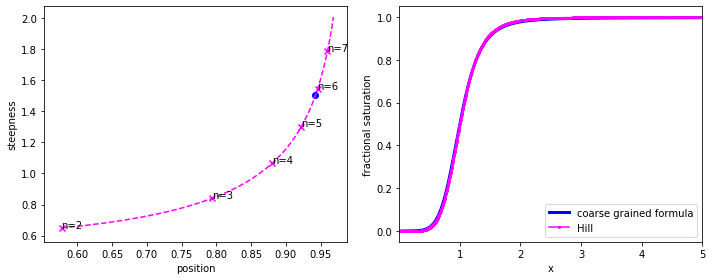

[2.45233187e-04 3.53949949e-03 1.19148886e-01 1.67075090e+01
 1.83724178e+00 5.43181633e+02]
[1036.02395413  991.56567989  870.61465888  919.30494954 1053.91075556
  752.56874308]
[0.03697445 0.01251201 0.09606201 0.01077373 0.08237786 0.00379128]
[1.29686779e-04 1.15663225e-04 3.17436368e-02 1.23553440e+02
 1.18950654e+00 1.38676637e-04]
[1.00000000e+00 4.00882161e-06 9.79449397e+05 1.83814119e-01]
effective parameters
0.03697440530112879,0.012512001202802879,0.09606202716306025,0.01081397033038292,0.08237986234629993,0.004345853475817553,1.009089084451507,1.0010391160928849,1.0060464912055633,1.0014429022257016,0.8930955578531988,1.0029392879435834,1.024318910279161,1.0041311800473813,0.9646580340894746,1.0020963734553447,1.0004780089206569,1.0370918336679613,1.0668453927423907,198.08728077843216,3.7274205885928504,83.12617559256564,755.2598425141912,116.79086904143722,1632.435195695537,89.16849880962361,14.290332559546956,174.39471576747192,117.84599834934009,8.53397425466677,68.402

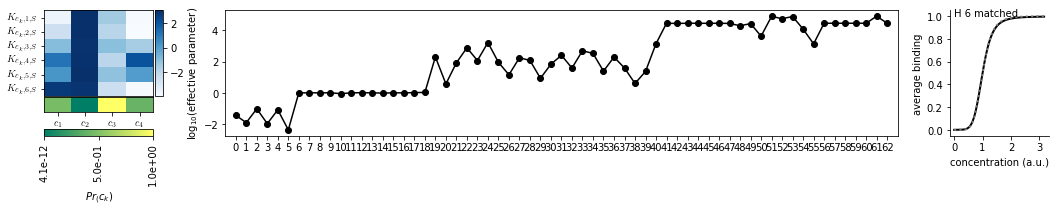

89 j=6
final_nt6_plim4_plimc6_c4_beta0.25_1725.out
error 1.967611510874369
12.36694099816293,0.00010441030982450169,343.7359905792895,0.27354279228183837,0.0007143146210533542,0.00017211081021482693,0.03161994221897344,0.0001181636328793177,0.002754017934006181,0.00014545993309592414,0.04217592652851513,0.00010746639541131699,499.7403797860612,418.5405567864094,477.64113518847495,589.8423086501134,490.03609076074116,440.3311190615398,0.17077375944591505,0.0006783868856227207,184.06248690983023,3.0108946331576742,4.212012040866389,0.0031316163092130834,1000000.0,9.764950018713067e-06,7.353736482332737e-06
0.9412480315130245 1.505596534655234
function evaluated between 0.01 and 10.00


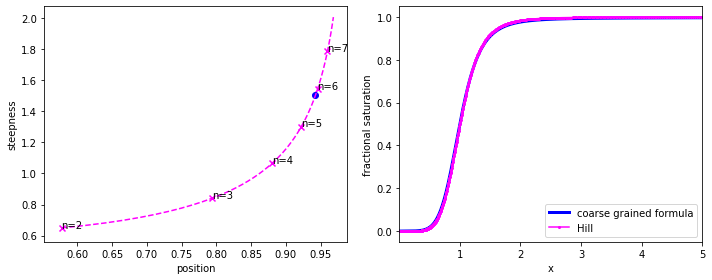

[1.23669410e+01 1.04410310e-04 3.43735991e+02 2.73542792e-01
 7.14314621e-04 1.72110810e-04]
[0.03161994 0.00011816 0.00275402 0.00014546 0.04217593 0.00010747]
[499.74037979 418.54055679 477.64113519 589.84230865 490.03609076
 440.33111906]
[1.70773759e-01 6.78386886e-04 1.84062487e+02 3.01089463e+00
 4.21201204e+00 3.13161631e-03]
[1.00000000e+00 1.00000000e+06 9.76495002e-06 7.35373648e-06]
effective parameters
0.03163228240834336,0.00011816770615250502,0.0030977568444644334,0.00014573911206858763,0.04217588988236983,0.00010747075988392598,1.5463344111818766,44.29442148758923,2.355871372498054,1.001408831703851,1.6322751490943488,6.319942618698392,140.98039974552773,1.4018229796027086,142.70891195114763,215.2599473374876,0.90845298174327,7.235690569326219,1.457322049595498,162.92774794513113,1.4648196104711602,13337.229666909509,15686.412571411045,4529.61464119698,15687.740780525508,825.5019294555274,306.01533924490843,13479.084893889214,4978.655240433519,15701.374738091705,5014.311

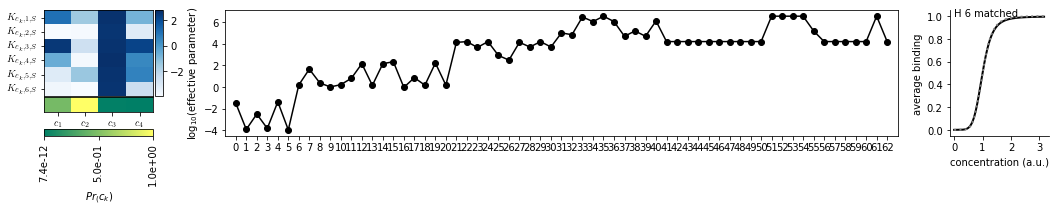

248 j=7
final_nt6_plim4_plimc6_c4_beta0.25_663.out
error 1.9679487006451983
3.1279879330315303,32.771421679061184,0.0017917020813306174,0.002338967875352697,280.99870028206453,0.051480115204204945,0.0019847580866159606,0.0026102962217800026,0.00040143249815504306,0.03814960086507829,0.00518126680788583,0.0001025597160535355,0.00012977847602169303,0.0013489479933965788,205.51779073063767,3453.4327268646744,25.22894761068178,0.0006372697490809429,317.1092993586119,97.30931274418444,1504.4161413036522,432.99347068806037,461.3897283576071,227.06682224424964,979547.1194484818,1.1687236781061163e-05,1.1382569218200123e-06
0.9414526278078904 1.5053206243979853
function evaluated between 0.01 and 10.00


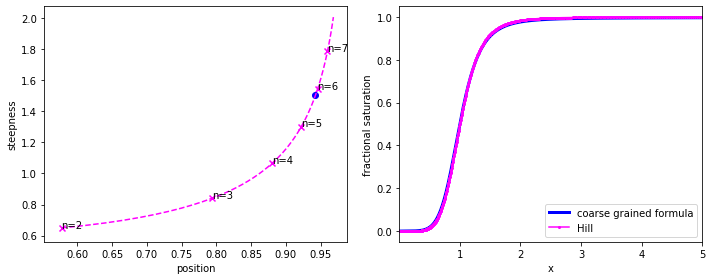

[3.12798793e+00 3.27714217e+01 1.79170208e-03 2.33896788e-03
 2.80998700e+02 5.14801152e-02]
[0.00198476 0.0026103  0.00040143 0.0381496  0.00518127 0.00010256]
[1.29778476e-04 1.34894799e-03 2.05517791e+02 3.45343273e+03
 2.52289476e+01 6.37269749e-04]
[ 317.10929936   97.30931274 1504.4161413   432.99347069  461.38972836
  227.06682224]
[1.00000000e+00 9.79547119e+05 1.16872368e-05 1.13825692e-06]
effective parameters
0.001987949725740928,0.0026437493227324566,0.0004014381176968444,0.03814960601318834,0.005468127997655731,0.00010261243017852531,20.904308702840893,1.7002015894204512,1.0005957321542103,83.50832333227018,2.2139437450357624,1.2041017560812115,0.9886070564614522,651.2408327294764,7.430242098223054,1.6023508618728866,1.577299396209148,10.638257064583353,0.956850786506617,1.0287082214064607,27.483627964612776,21308.948132719976,80.56048712912164,1572.0906593137609,3376.4881954352613,4921.054311288245,37394.76882683048,144494.73045412038,191.79978914762816,4526.5631320455495

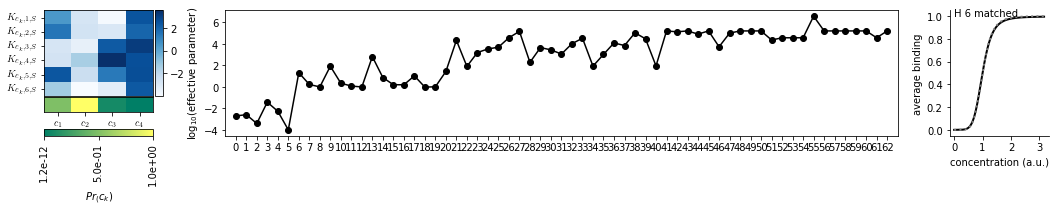

176 j=8
final_nt6_plim4_plimc6_c4_beta0.25_2427.out
error 1.968058685449222
0.0052089666739701754,0.030396328983817774,142.6811803457992,0.4809295719846604,0.0001,0.0001,13.168219919732623,19.5219047483434,25.76243110510566,22.410223258999356,25.710411408739816,19.72448965206373,0.0001,23.16397210352193,1.8608400775872143,6.6632312176069775,0.0021082421124587543,0.1610442847696002,0.0003402856122977304,0.00032932078040509257,0.0003952117898144315,0.00011655467984570371,0.00013571678201265678,0.00043616680001908737,1.1884583644362325e-05,1.2868643788106381e-06,998344.3266922802
0.9409429606809401 1.5054638386443975
function evaluated between 0.01 and 10.00


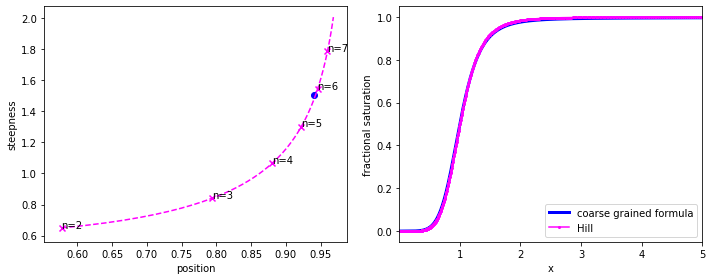

[5.20896667e-03 3.03963290e-02 1.42681180e+02 4.80929572e-01
 1.00000000e-04 1.00000000e-04]
[13.16821992 19.52190475 25.76243111 22.41022326 25.71041141 19.72448965]
[1.00000000e-04 2.31639721e+01 1.86084008e+00 6.66323122e+00
 2.10824211e-03 1.61044285e-01]
[0.00034029 0.00032932 0.00039521 0.00011655 0.00013572 0.00043617]
[1.00000000e+00 1.18845836e-05 1.28686438e-06 9.98344327e+05]
effective parameters
0.000340290645802055,0.00032935115949502767,0.0005381293654093099,0.00011703656513504034,0.00013571705230157498,0.00043616669830282446,1.0286121473475267,4.821836429911556,1.1470800928384723,1.087261477873742,1.0208200774154332,25.279450219638115,1.5159375051742934,1.1336463953571807,1.03187111985718,1092.1783953066522,1.0380676956710553,0.8210814973079212,1.4307332293663877,1.099934204709432,1.1019811863447895,66.58128938767987,3453.440975708799,4563.775370262436,1197.6300889205227,19.162732076118356,4028.2542880074034,1216.6691093428929,11680.135740993583,3627.4497595359667,3582.1

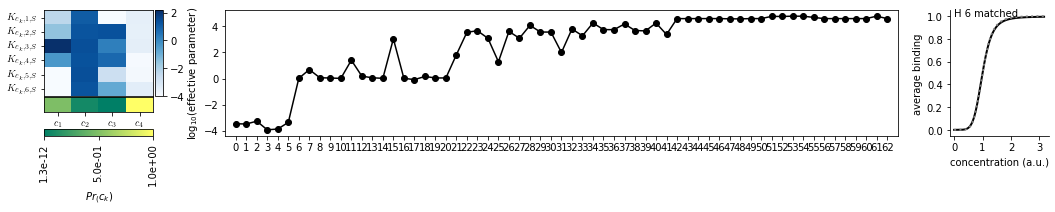

109 j=9
final_nt6_plim4_plimc6_c4_beta0.25_1887.out
error 1.9680609782056844
2.3431585329466578,0.004664570942100212,0.2248397743112112,32.48921584228814,0.003942440576513855,0.014205195776388787,0.0004414356280076714,0.0018320418534605002,0.012379435573610043,19.86316301165756,11.679034339157967,0.004240206820473735,89.93511358883806,60.03003552944622,58.24976675014046,45.11950732079278,17.899871019716294,231.15285520207684,0.0014804512166219726,0.004709625684871725,0.0004435008507860581,0.0006281317634412358,0.0038168781429302975,0.0002054301105439499,0.002863749406894221,1.026536391908469e-06,999520.9867441317
0.9417541686961041 1.5055248254963596
function evaluated between 0.01 and 10.00


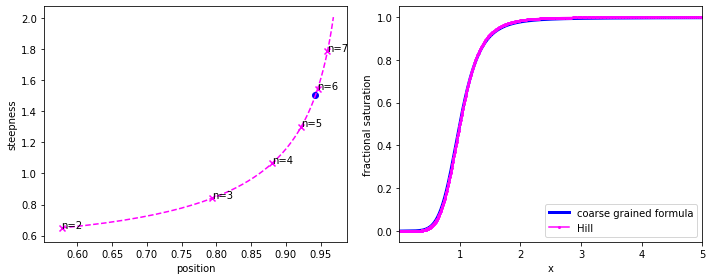

[2.34315853e+00 4.66457094e-03 2.24839774e-01 3.24892158e+01
 3.94244058e-03 1.42051958e-02]
[4.41435628e-04 1.83204185e-03 1.23794356e-02 1.98631630e+01
 1.16790343e+01 4.24020682e-03]
[ 89.93511359  60.03003553  58.24976675  45.11950732  17.89987102
 231.1528552 ]
[0.00148045 0.00470963 0.0004435  0.00062813 0.00381688 0.00020543]
[1.00000000e+00 2.86374941e-03 1.02653639e-06 9.99520987e+05]
effective parameters
0.0014827941039728685,0.004709625693198465,0.000443725448396086,0.0006606928433249432,0.003816911737819467,0.00020544436596505166,1.0007787964947064,1.807191915287914,78.6977106759148,1.0003378785357593,1.1777517913022204,1.0017134431329555,1.0003706268855472,1.000056017670674,1.0147270080868696,25.890914931285018,1.0008845079406512,1.1861711329206108,1.265416456996722,4.433074534395776,1.0055922681963607,105.83994213804948,132.12296244944224,4.723255962993051,881.4670743851163,1543.13198837432,40.13839482766417,7804.0773527309875,80.03550630147916,2292.4902912483153,327.9572

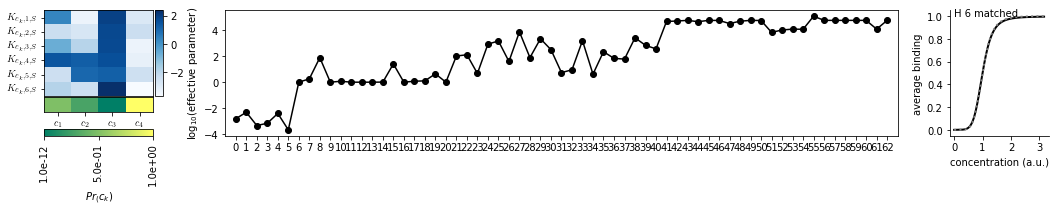

865 j=10
final_nt6_plim4_plimc6_c4_beta0.75_98.out
error 1.968481368460768
2.775247438140337,0.23316078131997664,1.7154572579134604,0.004925926973129044,0.0004229772929973922,0.5512184947643844,0.00011184360804244453,0.0024819336297342313,0.000915396083212752,0.0001,0.0017159099416479728,0.002486019975151244,70.06853562727643,43.10479269852658,50.803457804989485,58.604249892846006,26.589735406612885,38.916598463087,0.00011467900966069179,3.2650520397182357,4.3885538194498155,0.00017601156892806,0.00010599103792310224,0.0004966215247848776,153474.56036588168,1e-06,1.0410131449454259e-06
0.9413609637272448 1.505527413114837
function evaluated between 0.01 and 10.00


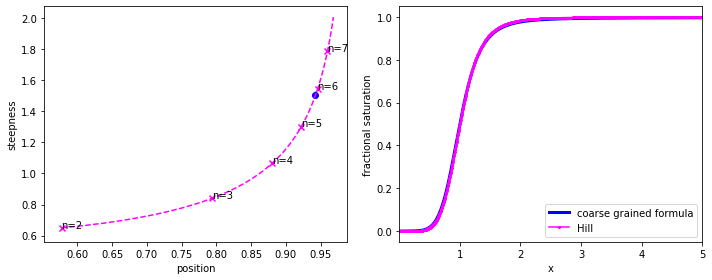

[2.77524744e+00 2.33160781e-01 1.71545726e+00 4.92592697e-03
 4.22977293e-04 5.51218495e-01]
[0.00011184 0.00248193 0.0009154  0.0001     0.00171591 0.00248602]
[70.06853563 43.1047927  50.8034578  58.60424989 26.58973541 38.91659846]
[1.14679010e-04 3.26505204e+00 4.38855382e+00 1.76011569e-04
 1.05991038e-04 4.96621525e-04]
[1.00000000e+00 1.53474560e+05 1.00000000e-06 1.04101314e-06]
effective parameters
0.00012992600276578748,0.0024834369658082367,0.0009265678764797164,0.00010003182611739902,0.0017159016905212,0.0024895956023424076,13.988074578413817,258.7161974418006,9.772736963039506,0.9495830612655886,31.729455149644764,2.1261533359493017,1.0954500432947603,1.001296231793222,1.1351641012198004,1.7909579971140381,0.9964508057567325,3.6630067629769085,1.0589117527022287,1.1289502195939323,1.000495978473099,12951.515128996445,33206.26177835718,947.9612631742224,3389.2380991656178,70109.85176312337,3060.788431703415,16397.359448829942,30128.34040510488,29849.14595923035,859.19771196

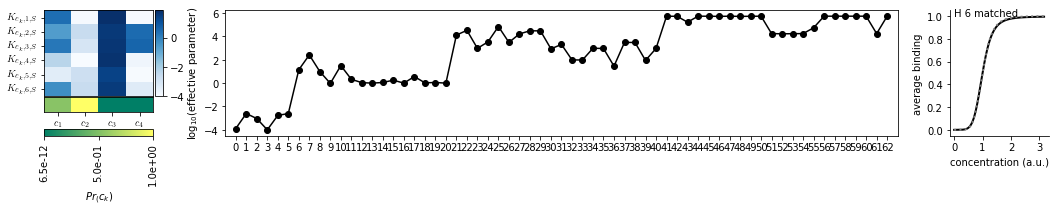

751 j=11
final_nt6_plim4_plimc6_c4_beta0.75_2411.out
error 1.9686766354320477
0.0001,0.17676420032226386,0.00013061508157304996,126.19599673345168,2.6831927379236853,0.17108725131510708,0.009109854487003261,101.22845748486738,0.00024367846679445058,0.000136399420438803,0.00033424821672321456,0.007491056536373135,123.29558400528428,78.30804897393767,68.05790758791564,44.48620341481694,45.47934807548229,77.10783046456159,0.00019119076026616788,0.00020943796840954814,0.0037949997882580078,0.01045553286747052,0.00010975623061682247,0.0001018330682777418,0.3981149858778752,1.813928850965743e-06,529940.1856542875
0.9417941659026612 1.5052075504647755
function evaluated between 0.01 and 10.00


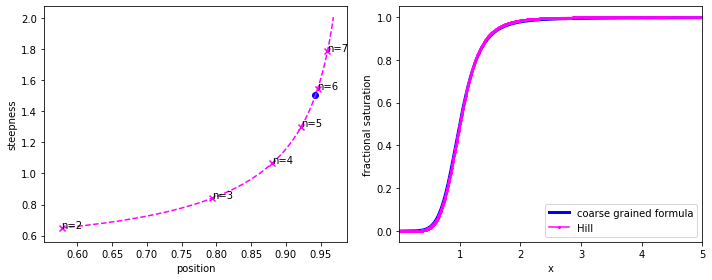

[1.00000000e-04 1.76764200e-01 1.30615082e-04 1.26195997e+02
 2.68319274e+00 1.71087251e-01]
[9.10985449e-03 1.01228457e+02 2.43678467e-04 1.36399420e-04
 3.34248217e-04 7.49105654e-03]
[123.29558401  78.30804897  68.05790759  44.48620341  45.47934808
  77.10783046]
[0.00019119 0.00020944 0.003795   0.01045553 0.00010976 0.00010183]
[1.00000000e+00 3.98114986e-01 1.81392885e-06 5.29940186e+05]
effective parameters
0.00019119771030010817,0.00028581842351706985,0.003794990438598012,0.010693637438877896,0.00011481953369322062,0.00010216153287102472,14.015245432950296,1.0395502920139386,0.9985256245226082,1.8533225662016533,2.6669971963867805,0.766708311209353,14.49571791016221,29.11814874604703,22.90220107909892,0.9787556243946586,0.9817338891738763,1.0432279311526795,521.3293833148853,38.277910949823905,75.824216097014,14147.279676360486,174.11100382260935,8228.146015735385,19970.656928404558,169.24759951779043,15971.884371010352,28639.8909250321,7.500458513169975,181.59389531534796,8703

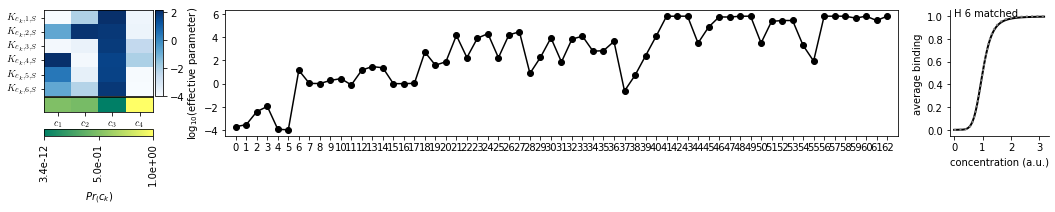

742 j=12
final_nt6_plim4_plimc6_c4_beta0.75_2330.out
error 1.9701594176870738
0.0010115142438530096,0.0001365826048163373,0.1121408907102195,8.063482312161016,0.00017011684155370869,0.00010699573994863684,2.676560146612631,3.319826754079298,3.745178894642422,3.2596343560210133,1.6585166858658327,1.9472713028263695,0.00011622940738743565,9.25928503448958,0.002547819650132753,0.00013021369000397635,0.031314152090817275,0.00010783917052354472,0.00013065049932194176,0.0001,0.0001226890004857676,0.0001,0.0001586166626443854,0.00013236763757010805,1.35318019278453e-06,9.877022180532598e-05,816119.8298791198
0.9423683197993086 1.505111290307491
function evaluated between 0.01 and 10.00


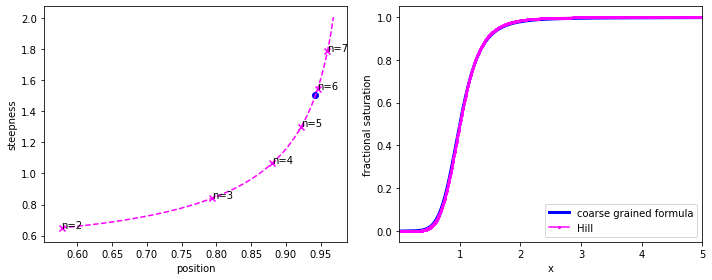

[1.01151424e-03 1.36582605e-04 1.12140891e-01 8.06348231e+00
 1.70116842e-04 1.06995740e-04]
[2.67656015 3.31982675 3.74517889 3.25963436 1.65851669 1.9472713 ]
[1.16229407e-04 9.25928503e+00 2.54781965e-03 1.30213690e-04
 3.13141521e-02 1.07839171e-04]
[0.00013065 0.0001     0.00012269 0.0001     0.00015862 0.00013237]
[1.00000000e+00 1.35318019e-06 9.87702218e-05 8.16119830e+05]
effective parameters
0.00013065158308794682,0.00010000117091307783,0.00012282626387234133,0.00010988013836883401,0.00015861668325588645,0.00013236760970721125,1.0011293448611402,1.008569828497216,1.6072371477941545,1.0003557135617802,1.0004980568937403,1.0023083225588372,1.0345285657890366,1.002776537521466,1.0008075180239704,83.00651500821104,1.0006100545614154,1.0005294779456806,1.0070335115244435,0.983488402609035,1.000254981882809,35.3132851540616,34.134390456902295,12.757381156156876,17.574743229769844,8.038250741367191,11.830629596381375,16.233931171920396,12.107746653149748,16.57013655289685,6.22332683

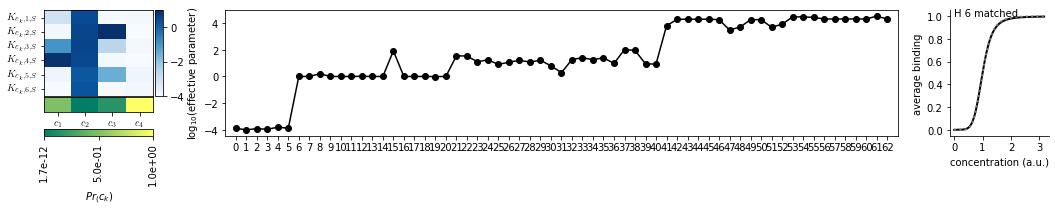

805 j=13
final_nt6_plim4_plimc6_c4_beta0.75_494.out
error 1.9703700208492503
0.00022758805044697313,1.9776616067679096,0.0004228104128169925,0.059383047544731546,1.5638739538332733,0.04978697537138061,0.00014693925777190314,0.0003426902454079824,0.00010666603967967082,0.00010807044053565493,0.0001,0.00012982012079525737,0.0032267232204341053,12.98212967853863,0.00019814397222162974,0.26344860427918665,0.0001,0.9783515787322257,7.514122811515929,14.33558808079426,10.615701401224745,3.784446980505928,5.654592238114948,56.782931807807785,446901.02819862077,2.3147527995134004e-05,1e-06
0.9410504281686478 1.505386154738298
function evaluated between 0.01 and 10.00


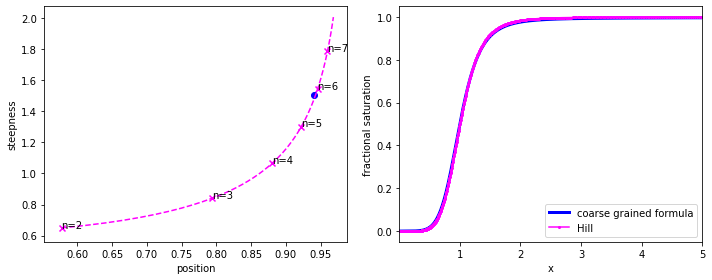

[2.27588050e-04 1.97766161e+00 4.22810413e-04 5.93830475e-02
 1.56387395e+00 4.97869754e-02]
[0.00014694 0.00034269 0.00010667 0.00010807 0.0001     0.00012982]
[3.22672322e-03 1.29821297e+01 1.98143972e-04 2.63448604e-01
 1.00000000e-04 9.78351579e-01]
[ 7.51412281 14.33558808 10.6157014   3.78444698  5.65459224 56.78293181]
[1.00000000e+00 4.46901028e+05 2.31475280e-05 1.00000000e-06]
effective parameters
0.00014693945520680466,0.000347115451880887,0.0001066667708513029,0.00010820309792671948,0.00010349915531720523,0.00012993141270786272,1.0117621119675775,1.0113912940115852,1.004677358316155,1.0248073307066579,1.0504834940739387,1.0469769947808751,7.990610942771026,193.59190611911245,5.9264067896583805,1.0114216742772375,1.1123691991686837,1.0998557069398018,19.52489774861379,1.503624835212167,13.974289060560121,450.22994604027696,22.17737307645404,2.8797753145490486,349.97994405837875,394.7966185861218,560.3781086317651,4525.876129573614,12.720048140998525,1164.362349066629,197.013

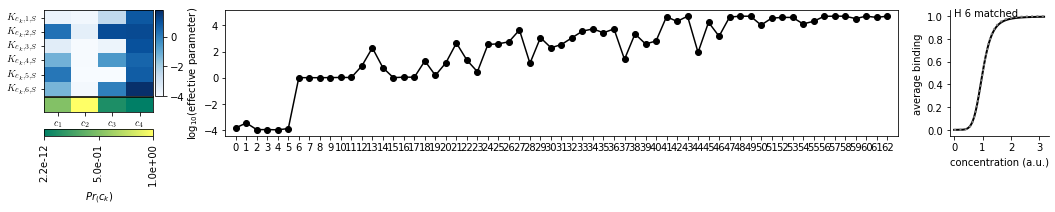

448 j=14
final_nt6_plim4_plimc6_c4_beta0.5_2293.out
error 1.9714626842342662
0.5842350846108195,0.022253776933740983,2.884207182249693,0.0002100203393572415,0.012689779546644664,0.6971071293528928,0.018537048499844905,0.2150934472999429,0.04923681857406376,0.001129779795614023,2337.8750559492523,99.88727052014235,0.0029780875376346047,0.0001315784465271545,0.0007520795764202116,0.0006258916931966208,0.00011377771447896997,0.00010936015406811034,68.61763853760016,12.64261363990269,21.434034609095697,27.747008236964472,12.225647079061137,13.971582170782275,4.3886059470722305e-05,626641.2133106766,1.0396222472143234e-06
0.941936643162862 1.505213589015646
function evaluated between 0.01 and 10.00


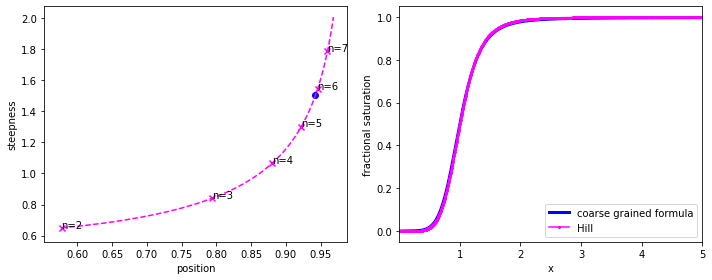

[5.84235085e-01 2.22537769e-02 2.88420718e+00 2.10020339e-04
 1.26897795e-02 6.97107129e-01]
[1.85370485e-02 2.15093447e-01 4.92368186e-02 1.12977980e-03
 2.33787506e+03 9.98872705e+01]
[0.00297809 0.00013158 0.00075208 0.00062589 0.00011378 0.00010936]
[68.61763854 12.64261364 21.43403461 27.74700824 12.22564708 13.97158217]
[1.00000000e+00 4.38860595e-05 6.26641213e+05 1.03962225e-06]
effective parameters
0.00297901522651485,0.0001316137853141852,0.0007566810530707458,0.0006258910756137713,0.00011396153361540989,0.00011047944659772133,1.0560073285162799,2.187603489781978,1.0014870900566681,1.0459630893409009,2.9695409127643786,2.0266531350441555,1.0068865802756437,3.3932465369560996,2.8157897072813527,0.9980426956728193,1.7681552290023252,39.37453046046049,1.0089295781220176,1.0026624191530715,1301.100471814038,151.320825124441,162.628805176502,122.38830635038671,284.0222581371106,49.47816321179355,141.6904727830588,194.6686369687319,181.1480844914828,215.3195907242637,6.780570810380

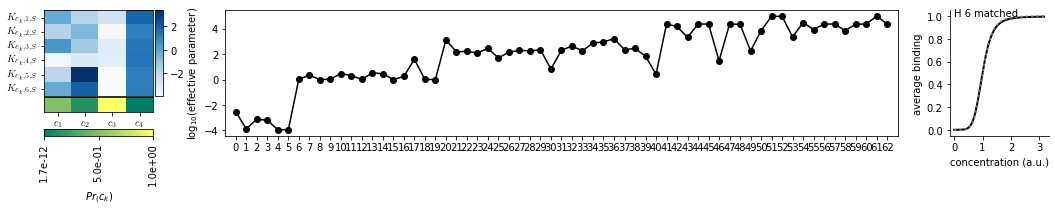

521 j=15
final_nt6_plim4_plimc6_c4_beta0.5_538.out
error 1.9722799825545863
0.0003454974382180999,0.6172976593658464,0.0006872811341365289,0.00010258468804554021,0.0015209643429319462,0.0017936606142625999,60.39949061047166,214.00478467620357,163.29824575249532,152.97048804135184,140.02047504621055,145.58743004448354,0.005105146456551435,0.00016891046412446473,0.0001343038467653548,0.0088302260415599,0.004865885281214819,0.0001944364217122711,40.209381850168654,0.00016110341981110047,2370.0374461095194,1.1631691541209948,9.015999261297447,0.00014005987223063694,6.284239828265773e-06,973318.8696525666,1.1289134987514387e-06
0.9411896977154124 1.5055614855531665
function evaluated between 0.01 and 10.00


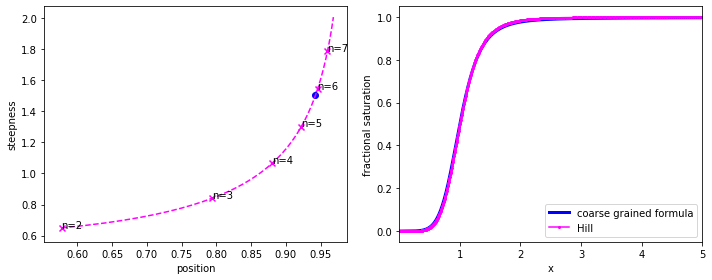

[3.45497438e-04 6.17297659e-01 6.87281134e-04 1.02584688e-04
 1.52096434e-03 1.79366061e-03]
[ 60.39949061 214.00478468 163.29824575 152.97048804 140.02047505
 145.58743004]
[0.00510515 0.00016891 0.0001343  0.00883023 0.00486589 0.00019444]
[4.02093819e+01 1.61103420e-04 2.37003745e+03 1.16316915e+00
 9.01599926e+00 1.40059872e-04]
[1.00000000e+00 6.28423983e-06 9.73318870e+05 1.12891350e-06]
effective parameters
0.005105142003001067,0.00016954589100159074,0.0001343082181431821,0.008830218063616878,0.00486588275906711,0.00019443900475748987,1.0929233509216112,1.2540477735930227,1.001325254186699,1.002215437554874,1.057182871660796,10.923980272535443,1.1374743544061892,1.231931967494329,7.13276840560318,1.1386551204049598,1.2637868971764794,6.877840464442554,1.0032192536815798,1.0837345919769164,1.139102119650305,10731.51687184826,1469.3064800492837,2252.9831096761745,10121.554067325898,1432.5383075979876,2351.884289680818,10111.065065122119,38.956102474994594,915.1967647739135,1445.75

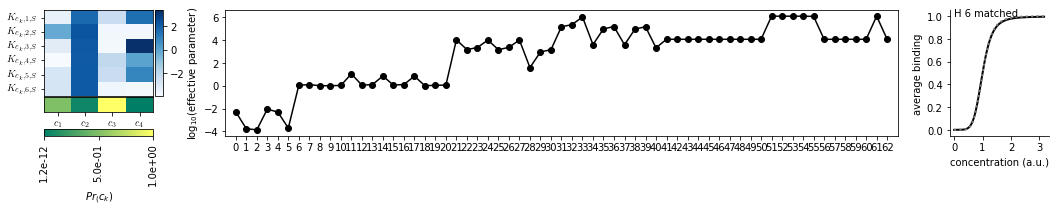

245 j=16
final_nt6_plim4_plimc6_c4_beta0.25_636.out
error 1.9725095938846195
0.00015225043020888792,0.40260594704636077,0.0009469051574980103,1261.4556233817905,0.026047939159910435,0.14787095400236733,1381.8367394898326,0.00018145141899799663,0.029658135312511477,0.0009570511817731435,0.00015853164960646663,0.018520832704192306,0.0028212302535898784,0.0032195873721926147,0.001767636750107291,0.001920297228005491,0.0020417458083557866,0.007701793612530997,129.81268454829453,146.74448613026232,117.51487873246882,92.10174839435622,35.6814115986902,79.75779146200198,0.010433298850220553,604378.655047591,1e-06
0.942044245079066 1.5051401126189972
function evaluated between 0.01 and 10.00


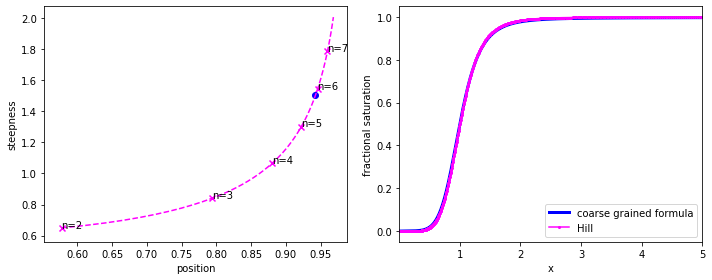

[1.52250430e-04 4.02605947e-01 9.46905157e-04 1.26145562e+03
 2.60479392e-02 1.47870954e-01]
[1.38183674e+03 1.81451419e-04 2.96581353e-02 9.57051182e-04
 1.58531650e-04 1.85208327e-02]
[0.00282123 0.00321959 0.00176764 0.0019203  0.00204175 0.00770179]
[129.81268455 146.74448613 117.51487873  92.10174839  35.6814116
  79.75779146]
[1.00000000e+00 1.04332989e-02 6.04378655e+05 1.00000000e-06]
effective parameters
0.0028450804058763888,0.0032202483828552447,0.0017676360680383885,0.004007484896916824,0.0020417855552664742,0.007702025853615142,0.9953355711380758,1.1373123860015244,0.5067684254628526,0.9935675248886385,1.0125307807788078,1.0049168721741364,65.59581267220014,1.0037302612187529,1.004515239900923,0.7607049474070341,1.0019128812450147,1.0011253649460428,7.1241970460182005,10.478822657607964,1.0006533962546655,228.58542586641371,1.2656927087854961,60.884192378338604,36.45300834976605,152.32098855827064,88.54224705118827,53.24332362966069,4.372656655380342,1.811473636871923,14.6

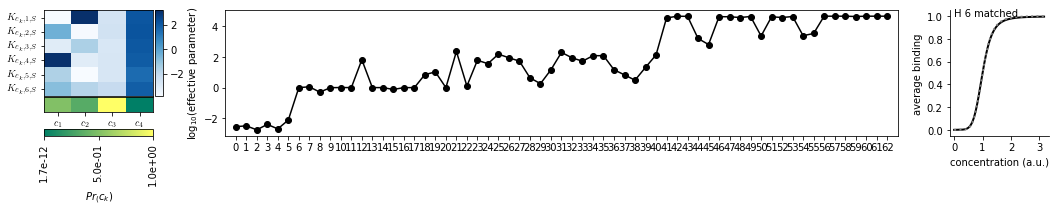

71 j=17
final_nt6_plim4_plimc6_c4_beta0.25_1581.out
error 1.972608207260082
0.0006043004779962487,3.889550430203261,0.01489329932822976,149.09540620119705,1.9274587040851097,0.00017527469997689877,0.003675138995261239,0.0001598359732528437,0.023183569328470256,0.00038672581997219315,0.0008796951496162818,0.0003208871412223128,77.94386960880814,238.0830075534786,237.42174449495403,228.00954897805934,220.02837774325693,53.13185346964016,2.9223786996897054,0.0011350033361833631,0.03189562101060501,0.0024125135945514443,0.04587370344112061,0.45313853590170167,866349.4840406931,1.1412581079542681e-06,478.7910083679081
0.9418645488626767 1.5052392884708228
function evaluated between 0.01 and 10.00


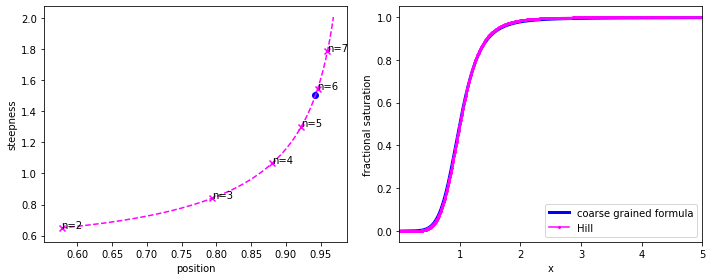

[6.04300478e-04 3.88955043e+00 1.48932993e-02 1.49095406e+02
 1.92745870e+00 1.75274700e-04]
[0.00367514 0.00015984 0.02318357 0.00038673 0.0008797  0.00032089]
[ 77.94386961 238.08300755 237.42174449 228.00954898 220.02837774
  53.13185347]
[2.92237870e+00 1.13500334e-03 3.18956210e-02 2.41251359e-03
 4.58737034e-02 4.53138536e-01]
[1.00000000e+00 8.66349484e+05 1.14125811e-06 4.78791008e+02]
effective parameters
0.005287274255670304,0.00016486183451368196,0.023188372157346378,0.0005598455022248737,0.000906770327385452,0.0005709997526919821,2.8064812222178332,1.1146925480483825,1.8384873647438382,16.12379904577337,242.66919144549757,1.0109564095046009,7249.853845806962,59.447796918403355,3.747574292362816,0.8963366690191057,1.0126854101346552,1.1657333574684567,653.9760874374697,2.421083939209887,22.75090154908823,287.402358634008,1.6901622542979868,116.31832593784178,1141.1312350543237,92.87443628895937,69.260342012454,302.0706765937617,3.1495662080317532,735.1454766080167,558.019705

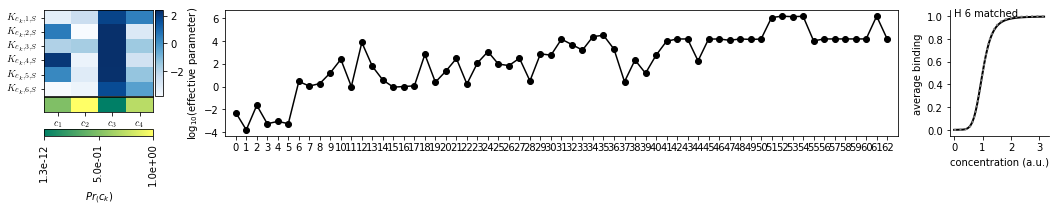

753 j=18
final_nt6_plim4_plimc6_c4_beta0.75_2420.out
error 1.972640125159318
0.023052480752361666,0.00010597857735410306,0.0001115244787040048,0.00012643377824395343,0.09376824169290682,0.23228553662004656,0.00013515360760174973,0.00011884943072485384,0.000163415648922742,0.0001,0.00011803809102287654,0.00016871972904784982,0.3230936856233987,0.0007336773341114769,0.0001,0.0014497719749122888,0.0001,0.00016452726925804593,14.451771285793876,10.454339163789697,27.485135982964948,13.327339692599843,14.114355838994971,10.825936860320565,114696.88801555036,1.39969313761764e-06,1.6098300007219338e-06
0.9407223496742255 1.5056013247379814
function evaluated between 0.01 and 10.00


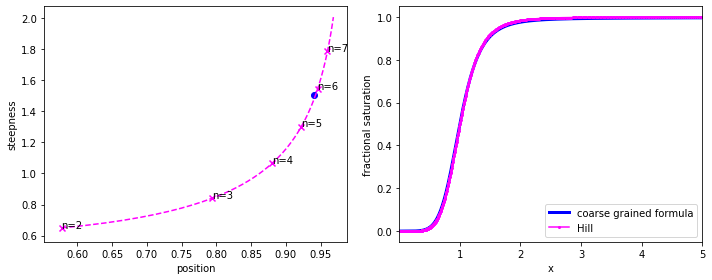

[2.30524808e-02 1.05978577e-04 1.11524479e-04 1.26433778e-04
 9.37682417e-02 2.32285537e-01]
[0.00013515 0.00011885 0.00016342 0.0001     0.00011804 0.00016872]
[3.23093686e-01 7.33677334e-04 1.00000000e-04 1.44977197e-03
 1.00000000e-04 1.64527269e-04]
[14.45177129 10.45433916 27.48513598 13.32733969 14.11435584 10.82593686]
[1.00000000e+00 1.14696888e+05 1.39969314e-06 1.60983000e-06]
effective parameters
0.00013535362038543145,0.00011884946524619301,0.0001634155822682839,0.00010000041753391123,0.00011885478369889973,0.00017074360453973246,1.1316556873652872,1.2515736263610473,1.200105340844427,2.341082399645913,3.101781049263025,1.2076450014113704,1.164534414679138,1.1458647540696851,1.0769932750291626,1.3146036975619113,1.2781470630142862,1.1459084286459877,1.223944109764749,1.12173095081768,10.444561460356837,18359.458388986204,15086.52454796155,13662.893313283193,7762.972570758649,25552.8857698625,23419.07734510011,13948.11848283716,19379.632630913988,11292.008872346294,1232.9978

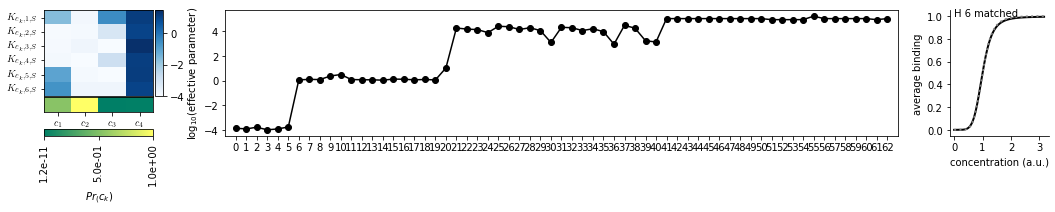

156 j=19
final_nt6_plim4_plimc6_c4_beta0.25_2274.out
error 1.9729129015345082
14.89125353178721,0.0008289033828282951,20.43123249786914,0.24761828505402003,0.00010835842582498723,0.00786533677934226,0.0004402880343983208,0.00010153156311753779,1435.6646184255596,0.005685446907467134,0.00038430075033784645,0.0007228344450310346,56.865246454494525,44.36467869409927,17.31463879951645,260.5379163136944,35.90492554240547,25.434460431335875,0.0026797745336058186,0.0001644483080240398,0.0018198178817810738,0.00014095632638105917,0.0007718301663480425,0.0023046091544247365,0.0009791365577163833,1e-06,1000000.0
0.9417323288729461 1.5049631136959123
function evaluated between 0.01 and 10.00


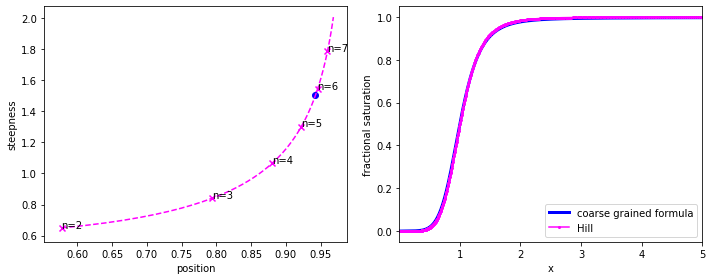

[1.48912535e+01 8.28903383e-04 2.04312325e+01 2.47618285e-01
 1.08358426e-04 7.86533678e-03]
[4.40288034e-04 1.01531563e-04 1.43566462e+03 5.68544691e-03
 3.84300750e-04 7.22834445e-04]
[ 56.86524645  44.36467869  17.3146388  260.53791631  35.90492554
  25.43446043]
[0.00267977 0.00016445 0.00181982 0.00014096 0.00077183 0.00230461]
[1.00000000e+00 9.79136558e-04 1.00000000e-06 1.00000000e+06]
effective parameters
0.0026946631471296695,0.0001644490167813153,0.0018416529998480308,0.0001412040694283897,0.00077182953840164,0.0023046147390301534,1.028017317429892,62.29043480078057,10.722515539806427,0.9962321137131342,1.0135644285402716,1.0470650539778739,1.504850032247414,1.0125460527005503,1.0029868180984733,20.489067716430647,0.9905184588119694,1.026345671703702,1.0843248446525997,1.024590219559829,1.0005112692914477,347.18643160048094,7013.491143053204,262.5427514772535,63.72993429518579,5265.100329063049,18.99948632544797,206.95393379037847,1672.6413026813805,452.65959036981843,11.825

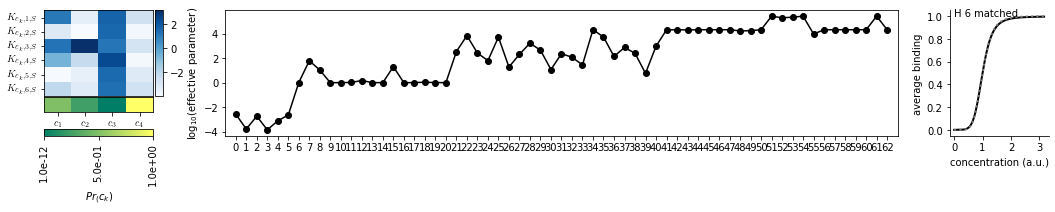

186 j=20
final_nt6_plim4_plimc6_c4_beta0.25_2508.out
error 1.973074360560345
1.5410989415113168,0.688890302785982,0.00031728509613304884,0.000196592095470433,0.007439641063006286,19.748831918809696,0.002258083536401061,0.00013922618987151524,0.0051015154450376726,0.0029351059498902224,0.00012614271296237597,0.008276679418834648,2.827749694131785,134.86381731009197,0.027280389609522435,0.0005073601160741417,0.0001,1.2007724549751002,84.18513727863844,509.37163854076493,136.1375236889353,129.4472994024547,112.078939772436,74.28007097563128,236887.1401641815,0.00830065616401248,1e-06
0.9412354004920999 1.5055125227636765
function evaluated between 0.01 and 10.00


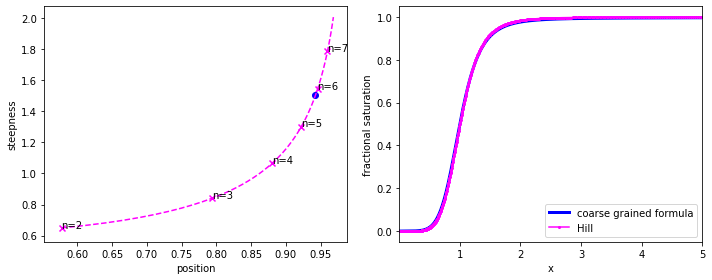

[1.54109894e+00 6.88890303e-01 3.17285096e-04 1.96592095e-04
 7.43964106e-03 1.97488319e+01]
[0.00225808 0.00013923 0.00510152 0.00293511 0.00012614 0.00827668]
[2.82774969e+00 1.34863817e+02 2.72803896e-02 5.07360116e-04
 1.00000000e-04 1.20077245e+00]
[ 84.18513728 509.37163854 136.13752369 129.4472994  112.07893977
  74.28007098]
[1.00000000e+00 2.36887140e+05 8.30065616e-03 1.00000000e-06]
effective parameters
0.0022646789633370495,0.00014686151262023774,0.005101496600706509,0.002935094850891009,0.00012617405838936374,0.008360054328624376,55.14255691017721,1.0016873729412024,1.00420799699142,1.305643045787212,7.780802473748879,1.5120310163214112,1.600633090828676,15.146646085733527,52.46726939912774,1.0049715683417695,1.0998336305805152,0.9916744812304091,1.165147190757568,0.9923495325462783,1.6110897085207407,9749.036307212597,15002.040376646371,31973.648919946445,808.8669696275248,184.76566052758218,3383.064321905666,38.97464741690325,5277.164894568746,63.42007281914243,1017.7178

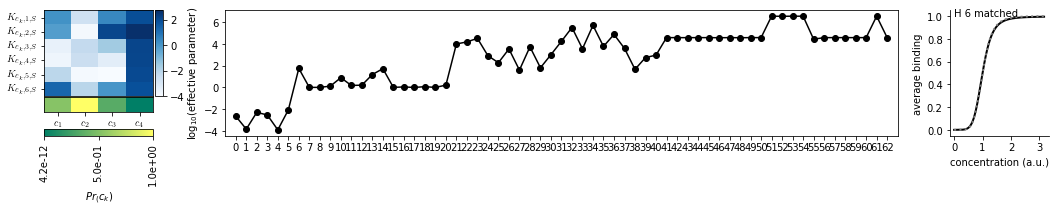

404 j=21
final_nt6_plim4_plimc6_c4_beta0.5_1933.out
error 1.9730790201216928
0.005229926037172063,0.6123467973230114,0.00011667259087656336,7.260750079662074,549.1971289611059,0.0001800930621284492,0.0005051194474694872,37.65763060884704,0.0007491517949140298,0.024590010007575474,201.6503946957733,61.023044876705036,883.0720767712382,565.5419813019926,827.4382480477645,442.74016990979595,522.2699114893911,571.0846408831667,0.07309813560963546,0.003638237212513715,0.00017657108213898757,0.00160312803078623,0.00012898403880100468,0.00010658628666236134,0.05471370368178425,7.712626120029814e-06,749200.6937625128
0.9410815453673712 1.5055120861247928
function evaluated between 0.01 and 10.00


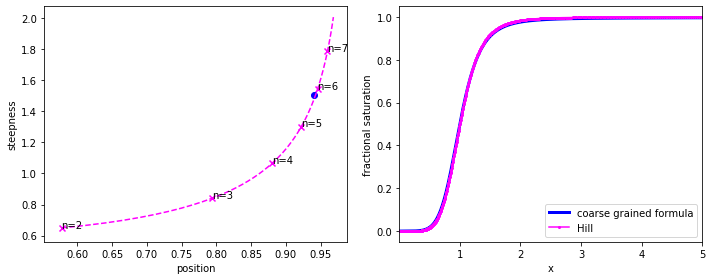

[5.22992604e-03 6.12346797e-01 1.16672591e-04 7.26075008e+00
 5.49197129e+02 1.80093062e-04]
[5.05119447e-04 3.76576306e+01 7.49151795e-04 2.45900100e-02
 2.01650395e+02 6.10230449e+01]
[883.07207677 565.5419813  827.43824805 442.74016991 522.26991149
 571.08464088]
[0.07309814 0.00363824 0.00017657 0.00160313 0.00012898 0.00010659]
[1.00000000e+00 5.47137037e-02 7.71262612e-06 7.49200694e+05]
effective parameters
0.07309804881085064,0.0036418053565181493,0.00017657956203110718,0.001612823442390399,0.000876758669690238,0.00011104872823894678,1.0183539369662673,1.5827108644864059,1.0285576604267805,0.28113101475306224,1.5996519248066836,8.493443226399059,2.453735361662181,315.3625026081879,424.1478020033806,14.240133067562756,29.50595615726435,249.20648057730855,3766.0376174285275,16.108552333353504,9262.92512114905,10655.115109715494,2161.0440862294163,36.51549692466754,234.16845183372433,11234.13847452799,11765.069577832295,12025.87594305932,5.471453001467976,10899.051762111803,41.135

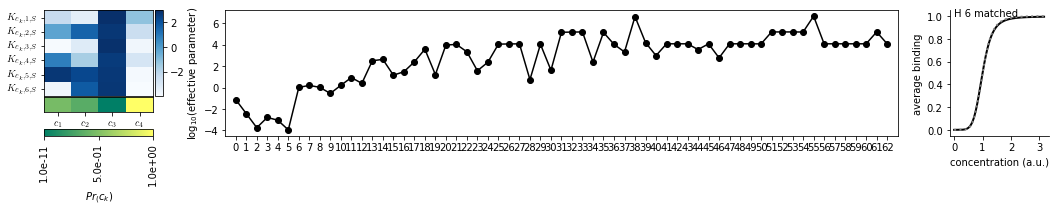

51 j=22
final_nt6_plim4_plimc6_c4_beta0.25_1419.out
error 1.9733357084149943
0.005819651765912808,24.863717483229344,0.8978266783066301,1421.881802354866,0.09398559639292273,0.02631933701963932,0.19099059878581728,0.0007206807791012424,0.20394674898208193,0.06045459435068202,0.05803321931475616,0.04428143560816621,4474.3627457665225,3222.324234519013,3865.985654214593,3641.6528305945617,3600.2408378237847,2121.4938386860945,5.645031834737491,0.00018412917427300512,0.00029264369306125073,3.5992281237622814,82.90421749416672,19.52552285129627,591697.0694267922,4.877943450095867e-06,1.4463727969251599
0.941277496760809 1.5055024476851202
function evaluated between 0.01 and 10.00


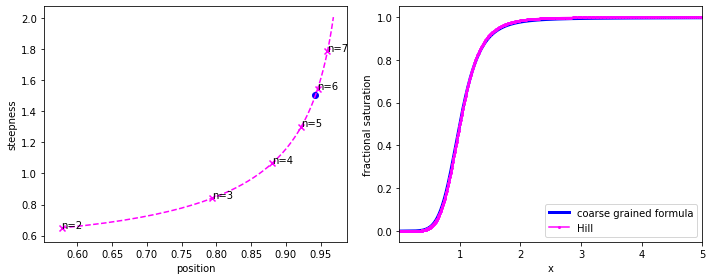

[5.81965177e-03 2.48637175e+01 8.97826678e-01 1.42188180e+03
 9.39855964e-02 2.63193370e-02]
[0.1909906  0.00072068 0.20394675 0.06045459 0.05803322 0.04428144]
[4474.36274577 3222.32423452 3865.98565421 3641.65283059 3600.24083782
 2121.49383869]
[5.64503183e+00 1.84129174e-04 2.92643693e-04 3.59922812e+00
 8.29042175e+01 1.95255229e+01]
[1.00000000e+00 5.91697069e+05 4.87794345e-06 1.44637280e+00]
effective parameters
0.19100365478887366,0.0007627256657306654,0.2039474557212711,0.06286621960792013,0.058235822118928526,0.04432904342783473,1.762382387070637,1.0035851005317404,0.9780566838378592,1.11123445030417,1.039917231739415,1.8476055565548442,1248.9967471329396,3.1845051693814064,2.643651291077218,1.1389587877437994,1.006191348506934,1.0064031887390432,1.2487335360001985,1.0677947516848867,2.5526190691286397,8371.154584035015,37.870663665207395,15839.215432464365,14770.179617039888,187.03182885033684,225.9103034998489,175.07235593669643,559.3159124014584,503.9920063416448,241.9746

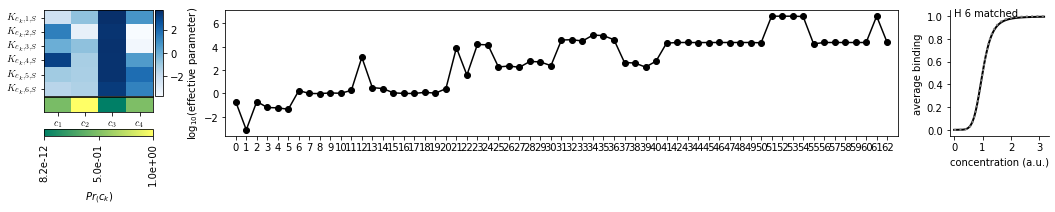

243 j=23
final_nt6_plim4_plimc6_c4_beta0.25_618.out
error 1.9736179192680785
0.0012888952415148446,7.234908652070082,0.0002263564276214347,0.20212275188239934,0.06040296528438404,0.00014909279927785308,5.747522845404578,1.1850435248130404,1.1859942907012733,0.02528065974809111,28.69889226737444,160.40395439259436,0.0008736659926285693,0.005631801536511635,0.005817239133595988,0.00010112109448197762,0.0012584818030671086,0.00014242541142116749,82.75568584705628,120.90752838964673,101.60425182411007,87.5543241193545,132.86569484516076,81.71086930797757,0.0012454321862451234,1000000.0,1.0614626564690951e-05
0.9411204822929251 1.5055142710767888
function evaluated between 0.01 and 10.00


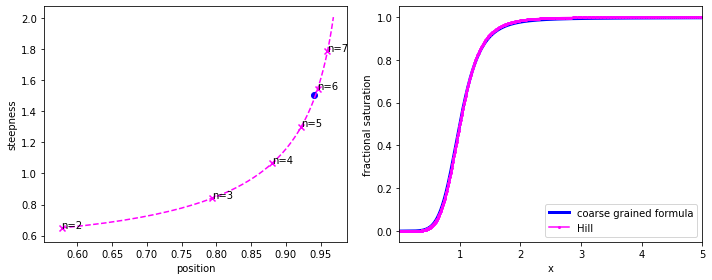

[1.28889524e-03 7.23490865e+00 2.26356428e-04 2.02122752e-01
 6.04029653e-02 1.49092799e-04]
[5.74752285e+00 1.18504352e+00 1.18599429e+00 2.52806597e-02
 2.86988923e+01 1.60403954e+02]
[0.00087367 0.0056318  0.00581724 0.00010112 0.00125848 0.00014243]
[ 82.75568585 120.90752839 101.60425182  87.55432412 132.86569485
  81.71086931]
[1.00000000e+00 1.24543219e-03 1.00000000e+06 1.06146266e-05]
effective parameters
0.0008736744433226357,0.005639033558326868,0.005817236090976255,0.0001013240766243176,0.0012585780987173349,0.00014262605728673,1.0238790362595496,1.0192212289091531,1.8717683844687394,1.292950409683454,10.788995600393411,1.002795413332337,3.7527966680207423,1.0902096266508985,1.423390541452124,1.1583379042545765,1.0252866337677566,1.3903693198801552,2.069024236734159,6.6028756649794875,33.5795034568391,376.82363234334736,4965.149543319639,2124.4992798821336,10037.88939243365,13101.40453286349,1846.2776596689869,8587.863826850959,44351.73488650336,75729.92276698965,8068.08398

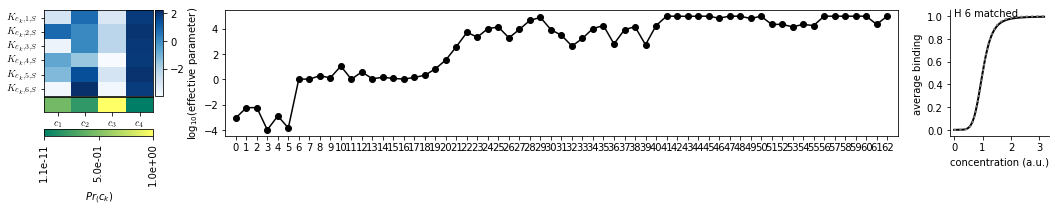

80 j=24
final_nt6_plim4_plimc6_c4_beta0.25_1653.out
error 1.9743655708365049
1.1992130279135877,0.00040778132198444336,0.0005804772789789151,7.712469864237203,0.31724778182315905,0.007404794180070601,1793.9199012695844,2489.6425889982775,2311.0397554312185,2224.142454660767,2347.261433419868,4200.383902202539,0.0001,0.19643840964773301,0.0001037590529438479,0.03666327943866851,0.2065742965258085,0.0845341944708358,0.0010543931308315112,537.2983145361853,2.9530918723098103,0.13961370682642862,0.0005890742082622672,96.38521412495162,1.8239082562084774e-06,319077.7137445525,0.018004131946168404
0.941573089332963 1.5054483038311266
function evaluated between 0.01 and 10.00


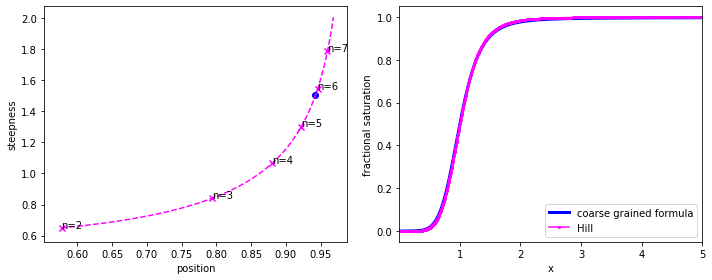

[1.19921303e+00 4.07781322e-04 5.80477279e-04 7.71246986e+00
 3.17247782e-01 7.40479418e-03]
[1793.91990127 2489.642589   2311.03975543 2224.14245466 2347.26143342
 4200.3839022 ]
[1.00000000e-04 1.96438410e-01 1.03759053e-04 3.66632794e-02
 2.06574297e-01 8.45341945e-02]
[1.05439313e-03 5.37298315e+02 2.95309187e+00 1.39613707e-01
 5.89074208e-04 9.63852141e+01]
[1.00000000e+00 1.82390826e-06 3.19077714e+05 1.80041319e-02]
effective parameters
0.00010376835569539034,0.19646811567949315,0.00010394038069902689,0.036687354113406775,0.20657464517240204,0.08453941055559094,2.217420998924594,2198.364209250413,14.567876309167124,2.1421686982973447,5.877352622752589,6.992847774002922,1.0041694302261532,1.0006674380002683,1.179316559758798,8.712409450781685,2.4424333371458915,9.14072503857135,1.004288366111355,1.0167993994622837,1.0031611785606385,3981602.6662406037,75601.95306236486,14220.41468042368,52760.2379863265,15288836.317613056,10221817.17412247,11943058.532963054,67794.77231425092,29

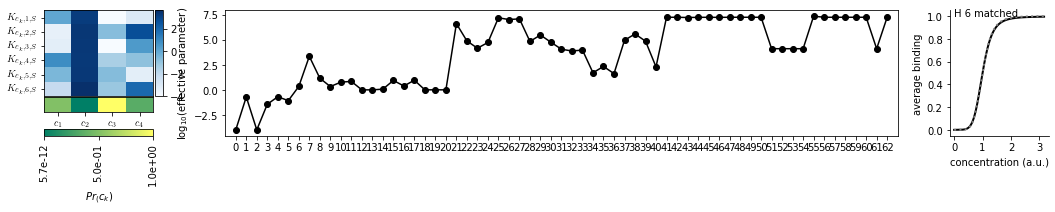

49 j=25
final_nt6_plim4_plimc6_c4_beta0.25_141.out
error 1.9743849684983688
0.0009155672193422163,0.0971079711043984,87.23648377144687,131.1822476130907,0.0001,0.4574164359464402,0.025525227731383087,0.024811539640002277,0.00011152713071108622,0.0114655978321165,0.0009883420244792443,0.00040227963126238114,152.9817857517812,768.4326485648479,0.5584531272005285,217.7192038274821,0.00013163007398218392,0.004410009058588875,446.54353726082684,503.07245831140824,582.5182121511016,430.29756347311417,296.6580309510125,435.5447258521103,1000000.0,6.184646633229912e-06,9.731848525298074e-06
0.9411659018859949 1.5054352744572188
function evaluated between 0.01 and 10.00


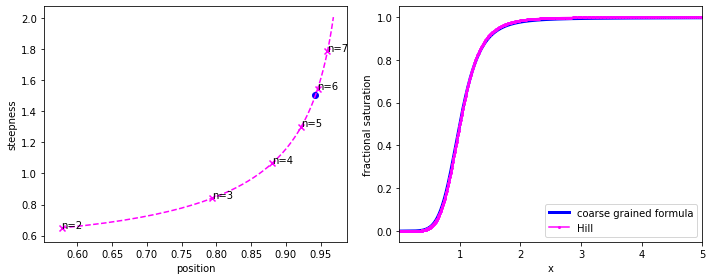

[9.15567219e-04 9.71079711e-02 8.72364838e+01 1.31182248e+02
 1.00000000e-04 4.57416436e-01]
[0.02552523 0.02481154 0.00011153 0.0114656  0.00098834 0.00040228]
[1.52981786e+02 7.68432649e+02 5.58453127e-01 2.17719204e+02
 1.31630074e-04 4.41000906e-03]
[446.54353726 503.07245831 582.51821215 430.29756347 296.65803095
 435.54472585]
[1.00000000e+00 1.00000000e+06 6.18464663e-06 9.73184853e-06]
effective parameters
0.025525208413167973,0.02481162158426624,0.00019876908814312036,0.011596774016878043,0.0009883440231513252,0.00040274088363360597,1.0045965302729367,1.0758772914856736,0.9961071168951032,1.0510996830870987,1.183013707270321,2.8576001384564886,1.0438747005987008,1.0592208966130952,1.2166892651688752,4966.241698873326,9.166079983248094,529.8691587979713,1.0982164697495267,14.225711613540913,4.157968725487844,3541.5157564339956,144.2961725864486,979.1410343161868,3069.091537263895,3.7641741814371423,16338.645087400622,1018.3646637243539,1727.4582098274848,480.3377286789744,13291

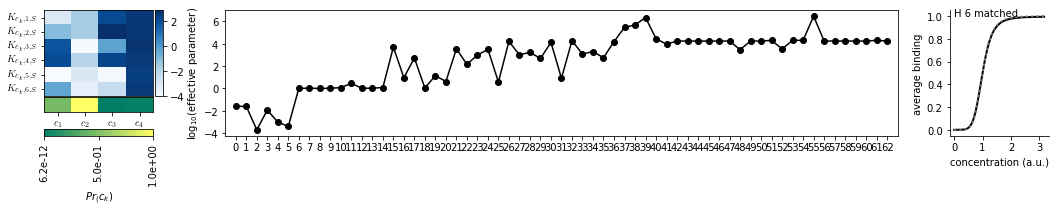

461 j=26
final_nt6_plim4_plimc6_c4_beta0.5_2401.out
error 1.9744611368820257
0.0001,0.00022728130312364,21.19794714087654,0.054697626316079266,0.035438924288948154,0.0001,0.04201515339881595,1.215501668860114,0.4929512902033852,0.002388470650489965,7.099236620882926,0.15369998039900207,0.0001023622538986242,0.0001,0.00010724122792096473,0.00010037895404194713,0.0001,0.0002883950279491689,7.37639732114182,4.125504004171106,4.213182814720503,13.659935623699257,7.704383212319231,6.4102308718618195,0.0016426882610349693,533154.2995686922,3.923525731414673e-06
0.9411157816960752 1.5053865490924772
function evaluated between 0.01 and 10.00


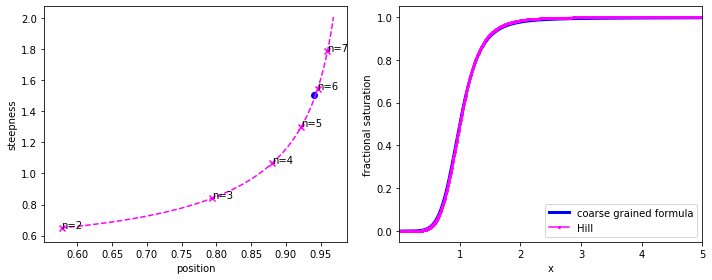

[1.00000000e-04 2.27281303e-04 2.11979471e+01 5.46976263e-02
 3.54389243e-02 1.00000000e-04]
[4.20151534e-02 1.21550167e+00 4.92951290e-01 2.38847065e-03
 7.09923662e+00 1.53699980e-01]
[0.00010236 0.0001     0.00010724 0.00010038 0.0001     0.0002884 ]
[ 7.37639732  4.125504    4.21318281 13.65993562  7.70438321  6.41023087]
[1.00000000e+00 1.64268826e-03 5.33154300e+05 3.92352573e-06]
effective parameters
0.00010236243288677072,0.0001000040138276425,0.0001470019992582681,0.00010048146563767522,0.00010008821223483246,0.0002883951944334118,1.0372084128992793,1.0131857556776727,1.0720960238524893,1.1302852415362503,1.0124576594558279,1.4784724033544991,1.0434194650486088,3.6802007286792593,1.0266651582805224,147.9887252362462,97.2446360771971,0.8334989502402965,1.4418160811122562,1.0216071450267197,1.1284080707527135,459.8550183200776,2851.604732015233,754.107028948809,482.5872476577343,14.939523742966873,16.093817654269515,409.01314657931476,3851.294926636533,1569.5168890399154,847.334

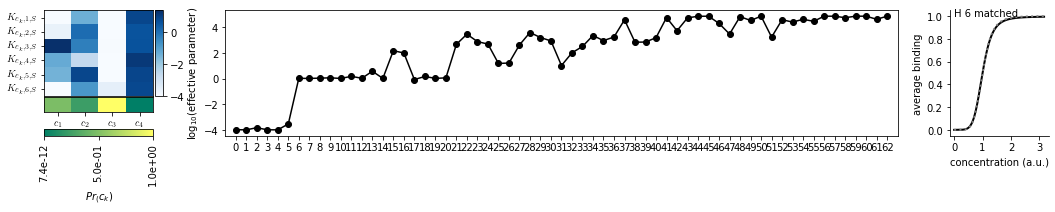

799 j=27
final_nt6_plim4_plimc6_c4_beta0.75_440.out
error 1.9745280531889198
0.004294202646925416,7.587815226975269,1.1532708021501148,1.4407296772739548,0.00023793030280101603,0.01989591814149514,0.00012074344583580605,0.00012444116437032346,0.00013680017604908353,0.001234226140411054,0.0001,0.00015180067934048301,20.315920553900483,96.79908267114487,15.616638826022804,15.252768739884159,107.77073644843071,23.711056011686207,19.485014176213856,0.00015454839966604192,0.0001646928327554746,1.2123096217833773,465.8258271078774,0.14611950227998977,323438.39248115534,1e-06,0.00030092039015920576
0.9408371265858424 1.5052358796984688
function evaluated between 0.01 and 10.00


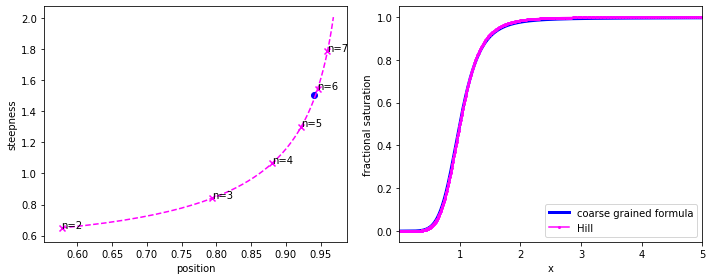

[4.29420265e-03 7.58781523e+00 1.15327080e+00 1.44072968e+00
 2.37930303e-04 1.98959181e-02]
[0.00012074 0.00012444 0.0001368  0.00123423 0.0001     0.0001518 ]
[ 20.31592055  96.79908267  15.61663883  15.25276874 107.77073645
  23.71105601]
[1.94850142e+01 1.54548400e-04 1.64692833e-04 1.21230962e+00
 4.65825827e+02 1.46119502e-01]
[1.00000000e+00 3.23438392e+05 1.00000000e-06 3.00920390e-04]
effective parameters
0.00012077454030654554,0.00014790085345933304,0.00014036544871716254,0.0012386779022312796,0.00010043415293133736,0.00015186193271117976,6.821459408808206,1.9355874006825633,1.2773174875887163,697.741178943229,1.2393663713603025,1304.2846325690327,185.3551579464058,3.3893574857179356,21.938069819470794,30.52157500812822,1.4047347484637775,4.355988631095302,5.264806919565446,1.4739574475025554,5.66625705228487,64.56279352546166,58.0080843832947,107982.10798582186,2456.273191857985,57.800986159135604,44783.54465083686,2101.437439150195,130724.75534926313,786.3232940948235,13359

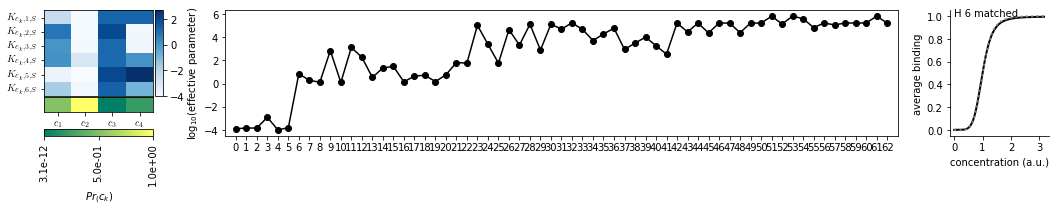

821 j=28
final_nt6_plim4_plimc6_c4_beta0.75_620.out
error 1.9748890969848745
0.00011664271980627684,0.0001,0.0521652191766261,0.0017476030494831076,0.0004321741162067224,0.00010834864959302453,15.178967495786283,10.813412836090007,36.0441971566914,7.889755806812837,22.186574409849936,16.52381515374837,0.00047235477430117393,0.00011908026289578184,0.0006246733892779053,0.00011760900360019732,0.0019597940336209215,0.0003237154980104727,0.00027934903865711107,0.9503714286572151,0.0017050030072561428,0.034429762120096644,0.1247689958010052,0.0009857937934535238,2.2312132943233625e-06,854970.2303029445,1.5995787803936643e-06
0.941803703035368 1.505425301363555
function evaluated between 0.01 and 10.00


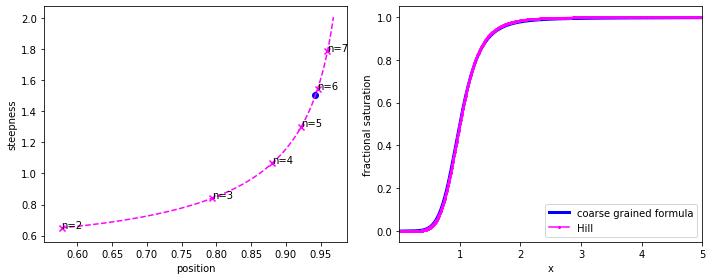

[0.00011664 0.0001     0.05216522 0.0017476  0.00043217 0.00010835]
[15.1789675  10.81341284 36.04419716  7.88975581 22.18657441 16.52381515]
[0.00047235 0.00011908 0.00062467 0.00011761 0.00195979 0.00032372]
[2.79349039e-04 9.50371429e-01 1.70500301e-03 3.44297621e-02
 1.24768996e-01 9.85793793e-04]
[1.00000000e+00 2.23121329e-06 8.54970230e+05 1.59957878e-06]
effective parameters
0.00047235439786055036,0.00011908027057616354,0.0006247337667111846,0.00011761093074386967,0.001959792304995659,0.00032371528923344104,1.0076151108596123,1.0047655267762001,1.0056132745794775,1.0009499618217765,1.004281031264667,1.0136568344704375,1.0158988316225064,1.0026836427135775,1.0120962835107277,1.0114375797433361,1.0016291562682997,1.0076211064623688,1.001969112052649,1.0089251020965528,1.0015084980963935,434.43369979296386,503.8503022879862,86.97844523344591,385.0595762754619,321.8972866999436,55.6844491290196,246.09843342755906,64.56119769177599,285.6127809665317,49.3863685687723,907.827825006414

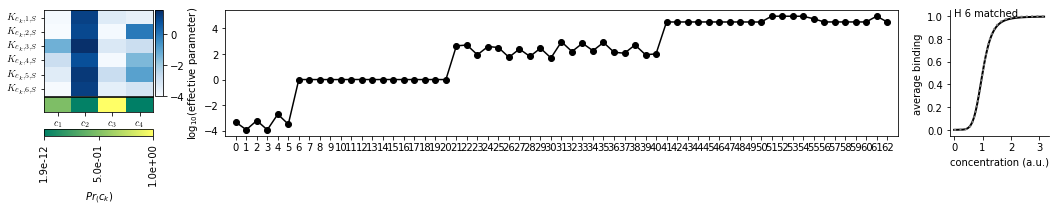

97 j=29
final_nt6_plim4_plimc6_c4_beta0.25_1788.out
error 1.9749517873687823
0.023120338646956468,0.0001617648744560431,0.01798651313263534,0.0001,0.7753988411094774,0.00015753766671789082,107.15661527024729,125.18982367827232,109.28639792595183,114.50044413693757,105.20727681058274,140.09614837704453,18.101610673256406,0.0001,0.0011753572524697761,0.0001,0.008875893347447183,0.1371434956428219,0.00020242842748384552,0.0019635528473125907,0.0025958919990406062,0.00011114332271339982,0.0013527378681040235,0.0021676263136462307,1.6715286095609028e-05,2.4496770015009335,1000000.0
0.9407786938195456 1.5055421736215016
function evaluated between 0.01 and 10.00


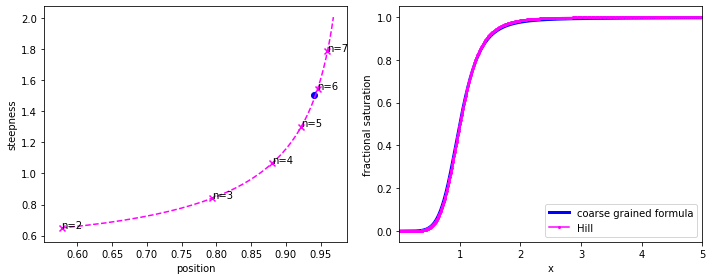

[2.31203386e-02 1.61764874e-04 1.79865131e-02 1.00000000e-04
 7.75398841e-01 1.57537667e-04]
[107.15661527 125.18982368 109.28639793 114.50044414 105.20727681
 140.09614838]
[1.81016107e+01 1.00000000e-04 1.17535725e-03 1.00000000e-04
 8.87589335e-03 1.37143496e-01]
[0.00020243 0.00196355 0.00259589 0.00011114 0.00135274 0.00216763]
[1.00000000e+00 1.67152861e-05 2.44967700e+00 1.00000000e+06]
effective parameters
0.00024679558696318813,0.0019635485729877092,0.0025959057364730678,0.00011114519817189,0.0013535320993154866,0.0021679572914096337,1.2921075026013285,1.2077631424223991,8.4586597565447,2.6157616807154005,12.655206748414853,1.0448600146222287,2.0978652954355455,1.082295536480339,1.0687215921887705,1.7249281484128207,1.0580784514529502,1.045383450068551,2.338384648277753,2.1127335485663035,1.0842735749200614,18644.844067098624,227227.5130778919,33232.52353918935,27980.308573237173,182481.06136154517,22447.191006713885,18893.05443124959,248526.7210186794,228692.04294850669,33690

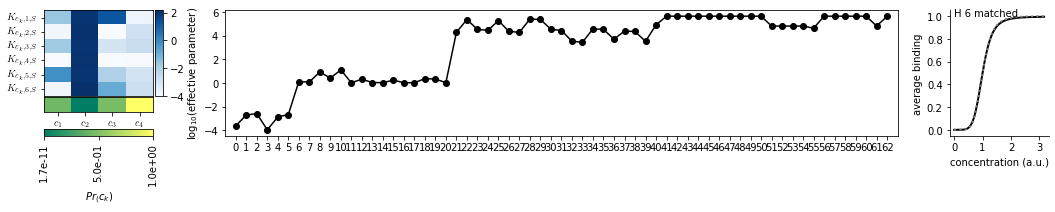

362 j=30
final_nt6_plim4_plimc6_c4_beta0.5_16.out
error 1.9749942335246604
0.017188733719614845,0.000529053175854561,0.0009083935249220602,5.7163099420627566,0.0001557313827496117,3.0336361405971783,6.052580657708838,184.33396843564924,0.00012789562300525865,0.00011871358881408405,3.2489579242098374,0.03367286446775652,129.75958157000835,131.01842962742074,141.66221527345394,147.38002867708835,88.01206043080163,235.84244878319367,0.0001245671116525416,0.006788219425013349,0.0035047086999472274,0.0001,0.00010041114611551354,0.009422444842184734,0.00035444810007194324,1.0267807465391332e-06,116318.43849551186
0.9411634748414778 1.5054870873776391
function evaluated between 0.01 and 10.00


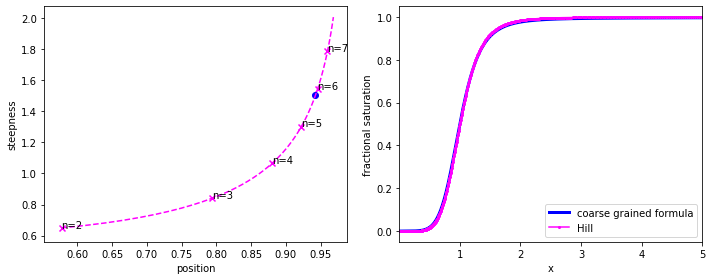

[1.71887337e-02 5.29053176e-04 9.08393525e-04 5.71630994e+00
 1.55731383e-04 3.03363614e+00]
[6.05258066e+00 1.84333968e+02 1.27895623e-04 1.18713589e-04
 3.24895792e+00 3.36728645e-02]
[129.75958157 131.01842963 141.66221527 147.38002868  88.01206043
 235.84244878]
[0.00012457 0.00678822 0.00350471 0.0001     0.00010041 0.00942244]
[1.00000000e+00 3.54448100e-04 1.02678075e-06 1.16318438e+05]
effective parameters
0.00012473340099225337,0.006788728452338325,0.003504687619552861,0.00014914364556806365,0.00010042229851281163,0.0094484462093677,5.190804632031302,1.3701586357335507,55.15076098226413,13.832288562481509,1.606027278591741,1.0068117388579494,0.8645290301107471,3.8260081147497074,1.0019270833651135,1.1084829811180832,1.3126036968760415,1.0068671311988435,8.826365308356184,106.6805631153786,1.1948680730747365,7116.261603402104,202580.99695373137,74547.36085977918,4430.515956076106,330907.3282768276,247837.36295849577,9202.959781982921,901052.7054714757,2259.8716637383554,168141.

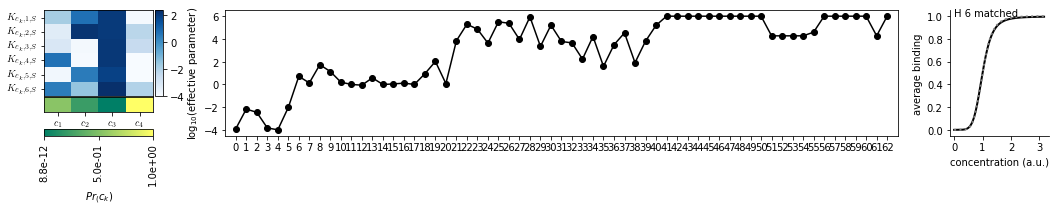

396 j=31
final_nt6_plim4_plimc6_c4_beta0.5_187.out
error 1.9754027311107891
0.00010462780935794624,0.0009998062764633262,0.0001855966737190295,0.00025668702704467804,0.00810950102745131,0.0001,0.0001,0.0001413090800281306,0.00010683763655335023,0.00010259164568557102,0.00010206699556591091,0.0001412350433945252,7.671091517201881,6.385013216403183,8.049221849810229,5.39831371383444,8.639655083117262,7.25918883980562,0.03694801666662621,8.27402661200493,0.00018973727087735393,3.2157254217823374,0.03706297995237256,0.00015066182934890513,78165.02491837055,1.0986272750964841e-06,1.1103746601037573e-06
0.9408969529190733 1.5055187969911767
function evaluated between 0.01 and 10.00


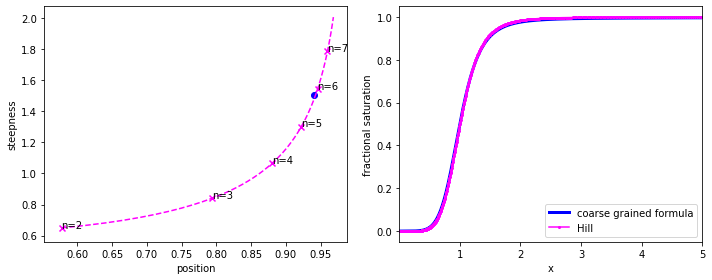

[0.00010463 0.00099981 0.0001856  0.00025669 0.0081095  0.0001    ]
[0.0001     0.00014131 0.00010684 0.00010259 0.00010207 0.00014124]
[7.67109152 6.38501322 8.04922185 5.39831371 8.63965508 7.25918884]
[3.69480167e-02 8.27402661e+00 1.89737271e-04 3.21572542e+00
 3.70629800e-02 1.50661829e-04]
[1.00000000e+00 7.81650249e+04 1.09862728e-06 1.11037466e-06]
effective parameters
0.00010000016754446684,0.00014132027029787158,0.000106838757271803,0.00010259373862236303,0.00010216955888199462,0.000141234617889387,1.0490214809639822,1.0812278176683654,1.056894866848403,1.0912184873913948,1.055414096697637,1.0478988405101555,1.0595968231786805,1.0600887615665044,1.032614991623181,1.0557306047447756,1.0902800220946045,1.054421206793153,1.0642031884364198,1.0380045924730052,1.0607931110756024,3503.242718160448,2429.072329035053,3886.839671187095,2425.649862081632,4049.483519692555,6301.065024575527,3960.5059276392185,4508.919136371102,2810.1056539165634,4418.476610049495,2385.500025328989,3711.

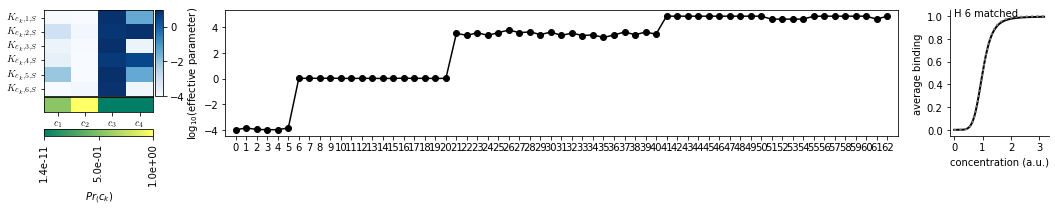

529 j=32
final_nt6_plim4_plimc6_c4_beta0.5_61.out
error 1.9755991669476571
0.00600223032876923,0.00011391447759402533,0.0024695625675280578,0.00011232505298836036,0.02083481913247192,11.933293726171778,0.00010557092670564891,0.0034591199360972545,0.0008072219071492104,0.002869625165645217,0.0035522998708090803,0.00011376617666904671,224.15259107388124,136.6820316517138,182.00338495874644,161.40824296168034,144.28359940279773,189.8808011109072,0.38539416233329743,1.3984562803247866,0.042367178719324515,0.24461718621140308,0.0001,0.017163187675076044,868338.0875057129,1.4297297428048462e-05,39.8225257082416
0.9407431337596339 1.5055365769314373
function evaluated between 0.01 and 10.00


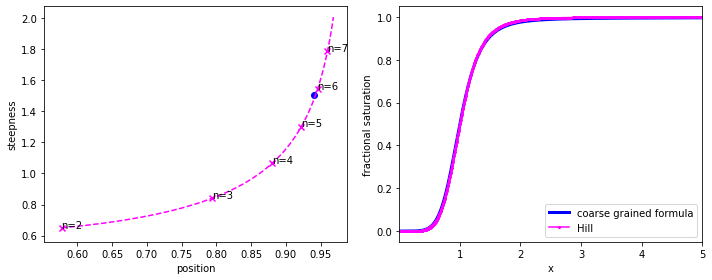

[6.00223033e-03 1.13914478e-04 2.46956257e-03 1.12325053e-04
 2.08348191e-02 1.19332937e+01]
[0.00010557 0.00345912 0.00080722 0.00286963 0.0035523  0.00011377]
[224.15259107 136.68203165 182.00338496 161.40824296 144.2835994
 189.88080111]
[3.85394162e-01 1.39845628e+00 4.23671787e-02 2.44617186e-01
 1.00000000e-04 1.71631877e-02]
[1.00000000e+00 8.68338088e+05 1.42972974e-05 3.98225257e+01]
effective parameters
0.00012325015186063278,0.003523090765614893,0.0008091326939210192,0.0028807108204369244,0.0035521638311552116,0.00012829306766174106,58.922308661922514,15.098417677845603,14.70753016327587,2.0771724393692605,69.47750777428364,2.0762913432139944,2.559531609478423,1.0082916792112684,4.254703429503887,1.4051583649950943,1.1481458910587459,7.014076644810973,1.0337239234954743,2.773811649685874,2.5049983453171674,127287.80481358795,27319.160689765613,46800.3244089038,405897.6689326087,269026.8055084839,238280.93649918027,1421387.6710676302,65925.5962010275,895803.8139205466,718626.

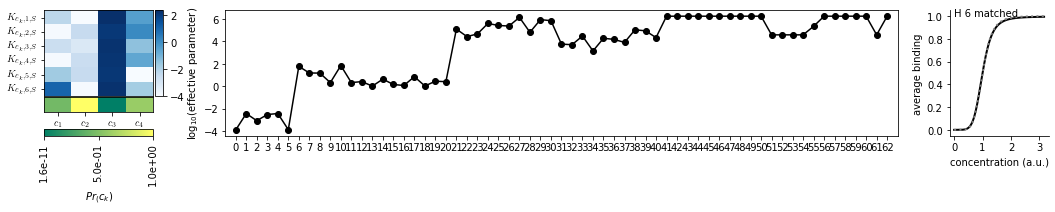

846 j=33
final_nt6_plim4_plimc6_c4_beta0.75_818.out
error 1.9760693525373627
0.004591134937142868,0.0005394276080620011,0.00025482527231868645,0.00010024765205759373,0.00012633790948787942,4.258906556544594,1.089487520700407,0.00782655351445413,0.03653137168982263,0.00011809550105677959,0.0005509388075298048,0.00022271195750590906,12.262402377938754,16.57796940370772,16.23803995649519,18.965339867858294,9.610760107277017,13.221778744744244,0.00011157897660978196,0.000934297002699018,0.0001100013993691128,0.00015791324648891677,0.00022415136617443318,0.0001762771824016799,1.2409703974075028e-06,1e-06,90452.89795226678
0.9410419383745888 1.5054888464991798
function evaluated between 0.01 and 10.00


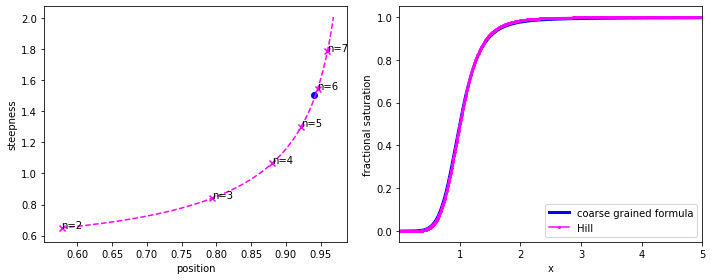

[4.59113494e-03 5.39427608e-04 2.54825272e-04 1.00247652e-04
 1.26337909e-04 4.25890656e+00]
[1.08948752e+00 7.82655351e-03 3.65313717e-02 1.18095501e-04
 5.50938808e-04 2.22711958e-04]
[12.26240238 16.5779694  16.23803996 18.96533987  9.61076011 13.22177874]
[0.00011158 0.0009343  0.00011    0.00015791 0.00022415 0.00017628]
[1.0000000e+00 1.2409704e-06 1.0000000e-06 9.0452898e+04]
effective parameters
0.0001116286502030293,0.0009342928206370506,0.00011000318046428273,0.00015791281864155183,0.00022415039106426997,0.00022335910587129257,1.0213607712070087,1.1798928031085414,1.145688581231277,1.0518753062636401,9.530587616441789,1.028948776206934,1.023559585227912,1.0084122069521129,0.9225240503710446,1.1959864214765565,1.069962747973675,1.3741104003196045,1.056929043628684,1.0016203822305314,0.9360760574072343,3092.374722184526,2529.4073196953154,917.2141048436714,1388.9858944552104,18002.72045837198,7184.673835241228,7737.826016445618,5917.764418590234,8626.116828378677,3298.867347412

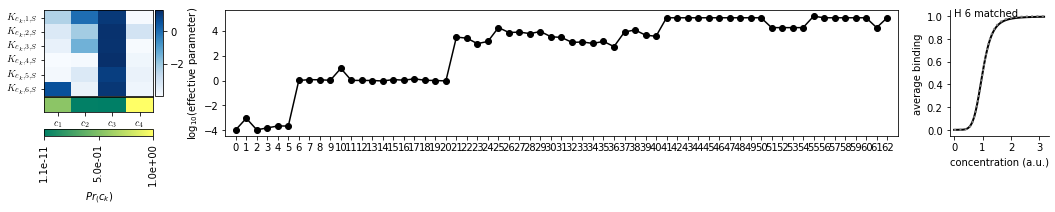

578 j=34
final_nt6_plim4_plimc6_c4_beta0.5_997.out
error 1.9766895630210826
0.6207895114543446,86.06924627159943,0.025883136195304298,0.011288246949057138,0.0001432354612844993,0.07657546565762383,0.0001309091356702052,0.0011358868189897734,0.0028437039160720333,0.000259917436038531,0.0028932569631750075,0.00012017405428027848,140.59356713223573,101.1170306870996,87.75738012428903,124.17893073386796,185.93880621568945,89.74459209672372,1.0409390669902894,0.00032944760257831604,7.475979219355445,1.9121449760591114,0.001545964647172668,0.4354437780277136,923484.1630572553,1.3482734551245578e-05,2.500571260931466
0.940745721783128 1.505508977203395
function evaluated between 0.01 and 10.00


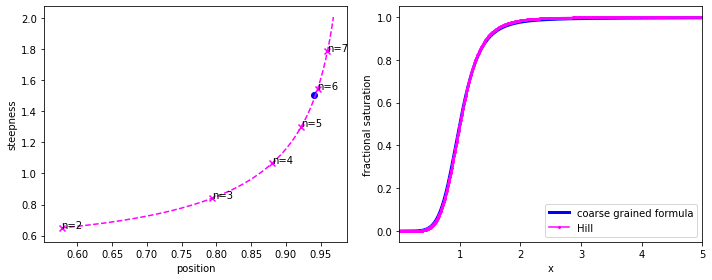

[6.20789511e-01 8.60692463e+01 2.58831362e-02 1.12882469e-02
 1.43235461e-04 7.65754657e-02]
[0.00013091 0.00113589 0.0028437  0.00025992 0.00289326 0.00012017]
[140.59356713 101.11703069  87.75738012 124.17893073 185.93880622
  89.7445921 ]
[1.04093907e+00 3.29447603e-04 7.47597922e+00 1.91214498e+00
 1.54596465e-03 4.35443778e-01]
[1.00000000e+00 9.23484163e+05 1.34827346e-05 2.50057126e+00]
effective parameters
0.00013440151492003077,0.0012290850938918906,0.0028639655083369047,0.00026510809273930523,0.002893253051809938,0.00012143690058750201,352.40983226355604,56.22342415909863,159.58269814780212,1.9669697134898059,90.60321576806406,1.641635645988907,4.702708189177522,1.0051169188667823,49.6208962345532,52.16420341407815,1.0254507426734978,26.664237883756055,1.4303526489960399,76.08375346336686,1.6882270606514809,25390.18816667804,128329.07312220901,80355.51122630402,23164.346641284657,11771.536496344821,29358.17310681731,20333.241053075224,321477.69912315276,76616.8161698706,42967

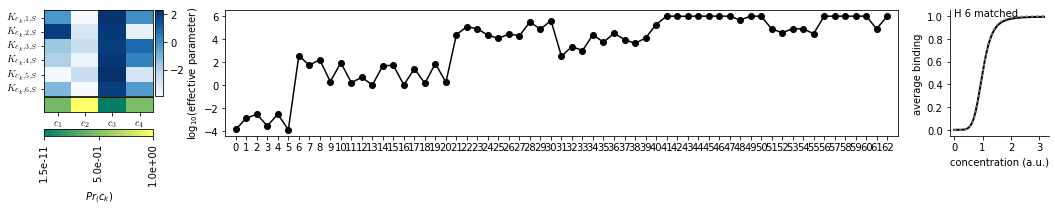

673 j=35
final_nt6_plim4_plimc6_c4_beta0.75_1772.out
error 1.9770042590925072
15.019336274528863,1.704983014073491,0.00012351089861035533,19.24764243479355,0.000747621652047679,1.4467090216052811,0.00018455775117775546,0.0001215334720198674,0.00011855562680521481,0.006127467791868855,0.0012090614083450604,0.007599063989877555,125.52112762554569,309.4357413436082,257.2668473720488,47.06428881277192,169.5486360173966,381.52035079033504,0.052087273343189494,0.00013005312595234676,0.02235679730427246,48.954051629015844,0.060722330831986485,0.00022899883519617581,385827.2683888286,1e-06,0.00029528584977808975
0.9409935081813683 1.5054181157695863
function evaluated between 0.01 and 10.00


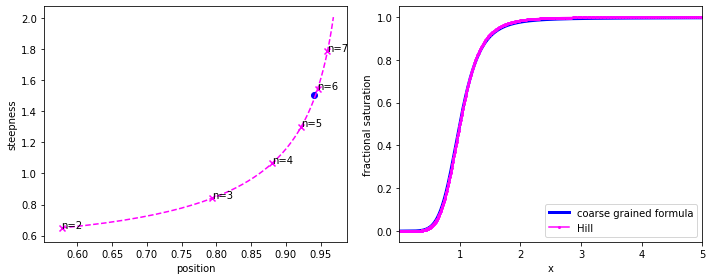

[1.50193363e+01 1.70498301e+00 1.23510899e-04 1.92476424e+01
 7.47621652e-04 1.44670902e+00]
[0.00018456 0.00012153 0.00011856 0.00612747 0.00120906 0.00759906]
[125.52112763 309.43574134 257.26684737  47.06428881 169.54863602
 381.52035079]
[5.20872733e-02 1.30053126e-04 2.23567973e-02 4.89540516e+01
 6.07223308e-02 2.28998835e-04]
[1.00000000e+00 3.85827268e+05 1.00000000e-06 2.95285850e-04]
effective parameters
0.0002234851543331627,0.00012595297949802124,0.00011855632345877944,0.006177376046959049,0.0012090606973580093,0.007602794896633031,2362.2419189948555,4.166187050073859,543.5587623194318,1.1376667061822299,34.043299395592825,14.818878422192043,110.32347914313901,1.8795274940027806,7.9601067349976145,1.0443194593313965,1.7886999712674505,1.2822487163208185,0.9999861145812667,2.5291164887586457,1.018051046284753,523862.59784199315,66839.46263869878,267605.5265834384,78910.58265035089,23588.0145080032,247652.56368016457,123652.30739961278,1891.7883126250763,41054.25743372409,100

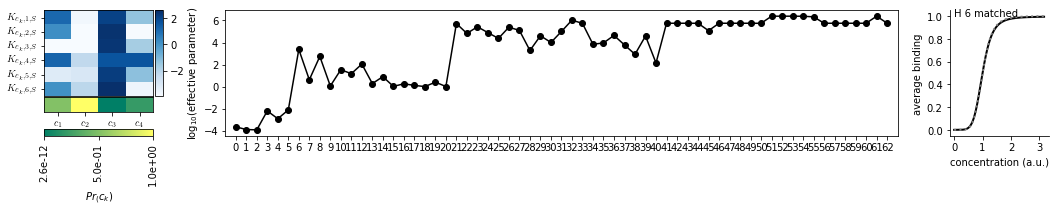

606 j=36
final_nt6_plim4_plimc6_c4_beta0.75_1232.out
error 1.977009818736188
0.014740834705134626,0.00010907899581377102,1.689984323147901,0.00016481207526202897,0.00010426909954905113,0.0001255592815284599,1.8520162920572798,2.5438751365190875,2.0365133116770013,2.719222394851361,3.195637595855467,4.791653822372134,0.00017665534398603116,0.00012257479620791063,0.0001,0.00010693049841760833,0.0001003331745526188,0.00012163197460395027,0.00016519197165682057,0.00013051119269541468,9.749949147691199,0.00010257783823211682,0.061771127630184636,0.00289629326729627,1.1209758800779646e-06,406119.44178153283,1.4264363030206937e-06
0.9420542208601537 1.505319677818348
function evaluated between 0.01 and 10.00


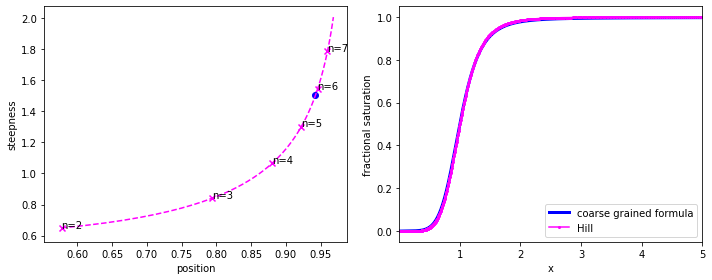

[1.47408347e-02 1.09078996e-04 1.68998432e+00 1.64812075e-04
 1.04269100e-04 1.25559282e-04]
[1.85201629 2.54387514 2.03651331 2.71922239 3.1956376  4.79165382]
[0.00017666 0.00012257 0.0001     0.00010693 0.00010033 0.00012163]
[1.65191972e-04 1.30511193e-04 9.74994915e+00 1.02577838e-04
 6.17711276e-02 2.89629327e-03]
[1.00000000e+00 1.12097588e-06 4.06119442e+05 1.42643630e-06]
effective parameters
0.00017669121082186036,0.00012257476999818882,0.00010416108213128395,0.00010693064844609059,0.00010033319328108915,0.00012163199750961042,1.0005780020915624,4.293375359035665,1.000845486448506,1.0009293212105737,1.0011461637410035,0.9967215257898207,1.0014564543855429,1.001824365908472,1.0022565246518216,1.0229961003330634,1.0034878849770335,1.003423185025198,1.0022355081607253,1.0027650322277468,1.0034631699771683,15.71682074029278,16.2453410530846,20.08734360645377,24.598420818005845,20.021053220176746,22.362062047362983,26.593269331183322,24.378558602253104,29.900980555655817,37.172544

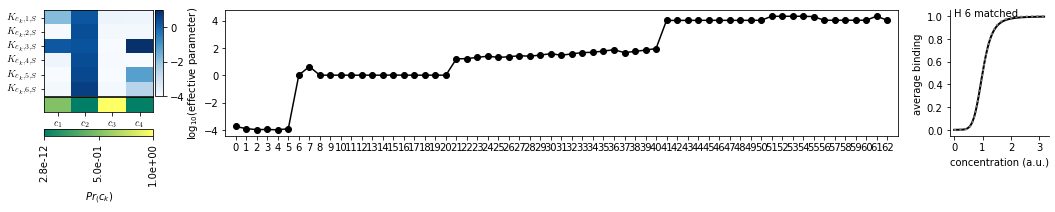

58 j=37
final_nt6_plim4_plimc6_c4_beta0.25_1482.out
error 1.9770216755988845
0.0001,0.2814512436532838,0.0019269573172388844,0.03054504289882899,0.010755591806991118,0.0001,79.46579894907828,92.5334337364386,61.214391287446,78.76661547119262,74.23951549633905,79.59377493422899,0.008272343490050234,0.00013057058021888936,0.36727479758595816,1.9550207425728265,2364.7973166046418,21.22525379847724,0.0010793503569340175,0.0001,0.00010408415278423692,0.00012549372916148164,0.0006083867046006866,0.005512021865347091,5.588195419356083e-06,0.00022560848255162152,386368.5840047228
0.9408948513391464 1.5054720589393493
function evaluated between 0.01 and 10.00


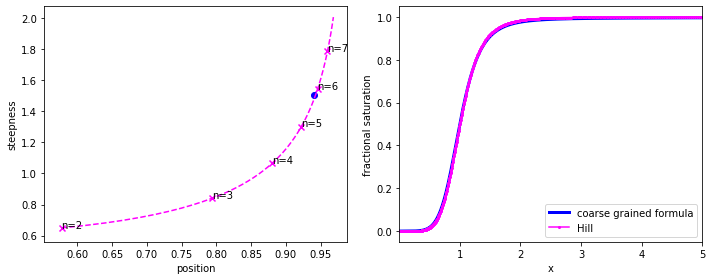

[1.00000000e-04 2.81451244e-01 1.92695732e-03 3.05450429e-02
 1.07555918e-02 1.00000000e-04]
[79.46579895 92.53343374 61.21439129 78.76661547 74.2395155  79.59377493]
[8.27234349e-03 1.30570580e-04 3.67274798e-01 1.95502074e+00
 2.36479732e+03 2.12252538e+01]
[0.00107935 0.0001     0.00010408 0.00012549 0.00060839 0.00551202]
[1.00000000e+00 5.58819542e-06 2.25608483e-04 3.86368584e+05]
effective parameters
0.001079348975709417,0.00010072953036781975,0.00010408997049733602,0.00012557474162709975,0.0006097948906632183,0.005512021399696159,1.9716290317456366,1.6261898655081979,1.6674053553356634,1.1446886387680717,1.0153924327085082,8.940251295447643,11.08513212303453,2.738517154854266,1.1847466383686134,6.378257930909868,10.023977214488278,1.130699703560985,37.366902761002954,1.1653715186485758,9.742877692026328,64346.4477061318,55351.415200006886,43487.90766870405,11923.455625699886,61584.42149498673,7611.974409210998,7998.407847348542,2183.419289983247,8277.28294044468,199.10245200822

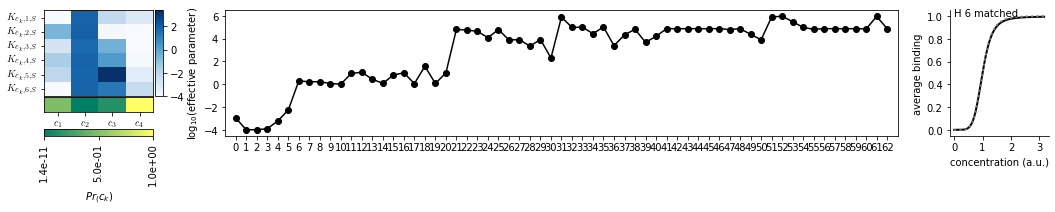

412 j=38
final_nt6_plim4_plimc6_c4_beta0.5_1996.out
error 1.97712758091455
0.255726378799771,0.0004495575781368008,0.0005922340937580884,0.08262677441898629,0.00031701230181893587,0.5685258481503789,7.413209236233913,0.0002190340426642328,0.00021929791263337488,0.09696868837728265,2.8119890475537814,0.0356240800899319,36.160786548867854,30.839875251301024,31.48299495378651,45.32622043303611,29.63005203839011,29.568640105745555,0.00010980891639843861,0.0002443132244446183,0.0001,0.001391665830394016,0.00023904867094170528,0.00011152893724834346,9.543869688077938e-06,1e-06,59761.419167202504
0.940745594997754 1.5055052004794005
function evaluated between 0.01 and 10.00


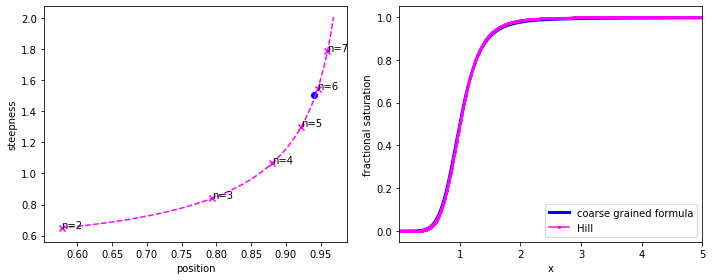

[2.55726379e-01 4.49557578e-04 5.92234094e-04 8.26267744e-02
 3.17012302e-04 5.68525848e-01]
[7.41320924e+00 2.19034043e-04 2.19297913e-04 9.69686884e-02
 2.81198905e+00 3.56240801e-02]
[36.16078655 30.83987525 31.48299495 45.32622043 29.63005204 29.56864011]
[0.00010981 0.00024431 0.0001     0.00139167 0.00023905 0.00011153]
[1.00000000e+00 9.54386969e-06 1.00000000e-06 5.97614192e+04]
effective parameters
0.00011408791788019681,0.000244317174815882,0.00010000876333546203,0.0013930259049477294,0.00023905092032219056,0.00012104067111872431,1.7009519573218566,2.8541066001123827,3.3595173958342457,1.7916441019432114,178.353321661335,1.6649803238963579,1.0695430150033107,1.2618018902442838,1.5819818229017923,1.176192652284804,1.65292948432503,2.6735385050727785,1.067929010409414,5.7152944673094845,1.5328286927738908,126578.62167949263,20371.429408144915,65763.59849284418,103583.2484926022,46199.032802134556,125198.43343725866,152943.84365578182,20040.651696114353,9204.515929029354,104941.

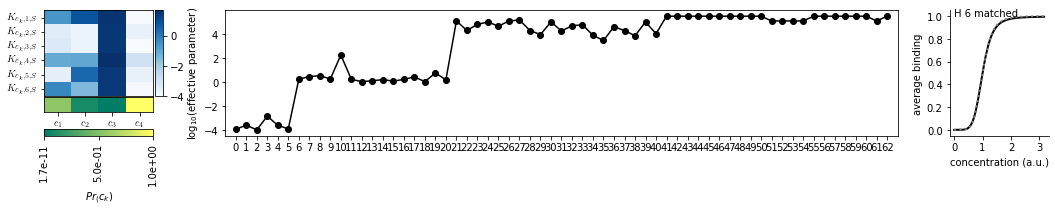

193 j=39
final_nt6_plim4_plimc6_c4_beta0.25_2571.out
error 1.9771435475819439
0.00010684671698215255,2.399668506398384,0.00026677885809690767,33.00067527695145,0.3569805901538664,0.5112988508865197,195.14441634605134,172.9983926324577,239.9235943025804,270.99405798749376,178.09267303230024,221.7290765245048,0.00010702913592081382,0.0005348940793507494,1461.5877525658614,0.013449203560868204,0.06937675723100753,96.19183835201011,0.0074919555870050555,0.004930210898837018,0.008887611944840092,0.005822572397610026,0.005938102724733627,0.010112796554235191,6.034409884265281e-06,0.006721694231856683,875401.1575853307
0.9415040763526279 1.5053661033430263
function evaluated between 0.01 and 10.00


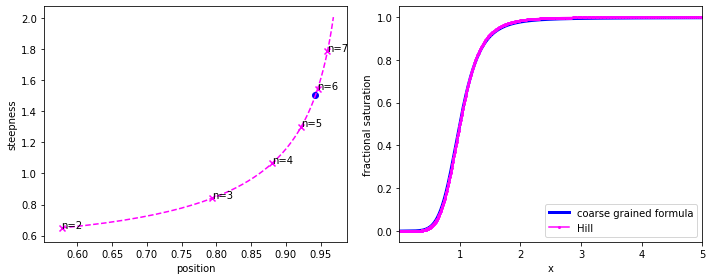

[1.06846717e-04 2.39966851e+00 2.66778858e-04 3.30006753e+01
 3.56980590e-01 5.11298851e-01]
[195.14441635 172.99839263 239.9235943  270.99405799 178.09267303
 221.72907652]
[1.07029136e-04 5.34894079e-04 1.46158775e+03 1.34492036e-02
 6.93767572e-02 9.61918384e+01]
[0.00749196 0.00493021 0.00888761 0.00582257 0.0059381  0.0101128 ]
[1.00000000e+00 6.03440988e-06 6.72169423e-03 8.75401158e+05]
effective parameters
0.007491948439190992,0.0049329476440298555,0.008898826348387127,0.00586026540382782,0.005938505446551544,0.010114109125981248,1.0057498011518664,1.0035985393560178,1.001962507666764,1.0053176187377058,1.0038081525633864,1.0048557883204094,4.133462103670314,1.0400306565765063,1.0327141618290017,1.0039962207881439,1.018979878868752,12.996957038052631,1.3897514587799,1.325789672530667,1.0086578351933482,169.94429537517985,70.6964328392068,182.5325233719486,134.6395965883001,223.9546815231164,143.4531069871103,8.255504989158455,179.88780650881503,138.04676989965097,118.0243466962

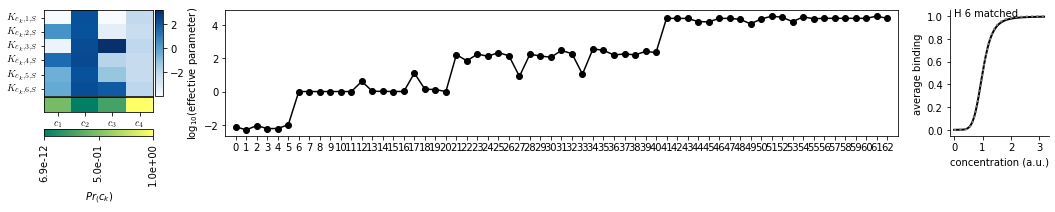

580 j=40
final_nt6_plim4_plimc6_c4_beta0.75_1016.out
error 1.9773809739989407
0.09766592122838855,0.10074534369462004,0.04046276953523906,0.00010084284139769221,0.00013266948927230559,0.00013049580317218057,0.0001,0.0017441338365338053,0.0001156927538790888,0.00010250210305229692,0.016321930120650068,0.0001,0.00020443389622270994,5.683174473901235,0.00033950636996403987,0.005517325837184788,0.00020045927514839823,6.998927626654483,47.450902897753686,47.41063008561627,109.32520429964667,132.99076949813045,92.6148221346631,113.79080330081369,446457.8908661975,0.2298663525115167,1.507161483048894e-06
0.9417125618051567 1.505400072415364
function evaluated between 0.01 and 10.00


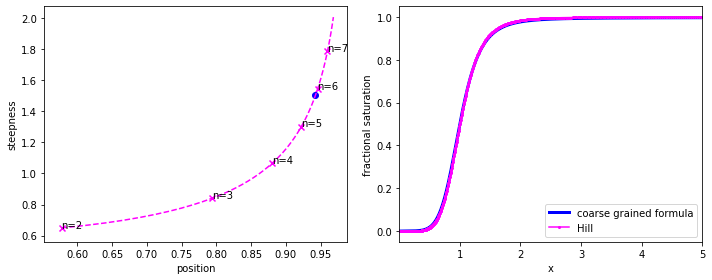

[0.09766592 0.10074534 0.04046277 0.00010084 0.00013267 0.0001305 ]
[0.0001     0.00174413 0.00011569 0.0001025  0.01632193 0.0001    ]
[2.04433896e-04 5.68317447e+00 3.39506370e-04 5.51732584e-03
 2.00459275e-04 6.99892763e+00]
[ 47.4509029   47.41063009 109.3252043  132.9907695   92.61482213
 113.7908033 ]
[1.00000000e+00 4.46457891e+05 2.29866353e-01 1.50716148e-06]
effective parameters
0.00010021874666358947,0.0017472809160014925,0.00011578360944162477,0.00010250533619249602,0.01632188587139516,0.00010360390660743751,1.1686593520200574,3.2690526658170422,3.0736998876398016,1.0069045283513227,2.7923199710648348,1.1339454492949632,1.2072698466122724,0.9987402018743388,114.19412300195897,5.135516163200722,1.0173084244982629,4.568349809562508,1.024820883663146,7.647726388968181,0.9866804415594003,36153.012982078486,46608.73620252198,247.40033941018365,419.16302308169077,381274.820964681,8418.897234627302,362843.25358273165,11482.79586898994,297816.13779574615,10096.7196993614,21850.444

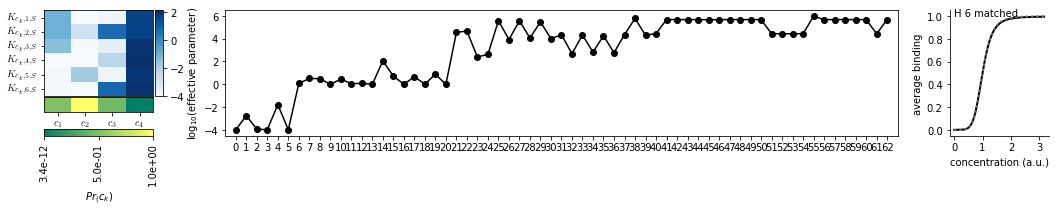

26 j=41
final_nt6_plim4_plimc6_c4_beta0.25_1221.out
error 1.977447949669108
2.1546359618524598,0.13937897937543753,0.05900542263975222,2.0146047727541094,0.004938222749158687,0.37134872993656065,18.006393612148397,39.64130302426321,31.553447355128355,93.09623164141375,31.428721145293682,32.96929406045483,0.0005202627755245655,0.008756936233793026,5269.146291288229,0.008665172623864755,84.1533109755951,0.03141278606248393,0.0001778840993580097,0.0014665271350925745,0.00012123222218558741,0.00011684841110794901,0.0021860978460494992,0.0009321879551386074,5.7688773447561725e-06,9.243501451551538e-05,1000000.0
0.9411906434220506 1.5053996224476454
function evaluated between 0.01 and 10.00


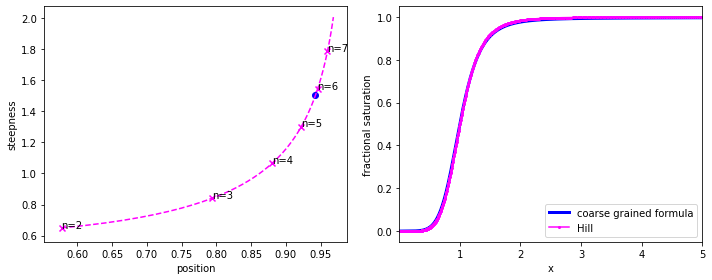

[2.15463596 0.13937898 0.05900542 2.01460477 0.00493822 0.37134873]
[18.00639361 39.64130302 31.55344736 93.09623164 31.42872115 32.96929406]
[5.20262776e-04 8.75693623e-03 5.26914629e+03 8.66517262e-03
 8.41533110e+01 3.14127861e-02]
[0.00017788 0.00146653 0.00012123 0.00011685 0.0021861  0.00093219]
[1.00000000e+00 5.76887734e-06 9.24350145e-05 1.00000000e+06]
effective parameters
0.00018003865918828915,0.0014666652767579035,0.0001217783414598138,0.00011886343486730235,0.0021861085579699653,0.0009325585643178537,2.140830348827556,6.943339797751982,204.26115781752054,1.0233658358815263,5.7735925135080315,1.1057461763979128,2.715748537420403,1.0023774486319914,1.0428616544974538,10.653184907310067,154.97733542433647,1.3756271351302893,1.086544735230841,7.891511434390985,1.0035481594995306,4153.489749494468,11595.609834343326,227.21073724581214,963.869174743616,20216.600063018537,16.82966139073974,5521.584948059028,6401.791148534422,12259.74883371121,303.92614250580715,3043.734327380992

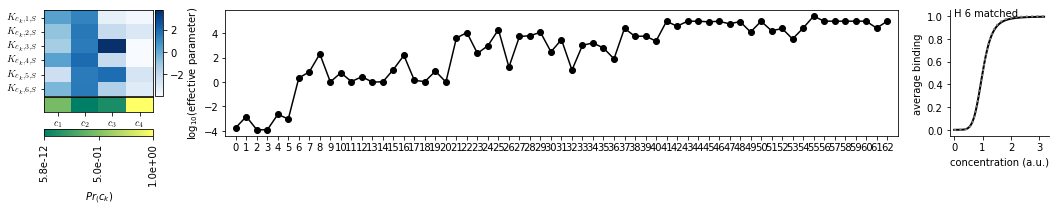

532 j=42
final_nt6_plim4_plimc6_c4_beta0.5_628.out
error 1.9775284331112961
52.00736391685872,2.3179206064053868,0.13304190938741556,0.00038912670709482193,0.00011071436902506396,0.0001,0.0003592432329615754,0.00010575512052819786,0.0012032052150532312,0.00010441447044792471,0.0030761112527736244,0.00012805649891433756,37.69559866607332,64.88773460191685,37.14837021181794,44.88946279206188,34.49997243227093,31.89688815410513,0.00017691573084083613,0.0001,0.0177221453249813,0.00011464466623562786,0.0011198058073510753,0.0001,1000000.0,1.083761277884965e-05,1.4532990711219042e-06
0.941053583278862 1.5053637528884591
function evaluated between 0.01 and 10.00


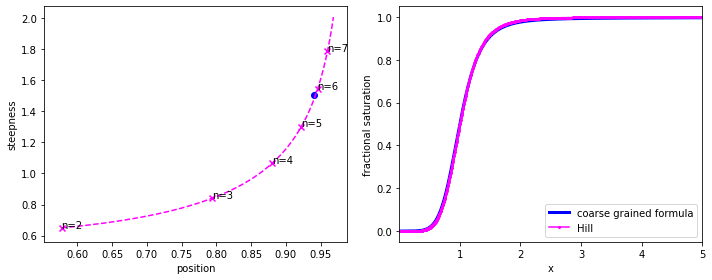

[5.20073639e+01 2.31792061e+00 1.33041909e-01 3.89126707e-04
 1.10714369e-04 1.00000000e-04]
[0.00035924 0.00010576 0.00120321 0.00010441 0.00307611 0.00012806]
[37.69559867 64.8877346  37.14837021 44.88946279 34.49997243 31.89688815]
[0.00017692 0.0001     0.01772215 0.00011464 0.00111981 0.0001    ]
[1.00000000e+00 1.00000000e+06 1.08376128e-05 1.45329907e-06]
effective parameters
0.00041125059415334425,0.00010807363628792569,0.0012033374562357797,0.00010441524165288899,0.0030761086612404935,0.0001280568165422151,2713.744589322141,14.885773860179249,1.7718864678269985,0.8892311973808928,1.2197255984188728,3.550575703335051,3.8558806623770407,1.0522968645705426,2.6160629747114865,1.1441292314431588,1.003646270017594,1.0833086718483207,1.0522479430937146,2.1605299231084327,1.0302732081722732,89643.6515011425,69120.96381537404,6450.3867294586225,57598.085516163366,11569.557314742005,344.06529535702873,7062.08485215409,4552.789144221682,49236.61751513153,2694.4170968206854,75488.91100955

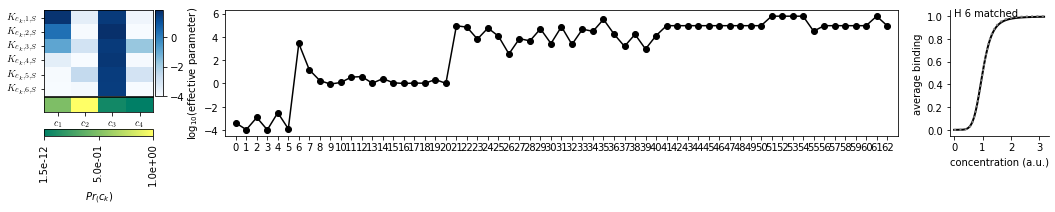

75 j=43
final_nt6_plim4_plimc6_c4_beta0.25_1608.out
error 1.9776070047630214
0.022314066884303117,0.02288892909854307,62.73226769899985,22.827897910260937,14.484533740019183,0.00014216106385629373,0.00012269252607986385,0.0002257536072190448,0.00025432798893759267,0.016956599559566306,0.00010154401135291026,0.00015907467754085723,333.91535886804985,190.71440549335236,128.37789267388604,988.4681330752212,52.231778791274444,208.41082596214088,0.0001132724093478423,388.55050692065373,0.0003404745525611962,0.00015221776429146704,1.3920803959513894,0.005234502316406652,961650.4083858441,1.121369312152214e-06,1.8751502870695922
0.9411314633718278 1.5047822105906834
function evaluated between 0.01 and 10.00


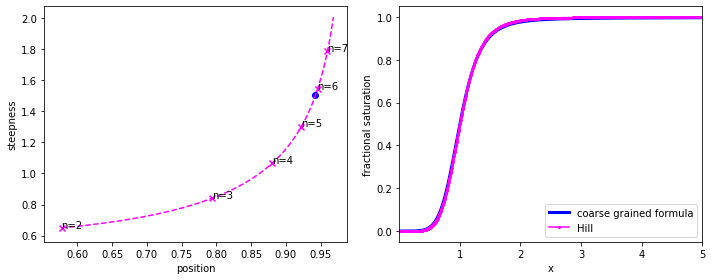

[2.23140669e-02 2.28889291e-02 6.27322677e+01 2.28278979e+01
 1.44845337e+01 1.42161064e-04]
[0.00012269 0.00022575 0.00025433 0.0169566  0.00010154 0.00015907]
[333.91535887 190.71440549 128.37789267 988.46813308  52.23177879
 208.41082596]
[1.13272409e-04 3.88550507e+02 3.40474553e-04 1.52217764e-04
 1.39208040e+00 5.23450232e-03]
[1.00000000e+00 9.61650408e+05 1.12136931e-06 1.87515029e+00]
effective parameters
0.00012271597335853314,0.0009834207007351384,0.0003195618106708893,0.016980288491303095,0.00011932033531859012,0.00015908479967268285,1.5603776432931808,39.18930243501896,1.4373206073480724,25.21431437372637,5.156750486361706,5.845583380613234,0.2818468551314441,8991.490769852426,25.875496665774065,275.2563609499712,24781.268775255692,1.5920002979913146,170.58387145242546,1.088716399317522,2.381022262138,42435.95017476474,127112.5988239492,30.93914634598477,31154.818535539624,450.8708189751981,204.3447713714278,1048957.9874604694,654.8881905577666,222260.39374036496,764221.40

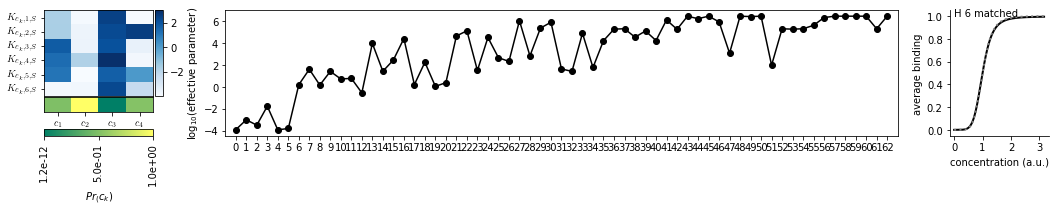

852 j=44
final_nt6_plim4_plimc6_c4_beta0.75_872.out
error 1.9776112011985376
0.002220342136508898,0.0001960395600621402,0.00665706500758602,11.753888317946304,0.005734751103943026,0.3556295025041757,0.00010627721875289869,0.00010831491620805958,0.00011665766500491645,101.87210929603962,0.0001608104036006988,0.00012545655420411638,0.00013713753298453968,0.0007736899519048491,0.0001672721722663315,0.0004985188065276735,0.0001121317689703175,0.00011337791442342759,105.47385529955335,19.39348383331384,27.672596507168887,14.047221716067499,39.648374811244686,19.472534383536857,0.00045175422607131847,166466.07426663453,1e-06
0.9407959571583103 1.5054822517153104
function evaluated between 0.01 and 10.00


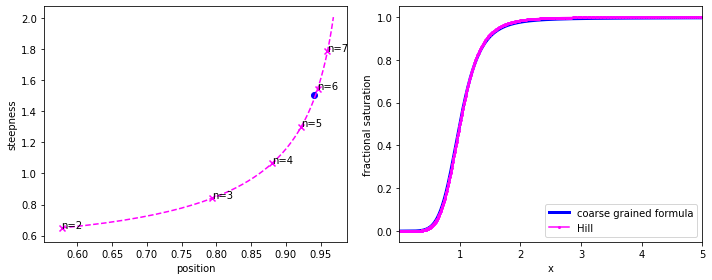

[2.22034214e-03 1.96039560e-04 6.65706501e-03 1.17538883e+01
 5.73475110e-03 3.55629503e-01]
[1.06277219e-04 1.08314916e-04 1.16657665e-04 1.01872109e+02
 1.60810404e-04 1.25456554e-04]
[0.00013714 0.00077369 0.00016727 0.00049852 0.00011213 0.00011338]
[105.4738553   19.39348383  27.67259651  14.04722172  39.64837481
  19.47253438]
[1.00000000e+00 4.51754226e-04 1.66466074e+05 1.00000000e-06]
effective parameters
0.00013715068071590996,0.0007736865965370165,0.00016731132380672003,0.0005694002393661997,0.00011216578344193586,0.0001155136857347614,1.115727293822841,1.7676210893420738,2.997281856170802,2.637557010896746,2.059581909739558,1.024729911767946,0.9107175121689305,1.052999337093955,1.0115786526822126,5.83408598926088,1.3628825825486466,1.8846207473450025,7.268333382174369,382.6531706953722,2.2847222157540648,18691.62742822791,3138.4031973076453,38873.780845771005,19298.43841841066,3244.886579788098,198176.229145677,68352.06250291714,5556.942888762816,66.36212522103216,120493.83

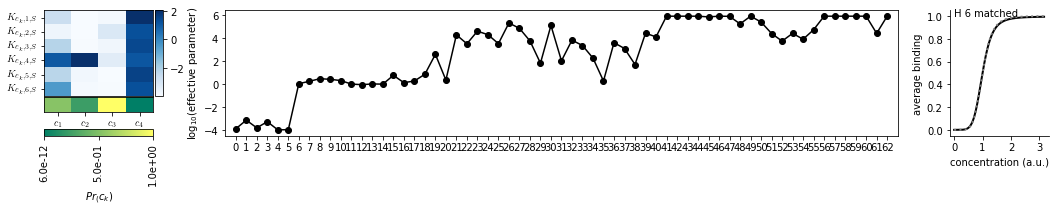

818 j=45
final_nt6_plim4_plimc6_c4_beta0.75_602.out
error 1.9778478478405321
0.00011460284348684066,0.0001046286716960159,0.020467493151967997,3.352116320796187,0.08360294088822495,0.9363558696980961,0.001606052140463942,0.0005428376563385848,0.0023735266553966032,0.0014700758542317842,0.0004593943393685613,0.0025292470790448103,97.34626060794743,44.01500392243509,44.15213028942458,98.78087678710803,103.41930858182145,57.541398062417954,0.41285975049983054,0.14462896084197185,0.007175020518173743,0.006073418396137486,18.986039431307635,0.00011742412586395114,290914.5060811888,2.335268735109415e-06,1.1294271739587862e-06
0.9410949450371149 1.5054546214326088
function evaluated between 0.01 and 10.00


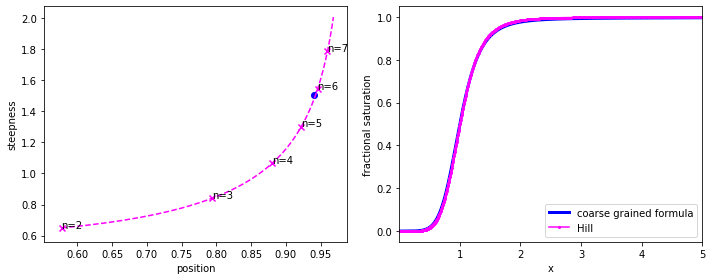

[1.14602843e-04 1.04628672e-04 2.04674932e-02 3.35211632e+00
 8.36029409e-02 9.36355870e-01]
[0.00160605 0.00054284 0.00237353 0.00147008 0.00045939 0.00252925]
[ 97.34626061  44.01500392  44.15213029  98.78087679 103.41930858
  57.54139806]
[4.12859750e-01 1.44628961e-01 7.17502052e-03 6.07341840e-03
 1.89860394e+01 1.17424126e-04]
[1.00000000e+00 2.90914506e+05 2.33526874e-06 1.12942717e-06]
effective parameters
0.001606047796732305,0.000542836503905497,0.002373589206457257,0.0014815942396616286,0.0004596810428905101,0.002532457499146463,1.0394531108586855,1.009025622663833,1.0252194345843986,1.1089265377871933,1.0098775129130795,1.0120853626969382,1.037118951142523,1.1459738259032612,1.0137649867383938,1.0692143983149467,1.0383318161601864,1.0130548139679372,2.5264639343782864,3.8786800821501077,1.2702924248266707,726.0772792887509,2537.121955038006,7746.085292026347,885.2115525138698,565.2917687101211,1961.999915368275,203.98014198585162,2889.1583767117086,190.3412433404362,1958.78

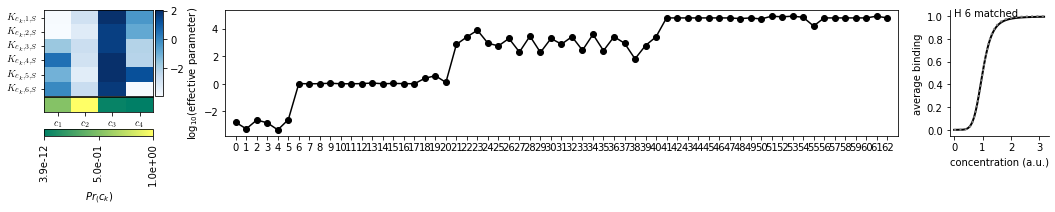

209 j=46
final_nt6_plim4_plimc6_c4_beta0.25_348.out
error 1.9779532426610087
0.0008679472832246963,0.13637466664742642,0.8243690000580451,0.07067268867981921,0.22797948446393407,127.3500153073038,118.46592691501472,35.46871163515063,120.32598201106039,25.949520379189405,255.7802070468808,352.2209227325389,0.0002551267255239404,0.0025318340211869846,0.0034501643957675146,0.00014660232882429499,0.00021697812390318637,0.0015110862040499664,0.0008705745282486428,1.9740049908907715,0.7537527107000151,1986.2250500007228,0.27033144394511477,0.0022923592945649,1e-06,997526.4420533946,1.0236750765696873e-06
0.9410211306424086 1.505502382750557
function evaluated between 0.01 and 10.00


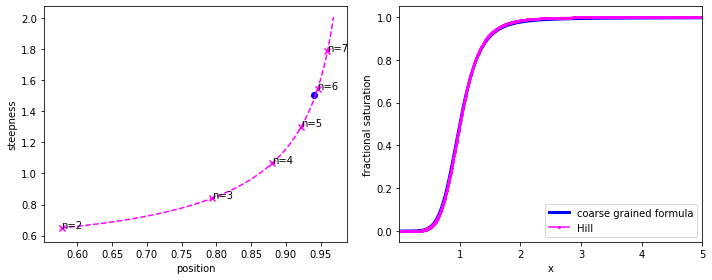

[8.67947283e-04 1.36374667e-01 8.24369000e-01 7.06726887e-02
 2.27979484e-01 1.27350015e+02]
[118.46592692  35.46871164 120.32598201  25.94952038 255.78020705
 352.22092273]
[0.00025513 0.00253183 0.00345016 0.0001466  0.00021698 0.00151109]
[8.70574528e-04 1.97400499e+00 7.53752711e-01 1.98622505e+03
 2.70331444e-01 2.29235929e-03]
[1.00000000e+00 1.00000000e-06 9.97526442e+05 1.02367508e-06]
effective parameters
0.00025512745862343086,0.002531968233351292,0.003450987470794472,0.00014667509402512522,0.0002172067076525915,0.0016387507184004763,1.0066475756691153,1.0168026393838232,1.0835446449261232,1.5506805238406753,1.2871735168898146,1.0130955084567186,1.0387849787541736,1.0721042362603883,5.121076783192021,1.123868505703705,1.2912178474285854,19.539094752187324,1.7315824968584776,38.496512175250636,82.94293258298516,225.451463247516,1111.652729591702,7163.456810589555,276.6453027152929,2556.212252838516,14803.477131899768,181.82315050563994,56007.64806771462,463.13718672002005,1423

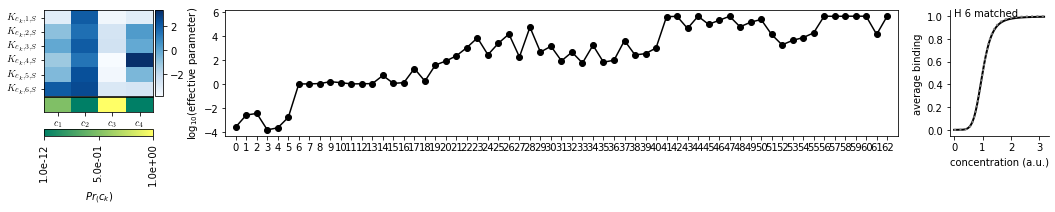

22 j=47
final_nt6_plim4_plimc6_c4_beta0.25_1185.out
error 1.9780084120840478
0.00011366407656510818,25.660944141203952,6.9721724803420795,0.19388511588008953,1.1058531608748607,7.092094474380575,0.00294389270270803,3.0975632292443644,0.006086135234788163,0.00013142229003650983,4.279159739759513,251.80774075073896,0.0001,0.035252859986868106,0.009180433597511929,0.043352980985178834,0.00026810753888952953,0.03336086349433046,1742.6336744482473,288.7559081924506,616.6220604488021,1587.5963136721934,560.2678781900045,301.13652859897377,42.142517428199916,1000000.0,1e-06
0.9419492123421699 1.5048318142867654
function evaluated between 0.01 and 10.00


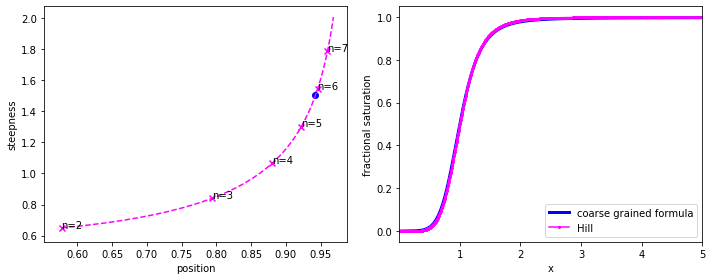

[1.13664077e-04 2.56609441e+01 6.97217248e+00 1.93885116e-01
 1.10585316e+00 7.09209447e+00]
[2.94389270e-03 3.09756323e+00 6.08613523e-03 1.31422290e-04
 4.27915974e+00 2.51807741e+02]
[0.0001     0.03525286 0.00918043 0.04335298 0.00026811 0.03336086]
[1742.63367445  288.75590819  616.62206045 1587.59631367  560.26787819
  301.1365286 ]
[1.00000000e+00 4.21425174e+01 1.00000000e+06 1.00000000e-06]
effective parameters
0.00010012159984931509,0.035407532762003924,0.00918726650985983,0.043351311711592774,0.0004495291224107017,0.043977870676988925,1.2455367754610684,2.1678150163868075,1.6361682021776918,34.08531887654167,7.971635404326364,1.5478090782897045,0.9991780061990899,37.48025088698211,21.9808439675603,1.005103493159857,2.8121581958878674,1.0406660136575412,0.654274932399428,0.7602828961929103,2297.7322407386823,6155.83799159896,5203.231914129914,4747.472389257782,72.49288269347161,42562.73787138384,517718.41452967527,7691.550971315578,1214158.5053242631,5741.548707920822,94.0364

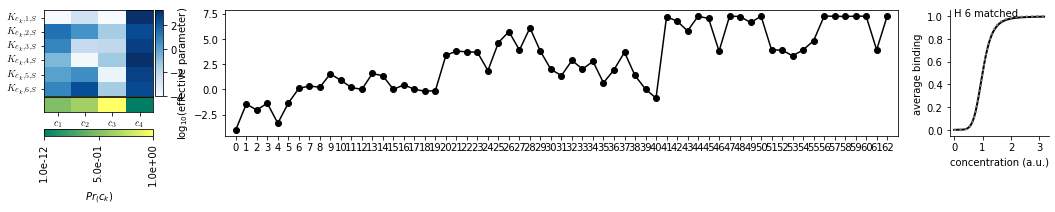

449 j=48
final_nt6_plim4_plimc6_c4_beta0.5_2302.out
error 1.9781575542255105
0.0001,0.0001395432811074684,0.02853870990399512,0.0001274574241371001,0.06228828313547566,0.05366036937085852,0.001270515490436424,0.015215483669505958,0.00011534187599039737,0.0005875846078059105,0.00017349300265952442,0.00011539211125696144,7.360529926747598,6.4963451934799865,5.355815114582991,7.389947841961824,5.238912367458768,8.387686718373153,0.00014010334094221325,0.00011164775402646,0.00010286355963005837,0.00012076437422824201,0.0001050869879004514,0.00016880724874583322,1.0918813175315034e-06,1e-06,78448.47319401932
0.9409731783431926 1.5054542370770532
function evaluated between 0.01 and 10.00


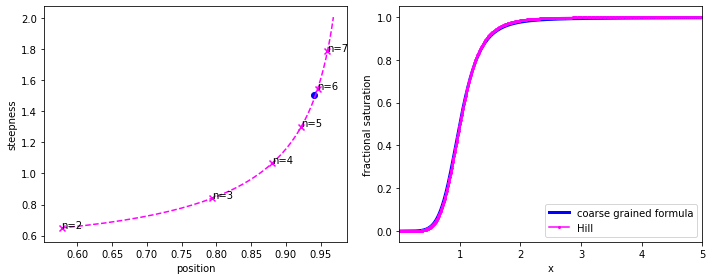

[0.0001     0.00013954 0.02853871 0.00012746 0.06228828 0.05366037]
[0.00127052 0.01521548 0.00011534 0.00058758 0.00017349 0.00011539]
[7.36052993 6.49634519 5.35581511 7.38994784 5.23891237 8.38768672]
[0.0001401  0.00011165 0.00010286 0.00012076 0.00010509 0.00016881]
[1.00000000e+00 1.09188132e-06 1.00000000e-06 7.84484732e+04]
effective parameters
0.00014010292358164331,0.00011164819263045338,0.00010322610128791171,0.0001207645537499918,0.00010587970750067211,0.00016948921571644575,1.0389639993772446,1.0337398042328687,1.0409785175557384,1.0309918316525761,1.0319886407621037,1.0393584413941235,1.04538543004749,1.0385682150813844,1.0377089677206677,1.040664539429694,3.0949736065608424,2.140944364226448,1.0390093139861805,1.0388237460899312,3.393908523570226,1946.1424739368165,2281.9009834918274,1857.4093783746516,1859.2546151050626,2044.1043923150075,556.2916634296064,803.9966195326265,1952.524261101917,1953.1962810800212,483.96089182475185,2263.8056759623346,616.3830565786461,890.

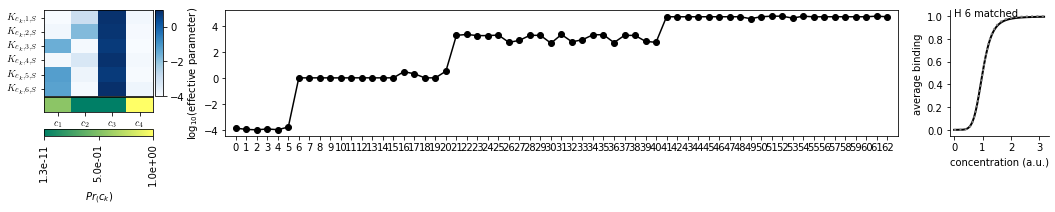

651 j=49
final_nt6_plim4_plimc6_c4_beta0.75_1601.out
error 1.9781895102026879
5.021185874343607,0.0001715988268057853,0.0001371046693113289,0.00011549388531668413,0.00013650213795299277,1.1943113503774818,16.87853610131021,14.438924553844702,20.034537480143243,9.95496971035034,9.46470005439456,12.436597255681843,0.0005371573040069426,0.0006752281190462054,9.213903750367784,0.0003686369428604377,0.28937548699735927,10.929434690102477,0.00041337020852750547,0.0002332426237073879,0.00012610986148112464,0.00010450337102638247,0.0009975833515007487,0.000269009066565573,3.3357887743028008e-06,0.01323735722661467,428636.4475711555
0.9412791135054558 1.5052744492470544
function evaluated between 0.01 and 10.00


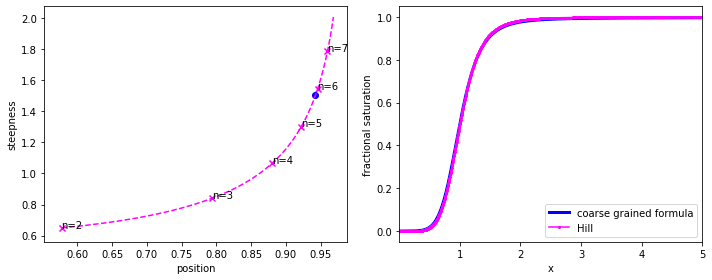

[5.02118587e+00 1.71598827e-04 1.37104669e-04 1.15493885e-04
 1.36502138e-04 1.19431135e+00]
[16.8785361  14.43892455 20.03453748  9.95496971  9.46470005 12.43659726]
[5.37157304e-04 6.75228119e-04 9.21390375e+00 3.68636943e-04
 2.89375487e-01 1.09294347e+01]
[0.00041337 0.00023324 0.00012611 0.0001045  0.00099758 0.00026901]
[1.00000000e+00 3.33578877e-06 1.32373572e-02 4.28636448e+05]
effective parameters
0.00042508367480992477,0.0002332426059099406,0.00012639458669197112,0.00010450348229587407,0.0009975903220744826,0.0002721323519033691,1.0118457769528533,1.0519690701772615,1.032332872024647,0.9791490413871979,121.91952366817787,1.0806278001629994,1.0458916606533095,1.0045876702809822,1.021660975288795,1.1231963325313445,1.6624759186820428,91.46948221357498,1.0070550488482397,1.0380899189343304,1.3530699490189655,2806.8145487271527,1743.2322438079896,181.6310010175871,943.7153548611443,4154.965575244405,280.60630464015713,27.165571219508898,278.2886346468403,1425.5675527928365,112.2

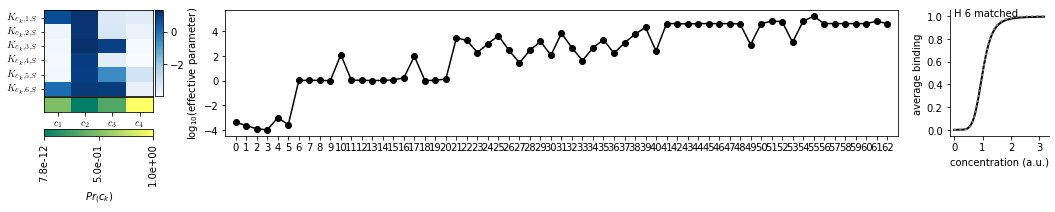

In [26]:
yticklabels=["$K_{c_k,%d,S}$"%(i+1) for i in range(6)]
xticklabels_4=["$c_%d$"%(i+1) for i in range(4)]
xticklabels_2=["$c_%d$"%(i+1) for i in range(2)]
c_conf=4
plimc=6
plims=[4]
for c_conf in [4]:
    for n_target in n_sites_list:
        print("matching Hill %d"%n_target)
        #for beta in betas:
        #print("beta",beta)
        for plim in plims:
            print("parameter limit is",plim)

            print("#new combi------")
        
            key="c%d"%c_conf
            if c_conf==2:
                psfunc=CG_c2_N6_samesitesFalse.interfaceps_a_GRF_CG_c2_N6_samesitesFalse_x
                GRFfunc=CG_c2_N6_samesitesFalse.interface_GRF_CG_c2_N6_samesitesFalse_x
                gpv=gpvc2
            elif c_conf==4:
                psfunc=CG_c4_N6_samesitesFalse.interfaceps_a_GRF_CG_c4_N6_samesitesFalse_x
                GRFfunc=CG_c4_N6_samesitesFalse.interface_GRF_CG_c4_N6_samesitesFalse_x
                gpv=gpvc4
            results_errors=results[n_target]
            results_n=[x[0] for x in results_errors]
            errors_n=[x[1] for x in results_errors]
            files_n=[x[2] for x in results_errors]
            print("n=%d"%n_target, "c=%d"%c_conf, "plim=%d"%plim)
            print(len(errors_n))
            if len(errors_n)==0:
                continue
            argsort_e=np.argsort(errors_n)
            j=0
            if min(errors_n)<2:
                max_plot=6
                max_error=3
            else:
                max_plot=3
                max_error=5
            for idx in argsort_e:
                #if j<max_plot: #plot only 3 best to start with
                error=errors_n[idx]
                if error<max_error and j<50:
                    print(idx, "j=%d"%j)
                    print(files_n[idx])
                    j+=1
                    parset=results_n[idx]
                    error=errors_n[idx]
                    print("error",errors_n[idx])
                    if error>10:
                        print("error>10. skipping")
                    else:
                    
                        #parset=l_[1] #.split(":")[1].strip()
                        print(",".join(map(str,parset)))
                        #parset=np.array(list(map(float,parset.split(","))))
                        plot_pars(parset,n_sites=n_target,psfunc=psfunc,GRFfunc=GRFfunc)
                        parvalues=gpv(parset)

                        fig=plt.figure(figsize=(18,2.3))
                        gs=gridspec.GridSpec(ncols=100,nrows=16,figure=fig)
                        g1=[0,11]
                        g2=[18,85]
                        g3=[90,100]
                        dx1=1

                        ax=fig.add_subplot(gs[0:11,g1[0]:g1[1]])
                        if c_conf==4:
                            mat=np.zeros((6,4))
                            c=0
                            for i in range(0,24,6):
                                pars_conf=parset[i:i+6]
                                print(pars_conf)
                                for s,site in enumerate(pars_conf):
                                    log10s=np.log10(site)
                                    mat[s,c]=log10s
                                c+=1
                        else:
                            mat=np.zeros((6,2))
                            c=0
                            for i in range(0,12,6):
                                pars_conf=parset[i:i+6]
                                print(pars_conf)
                                for s,site in enumerate(pars_conf):
                                    log10s=np.log10(site)
                                    mat[s,c]=log10s
                                c+=1
                            
                        im=ax.imshow(mat,cmap=plt.cm.Blues,aspect="auto")#vmin=-6,vmax=3

                        ax.set_yticks(np.arange(0,6))
                        
                        ax.set_yticklabels(yticklabels,useTex=True)
                        ax.set_xticks([])
                        #ax.set_xlabel("site")

                        #ax.set_xticks(np.arange(4))
                        #ax.set_xticklabels([1,2,3,4])
                        #ax.set_ylabel("conformation")

                        cax=fig.add_subplot(gs[0:11,g1[1]:g1[1]+dx1])
                        cb=plt.colorbar(im,ax=ax,cax=cax,shrink=0.9) #ticks=[-3,0,3] 
                        #cb.ax.set_yticklabels(["$10^{-3}$","$1$","$10^{3}$"],usetex=True)
                        #cb.ax.set_ylabel("$K_{ck,i,S})$")
                        ax=fig.add_subplot(gs[11:13,g1[0]:g1[1]])
                        if c_conf==4:
                            pars_conf=np.concatenate((np.array([1]),parset[-3:]))
                        else:
                            pars_conf=np.array([1,parset[-1]])
                        print(pars_conf)
                        mat_conf=pars_conf/np.sum(pars_conf) #probability empty conf
                        #print("min-max",mat_conf.min(),mat_conf.max())
                        cax=fig.add_subplot(gs[15,g1[0]:g1[1]])

                        if c_conf==4:
                            imc=ax.imshow(np.log10(mat_conf.reshape(1,4)),aspect="auto",cmap=plt.cm.summer)
                            ax.set_xticks(range(4))
                            ax.set_xticklabels(xticklabels_4,usetex=True)
                        else:
                            imc=ax.imshow(np.log10(mat_conf.reshape(1,2)),aspect="auto",cmap=plt.cm.summer)
                            ax.set_xticks(range(2))
                            ax.set_xticklabels(xticklabels_2,usetex=True)
                        
                        ticks=np.linspace(np.log10(np.min(mat_conf)),np.log10(np.max(mat_conf)),3)
                        cb=plt.colorbar(imc,orientation="horizontal",label="$Pr_(c_k)$",cax=cax,ticks=ticks)
                        cb.ax.set_xticks(ticks)
                        cb.ax.set_xticklabels(["%2.1e"%x for x in np.linspace(np.min(mat_conf),np.max(mat_conf),3)],rotation=90)
                        
                        ax.set_yticks([])
                        #ax.set_zlabel(,fontsize=16)
                        #ax.set_zticks(range(7))
                        #ax.set_zticklabels([-3,-2,-1,0,1,2,3])
                        #ax.view_init(30,-30)

                        ax = fig.add_subplot(gs[:, g2[0]:g2[1]])

                        parvalues_sorted=np.array(parvalues)[argsort]
                        values=[]
                        print("effective parameters")
                        for p,par in enumerate(parvalues_sorted):
                            log10p=np.log10(par)
                            values.append(log10p)
                            print(par,end=",")
                        print("")

                        ax.plot(range(len(values)),values,color="k",marker="o")
                        ax.set_xticks(np.arange(len(parvalues)))
                        #lab=ax.set_xticklabels(np.array(parameters_names_tex)[argsort],rotation=90,fontsize=9)
                        ax.set_ylabel("log$_{10}$(effective parameter)")
                        ax.set_xlim(-1,len(parvalues))
                        xvals=np.logspace(-3,0.5,5000)
                        #ax.set_ylim([-2.5,6])

                        ax=fig.add_subplot(gs[:,g3[0]:])

                        ps,stp,x05=psfunc(parset)
                        print(ps,stp)

                        values=[GRFfunc(parset,x) for x in xvals]
                        values=np.array(values)

                        print("xhalf",x05)
                        values_norm=[GRFfunc(parset,x*x05) for x in xvals] #compute normalised GRF
                        ax.plot(xvals,values_norm,color="k",label="allosteric model",linestyle="-",linewidth=2)

                        ax.plot(xvals,utils_matchHill.hill(n_target,xvals),color="gray",label="Hill n=%d"%n_target,linestyle=":",linewidth=2)
                        ax.set_xlabel("concentration (a.u.)")
                        ax.set_ylabel("average binding")
                        #ax.legend(bbox_to_anchor=(1,1))

                        ax.set_xticks([0,1,2,3])
                        ax.text(0,1,"H %d matched"%n_target,color="k") #colors[c_])
                        ax.spines['right'].set_visible(False)
                        ax.spines['top'].set_visible(False)
                        #plt.tight_layout()
                        #plt.savefig("n%d.pdf"%n_sites,bbox_inches="tight")
                        plt.show()